In [27]:
from keras import Model
from keras.models import Sequential, Layer
from keras.layers import Dense, MaxPool2D, Dropout, Activation, Input
from keras.optimizers import SGD, Adam, RMSprop
from keras import callbacks
from keras.layers import Flatten, LSTM
import numpy as np
import cv2
import numpy as np
import time
import queue
import copy
import math
import csv

In [28]:
#input::: [disp,slp]

In [29]:
def paramotion(que):
    
    setpara = []
    pos1 = que.get()
    kk=9
    
    while(kk):
        pos2 = que.get()
        y = pos2[1] - pos1[1]
        x = pos2[0] - pos1[0]
        disp = round(y**2 + x**2,1)
        slp = round(math.atan2(y,x),2)
        setpara.append([disp, slp])
        pos1 = pos2
        kk-=1
    
    return setpara

In [30]:
import cv2
import numpy as np
import time
import queue
import copy
import math
import csv


vrec = cv2.VideoCapture('720p.mp4',0)
shape = [480,680]


setpara1 = []
setpara2 = []
datalist1 = []
datalist2 = []
labellist1 = []
labellist2 = []
pos11 = [0,0]
pos12 = [0,0]
pos21 = [0,0]
pos22 = [0,0]

kkk = 20
while(kkk):
    kkk-=1
    ret, scr1 = vrec.read()
    ret , scr2 = vrec.read()       

while True:
    start_time = time.time()
    ret , scr1 = vrec.read()
    ret, scr2 = vrec.read()
    if not ret:
        break
    scr1 = cv2.resize(scr1, (680,480))
    
    hsv = cv2.cvtColor(scr1,cv2.COLOR_BGR2HSV)
    hsv = cv2.inRange(hsv,(0, 70, 50),(180,255,255))
    
    cv2.imshow('scr1',scr1)

    im3, contours, newhierarchy = cv2.findContours(hsv, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    M = cv2.moments(contours[0])
    if(M['m00']==0):
        continue
    cx = float(M['m10']/M['m00'])
    cy = float(M['m01']/M['m00'])
#     print(cx,cy)
    pos12 = [cx,cy]
    if len(setpara1) == 9:
        datalist1+=[setpara1]
        labellist1+=[setpara1[-1]]
#         print("setpara1: ",setpara1)
#         print("lis1: ",labellist1)
        setpara1 = setpara1[1:]
    y = pos12[1] - pos11[1]
    x = pos12[0] - pos11[0]
    disp = round(y**2 + x**2,1)
    slp = round(math.atan2(y,x),2)*10
    dr=1
    if slp<0:
        dr=0
    setpara1.append([disp, abs(slp), dr])
    pos11 = pos12

#     scr2 = cv2.resize(scr2, (680,480))
#     hsv1 = cv2.cvtColor(scr2,cv2.COLOR_BGR2HSV)
#     hsv1 = cv2.inRange(hsv1,(0, 70, 50),(180,255,255))
    
#     cv2.imshow('scr2',scr2)

#     im2, ncontours, hierarchy = cv2.findContours(hsv1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#     M = cv2.moments(ncontours[0])
#     if(M['m00']==0):
#         continue
#     cx = float(M['m10']/M['m00'])
#     cy = float(M['m01']/M['m00'])
#     pos22 = [cx,cy]
#     if len(setpara2) == 9:
#         datalist2+=[setpara2]
#         labellist2+=[setpara2[-1]]
#         setpara2 = setpara2[1:]
#     y = pos22[1] - pos21[1]
#     x = pos22[0] - pos21[0]
#     disp = round(y**2 + x**2,1)
#     slp = round(math.atan2(y,x),2)*10
#     setpara2.append([disp, slp])
#     pos21 = pos22
#         print("setpara2: ",setpara2)
#     print("FPS: ", 1.0 / (time.time() - start_time))
    q=cv2.waitKey(1)

    if q==27:
        cv2.destroyAllWindows()
        break;
#     break
cv2.destroyAllWindows()

In [31]:
datalist1 = datalist1[:-2]
datalist2 = datalist2[:-2]
labellist1 = labellist1[2:]
labellist2 = labellist2[2:]

In [32]:
import csv

with open('pathInertiaData.csv', 'w') as writeFile1:
    writer = csv.writer(writeFile1)
    writer.writerows(datalist1)
#     writer.writerows(datalist2)
writeFile1.close()

with open('pathInertiaLabel.csv', 'w') as writeFile2:
    writer = csv.writer(writeFile2)
    writer.writerows(labellist1)
#     writer.writerows(labellist2)
writeFile2.close()

In [33]:
import csv

with open('pathInertiaData.csv', 'r') as readFile1:
    reader = csv.reader(readFile1)
    data = list(reader)
readFile1.close()

with open('pathInertiaLabel.csv', 'r') as readFile2:
    reader = csv.reader(readFile2)
    label = list(reader)
readFile2.close()

In [34]:
for ind in range(len(data)):
    data[ind] = list(map(eval,data[ind])) 

In [36]:
train_data = np.vstack(data)
train_target = np.array(label)
train_data.shape, train_target.shape
train_data = train_data.reshape((-1, 9, 3))
train_target = train_target.reshape((-1, 3))
train_data.shape, train_target.shape

((8759, 9, 3), (8759, 3))

In [41]:
model = Sequential()  
model.add(LSTM(3, input_shape=(9, 3), unroll=False, return_sequences=False))
model.add(Dense(3, activation='relu'))
model.compile(loss='mean_absolute_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 3)                 84        
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 12        
Total params: 96
Trainable params: 96
Non-trainable params: 0
_________________________________________________________________


In [42]:
checkPoint = callbacks.ModelCheckpoint(filepath='pathInertia.h5', verbose=1, save_best_only=True)
res = model.fit(train_data, train_target, nb_epoch=30, batch_size=1, verbose=1,callbacks=[checkPoint],validation_split=0.2, shuffle=True)

/Users/shreyashkawalkar/anaconda3/lib/python3.6/site-packages/keras/models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 7007 samples, validate on 1752 samples
Epoch 1/30
7004/7007 [============================>.] - ETA: 0s - loss: 35.5212
Epoch 00001: val_loss improved from inf to 17.08256, saving model to pathInertia.h5
7007/7007 [==============================] - 65s 9ms/step - loss: 35.5237 - val_loss: 17.0826
Epoch 2/30
7000/7007 [============================>.] - ETA: 0s - loss: 31.3099
Epoch 00002: val_loss improved from 17.08256 to 14.46277, saving model to pathInertia.h5
7007/7007 [==============================] - 58s 8ms/step - loss: 31.3100 - val_loss: 14.4628
Epoch 3/30
7001/7007 [============================>.] - ETA: 0s - loss: 27.5371
Epoch 00003: val_loss improved from 14.46277 to 11.85897, saving model to pathInertia.h5
7007/7007 [==============================] - 59s 8ms/step - loss: 27.5406 - val_loss: 11.8590
Epoch 4/30
7004/7007 [============================>.] - ETA: 0s - loss: 24.2326
Epoch 00004: val_loss improved from 11.85897 to 9.99046, saving model to pathInertia.h5


In [43]:
model_json = model.to_json()
with open("pathInertia.json", "w") as json_file:
    json_file.write(model_json)

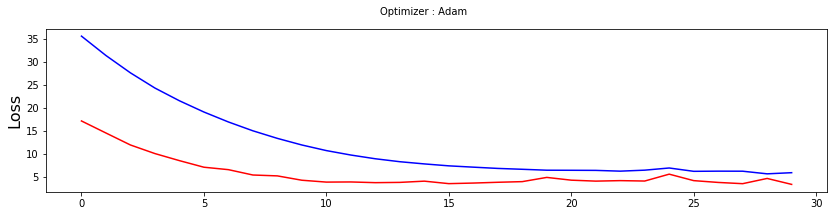

In [51]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(14,3))

# plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(res.history['loss'], color='b', label='Training Loss')
plt.plot(res.history['val_loss'], color='r', label='Validation Loss')
plt.show()

# plt.legend(loc='upper right')

# plt.subplot(1, 2, 2)
# plt.ylabel('Accuracy', fontsize=16)
# plt.plot(res.history['acc'], color='b', label='Training Accuracy')
# plt.plot(res.history['val_acc'], color='r', label='Validation Accuracy')
# plt.legend(loc='lower right')


In [52]:
import keras.models
with open("pathInertia.json", "r") as json_file:
    loaded_model_json = json_file.read()
    loaded_model = keras.models.model_from_json(loaded_model_json)
    loaded_model.load_weights("pathInertia.h5")
    print("Model loaded from disk")
    loaded_model.summary()

Model loaded from disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 3)                 84        
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 12        
Total params: 96
Trainable params: 96
Non-trainable params: 0
_________________________________________________________________


In [53]:
for i,j in zip(train_data,train_target):
    print("input")
    print(i)
    print("predict::")
    print(j)
    print(loaded_model.predict(np.array([i])))#np.array([[[2,1],[2,1],[2,1],[2,1],[2,1],[2,1],[2,1],[2,1],[2,1]]]))

input
[[  7.92840000e+03   5.00000000e-01   1.00000000e+00]
 [  3.00000000e-01   4.40000000e+00   1.00000000e+00]
 [  1.00000000e-01   2.30000000e+00   1.00000000e+00]
 [  4.00000000e-01   2.30000000e+00   1.00000000e+00]
 [  1.00000000e-01   3.30000000e+00   1.00000000e+00]
 [  5.00000000e-01   1.00000000e-01   0.00000000e+00]
 [  1.00000000e-01   5.90000000e+00   1.00000000e+00]
 [  4.00000000e-01   3.10000000e+00   1.00000000e+00]
 [  1.00000000e-01   1.80000000e+00   1.00000000e+00]]
predict::
['0.3' '3.9000000000000004' '1']
[[ 0.          4.93096542  0.99763918]]
input
[[ 0.3  4.4  1. ]
 [ 0.1  2.3  1. ]
 [ 0.4  2.3  1. ]
 [ 0.1  3.3  1. ]
 [ 0.5  0.1  0. ]
 [ 0.1  5.9  1. ]
 [ 0.4  3.1  1. ]
 [ 0.1  1.8  1. ]
 [ 0.3  0.9  1. ]]
predict::
['0.4' '3.5999999999999996' '1']
[[ 0.          3.28048515  1.08252645]]
input
[[ 0.1  2.3  1. ]
 [ 0.4  2.3  1. ]
 [ 0.1  3.3  1. ]
 [ 0.5  0.1  0. ]
 [ 0.1  5.9  1. ]
 [ 0.4  3.1  1. ]
 [ 0.1  1.8  1. ]
 [ 0.3  0.9  1. ]
 [ 0.3  3.9  1. ]]
pre

[[  0.          15.00650024   0.5254128 ]]
input
[[  0.4  15.6   1. ]
 [  0.7  15.    1. ]
 [  0.4  15.4   1. ]
 [  0.6  15.5   1. ]
 [  0.5  15.9   1. ]
 [  0.6  14.7   1. ]
 [  0.4  14.4   1. ]
 [  0.6  14.9   1. ]
 [  0.8  12.5   1. ]]
predict::
['0.8' '4.8' '0']
[[  0.          13.0267067    0.67677116]]
input
[[  0.7  15.    1. ]
 [  0.4  15.4   1. ]
 [  0.6  15.5   1. ]
 [  0.5  15.9   1. ]
 [  0.6  14.7   1. ]
 [  0.4  14.4   1. ]
 [  0.6  14.9   1. ]
 [  0.8  12.5   1. ]
 [  0.6   5.9   1. ]]
predict::
['0.9' '13.200000000000001' '0']
[[ 0.          9.05008125  0.8314023 ]]
input
[[  0.4  15.4   1. ]
 [  0.6  15.5   1. ]
 [  0.5  15.9   1. ]
 [  0.6  14.7   1. ]
 [  0.4  14.4   1. ]
 [  0.6  14.9   1. ]
 [  0.8  12.5   1. ]
 [  0.6   5.9   1. ]
 [  0.8   4.8   0. ]]
predict::
['0.6' '10.0' '0']
[[ 0.          7.25588322  0.68398428]]
input
[[  0.6  15.5   1. ]
 [  0.5  15.9   1. ]
 [  0.6  14.7   1. ]
 [  0.4  14.4   1. ]
 [  0.6  14.9   1. ]
 [  0.8  12.5   1. ]
 [  0.6   5.9 

predict::
['0.8' '8.0' '1']
[[ 2.51967621  4.05916309  1.01229739]]
input
[[  1.1  13.6   0. ]
 [  1.2   8.5   0. ]
 [  0.7   8.5   0. ]
 [  1.    6.7   0. ]
 [  1.1   4.4   0. ]
 [  0.9   0.6   0. ]
 [  1.1   3.2   1. ]
 [  1.1   4.5   1. ]
 [  1.1   5.7   1. ]]
predict::
['1.0' '8.100000000000001' '1']
[[ 0.09463501  4.97908115  1.04373264]]
input
[[ 1.2  8.5  0. ]
 [ 0.7  8.5  0. ]
 [ 1.   6.7  0. ]
 [ 1.1  4.4  0. ]
 [ 0.9  0.6  0. ]
 [ 1.1  3.2  1. ]
 [ 1.1  4.5  1. ]
 [ 1.1  5.7  1. ]
 [ 0.8  8.   1. ]]
predict::
['1.4' '8.0' '1']
[[ 0.          6.82247877  0.91811013]]
input
[[ 0.7  8.5  0. ]
 [ 1.   6.7  0. ]
 [ 1.1  4.4  0. ]
 [ 0.9  0.6  0. ]
 [ 1.1  3.2  1. ]
 [ 1.1  4.5  1. ]
 [ 1.1  5.7  1. ]
 [ 0.8  8.   1. ]
 [ 1.   8.1  1. ]]
predict::
['1.0' '9.5' '1']
[[ 0.          7.62290001  0.9517715 ]]
input
[[ 1.   6.7  0. ]
 [ 1.1  4.4  0. ]
 [ 0.9  0.6  0. ]
 [ 1.1  3.2  1. ]
 [ 1.1  4.5  1. ]
 [ 1.1  5.7  1. ]
 [ 0.8  8.   1. ]
 [ 1.   8.1  1. ]
 [ 1.4  8.   1. ]]
predict::
[

predict::
['1.5' '7.5' '0']
[[ 0.          7.79763556  0.80782104]]
input
[[ 1.7  3.2  0. ]
 [ 1.9  4.   0. ]
 [ 1.4  5.9  0. ]
 [ 1.8  6.3  0. ]
 [ 1.6  6.5  0. ]
 [ 1.3  7.5  0. ]
 [ 1.3  8.   0. ]
 [ 1.5  7.1  0. ]
 [ 1.7  9.1  0. ]]
predict::
['1.8' '7.5' '0']
[[ 0.          8.81750298  0.71087003]]
input
[[ 1.9  4.   0. ]
 [ 1.4  5.9  0. ]
 [ 1.8  6.3  0. ]
 [ 1.6  6.5  0. ]
 [ 1.3  7.5  0. ]
 [ 1.3  8.   0. ]
 [ 1.5  7.1  0. ]
 [ 1.7  9.1  0. ]
 [ 1.5  7.5  0. ]]
predict::
['1.5' '7.800000000000001' '0']
[[ 0.          8.29266357  0.76270604]]
input
[[ 1.4  5.9  0. ]
 [ 1.8  6.3  0. ]
 [ 1.6  6.5  0. ]
 [ 1.3  7.5  0. ]
 [ 1.3  8.   0. ]
 [ 1.5  7.1  0. ]
 [ 1.7  9.1  0. ]
 [ 1.5  7.5  0. ]
 [ 1.8  7.5  0. ]]
predict::
['1.8' '9.0' '0']
[[ 0.          7.85577774  0.79508781]]
input
[[ 1.8  6.3  0. ]
 [ 1.6  6.5  0. ]
 [ 1.3  7.5  0. ]
 [ 1.3  8.   0. ]
 [ 1.5  7.1  0. ]
 [ 1.7  9.1  0. ]
 [ 1.5  7.5  0. ]
 [ 1.8  7.5  0. ]
 [ 1.5  7.8  0. ]]
predict::
['1.4' '9.0' '0']
[[ 0.     

 [ 2.3  8.4  1. ]]
predict::
['2.1' '7.7' '1']
[[ 1.24262238  7.99119663  0.98747659]]
input
[[ 2.4  8.9  1. ]
 [ 1.9  8.   1. ]
 [ 1.8  7.7  1. ]
 [ 1.9  7.9  1. ]
 [ 2.3  8.6  1. ]
 [ 2.4  8.5  1. ]
 [ 1.5  7.7  1. ]
 [ 2.3  8.4  1. ]
 [ 2.6  8.7  1. ]]
predict::
['2.5' '8.0' '1']
[[ 1.73552704  8.19762516  0.9577477 ]]
input
[[ 1.9  8.   1. ]
 [ 1.8  7.7  1. ]
 [ 1.9  7.9  1. ]
 [ 2.3  8.6  1. ]
 [ 2.4  8.5  1. ]
 [ 1.5  7.7  1. ]
 [ 2.3  8.4  1. ]
 [ 2.6  8.7  1. ]
 [ 2.1  7.7  1. ]]
predict::
['2.5' '7.199999999999999' '1']
[[ 1.9667511   7.73361874  0.98853302]]
input
[[ 1.8  7.7  1. ]
 [ 1.9  7.9  1. ]
 [ 2.3  8.6  1. ]
 [ 2.4  8.5  1. ]
 [ 1.5  7.7  1. ]
 [ 2.3  8.4  1. ]
 [ 2.6  8.7  1. ]
 [ 2.1  7.7  1. ]
 [ 2.5  8.   1. ]]
predict::
['2.3' '7.6' '1']
[[ 1.95724106  7.71866703  0.98083687]]
input
[[ 1.9  7.9  1. ]
 [ 2.3  8.6  1. ]
 [ 2.4  8.5  1. ]
 [ 1.5  7.7  1. ]
 [ 2.3  8.4  1. ]
 [ 2.6  8.7  1. ]
 [ 2.1  7.7  1. ]
 [ 2.5  8.   1. ]
 [ 2.5  7.2  1. ]]
predict::
['2.3' '7

[[ 2.34568787  5.68425655  0.91730666]]
input
[[ 3.1  6.9  0. ]
 [ 2.9  6.3  0. ]
 [ 2.9  5.6  0. ]
 [ 2.9  5.5  0. ]
 [ 2.8  6.   0. ]
 [ 4.3  6.2  0. ]
 [ 3.2  3.5  0. ]
 [ 2.5  5.6  0. ]
 [ 4.2  4.3  0. ]]
predict::
['3.1' '3.3000000000000003' '0']
[[ 3.63417053  5.18795204  0.9933641 ]]
input
[[ 2.9  6.3  0. ]
 [ 2.9  5.6  0. ]
 [ 2.9  5.5  0. ]
 [ 2.8  6.   0. ]
 [ 4.3  6.2  0. ]
 [ 3.2  3.5  0. ]
 [ 2.5  5.6  0. ]
 [ 4.2  4.3  0. ]
 [ 2.8  3.6  0. ]]
predict::
['4.1' '1.3' '0']
[[ 3.79737854  4.75077534  0.95152116]]
input
[[ 2.9  5.6  0. ]
 [ 2.9  5.5  0. ]
 [ 2.8  6.   0. ]
 [ 4.3  6.2  0. ]
 [ 3.2  3.5  0. ]
 [ 2.5  5.6  0. ]
 [ 4.2  4.3  0. ]
 [ 2.8  3.6  0. ]
 [ 3.1  3.3  0. ]]
predict::
['3.6' '0.5' '0']
[[ 3.30016708  4.4943285   0.99132109]]
input
[[ 2.9  5.5  0. ]
 [ 2.8  6.   0. ]
 [ 4.3  6.2  0. ]
 [ 3.2  3.5  0. ]
 [ 2.5  5.6  0. ]
 [ 4.2  4.3  0. ]
 [ 2.8  3.6  0. ]
 [ 3.1  3.3  0. ]
 [ 4.1  1.3  0. ]]
predict::
['3.7' '1.5' '1']
[[ 5.26727295  3.66204834  1.01467299

[[ 3.92010117  8.96795368  0.75138688]]
input
[[ 3.9  8.4  0. ]
 [ 3.9  6.9  0. ]
 [ 4.2  8.6  0. ]
 [ 4.3  7.1  0. ]
 [ 4.6  9.6  0. ]
 [ 3.   8.7  0. ]
 [ 4.7  7.4  0. ]
 [ 4.4  9.6  0. ]
 [ 3.7  8.1  0. ]]
predict::
['5.1' '9.3' '0']
[[ 3.47282791  8.41786003  0.84492826]]
input
[[ 3.9  6.9  0. ]
 [ 4.2  8.6  0. ]
 [ 4.3  7.1  0. ]
 [ 4.6  9.6  0. ]
 [ 3.   8.7  0. ]
 [ 4.7  7.4  0. ]
 [ 4.4  9.6  0. ]
 [ 3.7  8.1  0. ]
 [ 4.3  8.4  0. ]]
predict::
['3.3' '7.3' '0']
[[ 4.00268555  8.31057739  0.82068062]]
input
[[ 4.2  8.6  0. ]
 [ 4.3  7.1  0. ]
 [ 4.6  9.6  0. ]
 [ 3.   8.7  0. ]
 [ 4.7  7.4  0. ]
 [ 4.4  9.6  0. ]
 [ 3.7  8.1  0. ]
 [ 4.3  8.4  0. ]
 [ 5.1  9.3  0. ]]
predict::
['5.0' '8.5' '0']
[[ 4.18958282  8.95091343  0.78836656]]
input
[[ 4.3  7.1  0. ]
 [ 4.6  9.6  0. ]
 [ 3.   8.7  0. ]
 [ 4.7  7.4  0. ]
 [ 4.4  9.6  0. ]
 [ 3.7  8.1  0. ]
 [ 4.3  8.4  0. ]
 [ 5.1  9.3  0. ]
 [ 3.3  7.3  0. ]]
predict::
['3.4' '8.0' '0']
[[ 4.00222778  7.92076302  0.85079312]]
input
[[ 4.6

[[ 6.1  7.   0. ]
 [ 5.3  6.5  0. ]
 [ 6.7  7.6  0. ]
 [ 6.   7.   0. ]
 [ 5.4  7.9  0. ]
 [ 6.5  7.5  0. ]
 [ 5.7  7.8  0. ]
 [ 6.4  7.2  0. ]
 [ 6.2  7.3  0. ]]
predict::
['6.4' '7.0' '0']
[[ 5.84909821  7.31867599  0.85977483]]
input
[[ 5.3  6.5  0. ]
 [ 6.7  7.6  0. ]
 [ 6.   7.   0. ]
 [ 5.4  7.9  0. ]
 [ 6.5  7.5  0. ]
 [ 5.7  7.8  0. ]
 [ 6.4  7.2  0. ]
 [ 6.2  7.3  0. ]
 [ 6.3  7.4  0. ]]
predict::
['5.9' '6.4' '0']
[[ 5.67305374  7.39028072  0.86337113]]
input
[[ 6.7  7.6  0. ]
 [ 6.   7.   0. ]
 [ 5.4  7.9  0. ]
 [ 6.5  7.5  0. ]
 [ 5.7  7.8  0. ]
 [ 6.4  7.2  0. ]
 [ 6.2  7.3  0. ]
 [ 6.3  7.4  0. ]
 [ 6.4  7.   0. ]]
predict::
['6.2' '6.0' '0']
[[ 5.93431854  7.16384792  0.87871885]]
input
[[ 6.   7.   0. ]
 [ 5.4  7.9  0. ]
 [ 6.5  7.5  0. ]
 [ 5.7  7.8  0. ]
 [ 6.4  7.2  0. ]
 [ 6.2  7.3  0. ]
 [ 6.3  7.4  0. ]
 [ 6.4  7.   0. ]
 [ 5.9  6.4  0. ]]
predict::
['6.9' '5.5' '0']
[[ 5.98628998  6.75860977  0.88986278]]
input
[[ 5.4  7.9  0. ]
 [ 6.5  7.5  0. ]
 [ 5.7  7.8  0. 

 [ 13.7   5.8   0. ]]
predict::
['9.2' '5.0' '0']
[[ 10.88310242   6.12120914   0.9603889 ]]
input
[[ 12.5   6.8   0. ]
 [  4.8   7.1   0. ]
 [ 11.7   7.1   0. ]
 [  5.2   6.3   0. ]
 [  8.1   7.    0. ]
 [  9.5   6.7   0. ]
 [  8.    6.2   0. ]
 [ 13.7   5.8   0. ]
 [  4.5   5.2   0. ]]
predict::
['14.1' '3.3000000000000003' '0']
[[ 7.66897202  5.90015411  0.82905602]]
input
[[  4.8   7.1   0. ]
 [ 11.7   7.1   0. ]
 [  5.2   6.3   0. ]
 [  8.1   7.    0. ]
 [  9.5   6.7   0. ]
 [  8.    6.2   0. ]
 [ 13.7   5.8   0. ]
 [  4.5   5.2   0. ]
 [  9.2   5.    0. ]]
predict::
['5.0' '2.3000000000000003' '0']
[[ 7.56820297  5.66938019  0.98916817]]
input
[[ 11.7   7.1   0. ]
 [  5.2   6.3   0. ]
 [  8.1   7.    0. ]
 [  9.5   6.7   0. ]
 [  8.    6.2   0. ]
 [ 13.7   5.8   0. ]
 [  4.5   5.2   0. ]
 [  9.2   5.    0. ]
 [ 14.1   3.3   0. ]]
predict::
['9.7' '1.0' '0']
[[ 12.88572311   4.45624542   1.02560425]]
input
[[  5.2   6.3   0. ]
 [  8.1   7.    0. ]
 [  9.5   6.7   0. ]
 [  8.    6.

 [ 10.6  26.3   0. ]]
predict::
['11.8' '25.4' '0']
[[  6.08744431  25.83827591   0.        ]]
input
[[ 11.6  21.5   1. ]
 [  8.8  23.3   1. ]
 [ 10.9  24.5   1. ]
 [ 13.   27.8   1. ]
 [ 10.8  30.7   1. ]
 [ 12.6  29.2   0. ]
 [ 11.8  27.8   0. ]
 [ 10.6  26.3   0. ]
 [ 12.9  26.4   0. ]]
predict::
['10.4' '25.5' '0']
[[  8.10943604  25.99479294   0.        ]]
input
[[  8.8  23.3   1. ]
 [ 10.9  24.5   1. ]
 [ 13.   27.8   1. ]
 [ 10.8  30.7   1. ]
 [ 12.6  29.2   0. ]
 [ 11.8  27.8   0. ]
 [ 10.6  26.3   0. ]
 [ 12.9  26.4   0. ]
 [ 11.8  25.4   0. ]]
predict::
['11.4' '25.0' '0']
[[  5.92288589  25.0305748    0.        ]]
input
[[ 10.9  24.5   1. ]
 [ 13.   27.8   1. ]
 [ 10.8  30.7   1. ]
 [ 12.6  29.2   0. ]
 [ 11.8  27.8   0. ]
 [ 10.6  26.3   0. ]
 [ 12.9  26.4   0. ]
 [ 11.8  25.4   0. ]
 [ 10.4  25.5   0. ]]
predict::
['12.3' '25.4' '0']
[[  5.61516571  25.07617569   0.        ]]
input
[[ 13.   27.8   1. ]
 [ 10.8  30.7   1. ]
 [ 12.6  29.2   0. ]
 [ 11.8  27.8   0. ]
 [ 10.6 

[[ 14.51190567  28.0639801    0.        ]]
input
[[ 13.   22.7   1. ]
 [ 11.   22.9   1. ]
 [ 12.8  22.7   1. ]
 [ 13.8  23.2   1. ]
 [ 12.3  24.2   1. ]
 [ 13.8  24.6   1. ]
 [ 13.4  27.    1. ]
 [ 12.6  29.6   1. ]
 [ 15.   30.5   0. ]]
predict::
['14.0' '26.5' '0']
[[ 16.21113205  29.00666046   0.        ]]
input
[[ 11.   22.9   1. ]
 [ 12.8  22.7   1. ]
 [ 13.8  23.2   1. ]
 [ 12.3  24.2   1. ]
 [ 13.8  24.6   1. ]
 [ 13.4  27.    1. ]
 [ 12.6  29.6   1. ]
 [ 15.   30.5   0. ]
 [ 15.1  28.4   0. ]]
predict::
['13.3' '25.099999999999998' '0']
[[ 11.36348343  27.72305298   0.        ]]
input
[[ 12.8  22.7   1. ]
 [ 13.8  23.2   1. ]
 [ 12.3  24.2   1. ]
 [ 13.8  24.6   1. ]
 [ 13.4  27.    1. ]
 [ 12.6  29.6   1. ]
 [ 15.   30.5   0. ]
 [ 15.1  28.4   0. ]
 [ 14.   26.5   0. ]]
predict::
['13.1' '25.299999999999997' '0']
[[  8.58181763  26.09861755   0.        ]]
input
[[ 13.8  23.2   1. ]
 [ 12.3  24.2   1. ]
 [ 13.8  24.6   1. ]
 [ 13.4  27.    1. ]
 [ 12.6  29.6   1. ]
 [ 15.   30

[[ 12.39359665  24.32913017   0.        ]]
input
[[ 18.4  25.7   0. ]
 [ 16.3  24.1   0. ]
 [ 16.   24.4   0. ]
 [ 15.8  24.1   0. ]
 [ 16.5  24.3   0. ]
 [ 16.   24.3   0. ]
 [ 18.3  24.7   0. ]
 [ 16.9  24.8   0. ]
 [ 17.1  25.8   0. ]]
predict::
['19.5' '27.799999999999997' '0']
[[ 13.76409912  25.23016167   0.        ]]
input
[[ 16.3  24.1   0. ]
 [ 16.   24.4   0. ]
 [ 15.8  24.1   0. ]
 [ 16.5  24.3   0. ]
 [ 16.   24.3   0. ]
 [ 18.3  24.7   0. ]
 [ 16.9  24.8   0. ]
 [ 17.1  25.8   0. ]
 [ 18.   26.4   0. ]]
predict::
['17.4' '28.900000000000002' '0']
[[ 14.86405182  25.79194832   0.        ]]
input
[[ 16.   24.4   0. ]
 [ 15.8  24.1   0. ]
 [ 16.5  24.3   0. ]
 [ 16.   24.3   0. ]
 [ 18.3  24.7   0. ]
 [ 16.9  24.8   0. ]
 [ 17.1  25.8   0. ]
 [ 18.   26.4   0. ]
 [ 19.5  27.8   0. ]]
predict::
['16.7' '30.9' '0']
[[ 16.94336319  26.99069214   0.        ]]
input
[[ 15.8  24.1   0. ]
 [ 16.5  24.3   0. ]
 [ 16.   24.3   0. ]
 [ 18.3  24.7   0. ]
 [ 16.9  24.8   0. ]
 [ 17.1  25

predict::
['24.3' '27.7' '1']
[[ 18.61878777  27.69522285   0.        ]]
input
[[ 21.7  26.1   0. ]
 [ 19.3  27.2   0. ]
 [ 24.9  28.3   0. ]
 [ 22.2  30.3   0. ]
 [ 21.2  30.8   1. ]
 [ 24.4  29.5   1. ]
 [ 22.7  29.1   1. ]
 [ 21.9  28.7   1. ]
 [ 20.3  27.3   1. ]]
predict::
['22.6' '26.299999999999997' '1']
[[ 16.00904846  26.54553986   0.        ]]
input
[[ 19.3  27.2   0. ]
 [ 24.9  28.3   0. ]
 [ 22.2  30.3   0. ]
 [ 21.2  30.8   1. ]
 [ 24.4  29.5   1. ]
 [ 22.7  29.1   1. ]
 [ 21.9  28.7   1. ]
 [ 20.3  27.3   1. ]
 [ 24.3  27.7   1. ]]
predict::
['21.4' '26.7' '1']
[[ 19.06408119  26.82686996   0.        ]]
input
[[ 24.9  28.3   0. ]
 [ 22.2  30.3   0. ]
 [ 21.2  30.8   1. ]
 [ 24.4  29.5   1. ]
 [ 22.7  29.1   1. ]
 [ 21.9  28.7   1. ]
 [ 20.3  27.3   1. ]
 [ 24.3  27.7   1. ]
 [ 22.6  26.3   1. ]]
predict::
['22.3' '25.6' '1']
[[ 16.74526978  25.62279129   0.        ]]
input
[[ 22.2  30.3   0. ]
 [ 21.2  30.8   1. ]
 [ 24.4  29.5   1. ]
 [ 22.7  29.1   1. ]
 [ 21.9  28.7   

[[ 28.9   5.5   0. ]
 [ 27.9   4.2   0. ]
 [ 26.5   0.1   0. ]
 [ 29.5   3.8   1. ]
 [ 25.3   6.4   1. ]
 [ 23.8   8.2   1. ]
 [ 23.8   8.9   1. ]
 [ 24.9   9.5   1. ]
 [ 25.    9.9   1. ]]
predict::
['23.7' '10.0' '1']
[[ 21.52727509   9.24702454   0.82286572]]
input
[[ 27.9   4.2   0. ]
 [ 26.5   0.1   0. ]
 [ 29.5   3.8   1. ]
 [ 25.3   6.4   1. ]
 [ 23.8   8.2   1. ]
 [ 23.8   8.9   1. ]
 [ 24.9   9.5   1. ]
 [ 25.    9.9   1. ]
 [ 24.2  10.5   1. ]]
predict::
['24.6' '10.8' '1']
[[ 21.29242706   9.79205704   0.7853353 ]]
input
[[ 26.5   0.1   0. ]
 [ 29.5   3.8   1. ]
 [ 25.3   6.4   1. ]
 [ 23.8   8.2   1. ]
 [ 23.8   8.9   1. ]
 [ 24.9   9.5   1. ]
 [ 25.    9.9   1. ]
 [ 24.2  10.5   1. ]
 [ 23.7  10.    1. ]]
predict::
['25.5' '10.4' '1']
[[ 21.03168869   9.60391426   0.81596708]]
input
[[ 29.5   3.8   1. ]
 [ 25.3   6.4   1. ]
 [ 23.8   8.2   1. ]
 [ 23.8   8.9   1. ]
 [ 24.9   9.5   1. ]
 [ 25.    9.9   1. ]
 [ 24.2  10.5   1. ]
 [ 23.7  10.    1. ]
 [ 24.6  10.8   1. ]]
pre

[[ 25.13044739  11.4909029    0.6846664 ]]
input
[[ 26.7  12.1   1. ]
 [ 29.6  12.1   1. ]
 [ 30.4  12.1   1. ]
 [ 29.9  12.    1. ]
 [ 27.2  11.5   1. ]
 [ 28.7  11.9   1. ]
 [ 30.6  12.2   1. ]
 [ 28.3  12.1   1. ]
 [ 27.7  11.3   1. ]]
predict::
['31.8' '9.9' '1']
[[ 24.42386246  10.93681145   0.73702073]]
input
[[ 29.6  12.1   1. ]
 [ 30.4  12.1   1. ]
 [ 29.9  12.    1. ]
 [ 27.2  11.5   1. ]
 [ 28.7  11.9   1. ]
 [ 30.6  12.2   1. ]
 [ 28.3  12.1   1. ]
 [ 27.7  11.3   1. ]
 [ 29.9  11.1   1. ]]
predict::
['33.9' '8.2' '1']
[[ 25.5838356   10.63099289   0.74806738]]
input
[[ 30.4  12.1   1. ]
 [ 29.9  12.    1. ]
 [ 27.2  11.5   1. ]
 [ 28.7  11.9   1. ]
 [ 30.6  12.2   1. ]
 [ 28.3  12.1   1. ]
 [ 27.7  11.3   1. ]
 [ 29.9  11.1   1. ]
 [ 31.8   9.9   1. ]]
predict::
['32.8' '5.6000000000000005' '1']
[[ 27.52371979   9.68443012   0.79490614]]
input
[[ 29.9  12.    1. ]
 [ 27.2  11.5   1. ]
 [ 28.7  11.9   1. ]
 [ 30.6  12.2   1. ]
 [ 28.3  12.1   1. ]
 [ 27.7  11.3   1. ]
 [ 29.

[[ 28.81422043  12.44228363   0.60252607]]
input
[[ 35.7  12.1   1. ]
 [ 34.   12.2   1. ]
 [ 34.9  12.2   1. ]
 [ 36.7  12.5   1. ]
 [ 31.8  12.1   1. ]
 [ 39.8  12.5   1. ]
 [ 32.8  12.6   1. ]
 [ 32.5  13.2   1. ]
 [ 35.8  13.3   1. ]]
predict::
['34.8' '13.4' '1']
[[ 30.29236984  12.68209076   0.60283649]]
input
[[ 34.   12.2   1. ]
 [ 34.9  12.2   1. ]
 [ 36.7  12.5   1. ]
 [ 31.8  12.1   1. ]
 [ 39.8  12.5   1. ]
 [ 32.8  12.6   1. ]
 [ 32.5  13.2   1. ]
 [ 35.8  13.3   1. ]
 [ 36.7  13.1   1. ]]
predict::
['34.5' '13.799999999999999' '1']
[[ 31.92828369  12.40806484   0.59639513]]
input
[[ 34.9  12.2   1. ]
 [ 36.7  12.5   1. ]
 [ 31.8  12.1   1. ]
 [ 39.8  12.5   1. ]
 [ 32.8  12.6   1. ]
 [ 32.5  13.2   1. ]
 [ 35.8  13.3   1. ]
 [ 36.7  13.1   1. ]
 [ 34.8  13.4   1. ]]
predict::
['35.7' '14.2' '1']
[[ 31.28884125  12.56020164   0.57286429]]
input
[[ 36.7  12.5   1. ]
 [ 31.8  12.1   1. ]
 [ 39.8  12.5   1. ]
 [ 32.8  12.6   1. ]
 [ 32.5  13.2   1. ]
 [ 35.8  13.3   1. ]
 [ 3

 [ 54.6  31.4   0. ]]
predict::
['53.8' '28.700000000000003' '1']
[[ 49.32628632  29.07804871   0.        ]]
input
[[ 44.2  24.2   0. ]
 [ 47.7  25.5   0. ]
 [ 50.5  26.4   0. ]
 [ 46.5  27.6   0. ]
 [ 51.9  28.5   0. ]
 [ 53.   29.5   0. ]
 [ 52.6  30.5   0. ]
 [ 54.6  31.4   0. ]
 [ 49.7  29.9   1. ]]
predict::
['48.7' '26.200000000000003' '1']
[[ 48.4283905   28.50929642   0.        ]]
input
[[ 47.7  25.5   0. ]
 [ 50.5  26.4   0. ]
 [ 46.5  27.6   0. ]
 [ 51.9  28.5   0. ]
 [ 53.   29.5   0. ]
 [ 52.6  30.5   0. ]
 [ 54.6  31.4   0. ]
 [ 49.7  29.9   1. ]
 [ 53.8  28.7   1. ]]
predict::
['44.9' '23.900000000000002' '1']
[[ 50.1782608   27.22099686   0.        ]]
input
[[ 50.5  26.4   0. ]
 [ 46.5  27.6   0. ]
 [ 51.9  28.5   0. ]
 [ 53.   29.5   0. ]
 [ 52.6  30.5   0. ]
 [ 54.6  31.4   0. ]
 [ 49.7  29.9   1. ]
 [ 53.8  28.7   1. ]
 [ 48.7  26.2   1. ]]
predict::
['45.2' '20.099999999999998' '1']
[[ 44.12817383  25.29782677   0.        ]]
input
[[ 46.5  27.6   0. ]
 [ 51.9  28.5  

[[ 26.49205017  18.45239067   0.06835687]]
input
[[ 51.4  15.5   0. ]
 [ 49.6  15.3   0. ]
 [ 46.4  15.7   0. ]
 [ 46.8  15.5   0. ]
 [ 48.9  16.    0. ]
 [ 48.3  17.    0. ]
 [ 46.7  17.6   0. ]
 [ 28.9  19.4   0. ]
 [ 82.3  22.6   0. ]]
predict::
['57.5' '27.0' '0']
[[ 67.34643555  21.83353806   0.        ]]
input
[[ 49.6  15.3   0. ]
 [ 46.4  15.7   0. ]
 [ 46.8  15.5   0. ]
 [ 48.9  16.    0. ]
 [ 48.3  17.    0. ]
 [ 46.7  17.6   0. ]
 [ 28.9  19.4   0. ]
 [ 82.3  22.6   0. ]
 [ 60.4  25.    0. ]]
predict::
['32.2' '28.1' '0']
[[ 53.21690369  23.07645035   0.        ]]
input
[[ 46.4  15.7   0. ]
 [ 46.8  15.5   0. ]
 [ 48.9  16.    0. ]
 [ 48.3  17.    0. ]
 [ 46.7  17.6   0. ]
 [ 28.9  19.4   0. ]
 [ 82.3  22.6   0. ]
 [ 60.4  25.    0. ]
 [ 57.5  27.    0. ]]
predict::
['99.4' '29.3' '0']
[[ 49.10209656  24.622118     0.        ]]
input
[[ 46.8  15.5   0. ]
 [ 48.9  16.    0. ]
 [ 48.3  17.    0. ]
 [ 46.7  17.6   0. ]
 [ 28.9  19.4   0. ]
 [ 82.3  22.6   0. ]
 [ 60.4  25.    0.

[[ 53.31750107  13.93108559   0.17414522]]
input
[[ 89.7  16.5   0. ]
 [ 57.   16.    0. ]
 [ 30.3  16.    0. ]
 [ 56.8  15.4   0. ]
 [ 54.6  15.    0. ]
 [ 54.6  15.2   0. ]
 [ 58.5  15.3   0. ]
 [ 56.2  15.    0. ]
 [ 56.3  15.4   0. ]]
predict::
['56.5' '15.0' '0']
[[ 52.8596611   14.24505424   0.16266966]]
input
[[ 57.   16.    0. ]
 [ 30.3  16.    0. ]
 [ 56.8  15.4   0. ]
 [ 54.6  15.    0. ]
 [ 54.6  15.2   0. ]
 [ 58.5  15.3   0. ]
 [ 56.2  15.    0. ]
 [ 56.3  15.4   0. ]
 [ 56.3  15.3   0. ]]
predict::
['60.4' '15.4' '0']
[[ 52.41331863  14.24961948   0.17640543]]
input
[[ 30.3  16.    0. ]
 [ 56.8  15.4   0. ]
 [ 54.6  15.    0. ]
 [ 54.6  15.2   0. ]
 [ 58.5  15.3   0. ]
 [ 56.2  15.    0. ]
 [ 56.3  15.4   0. ]
 [ 56.3  15.3   0. ]
 [ 56.5  15.    0. ]]
predict::
['51.3' '14.9' '0']
[[ 52.57258987  13.96986008   0.19073081]]
input
[[ 56.8  15.4   0. ]
 [ 54.6  15.    0. ]
 [ 54.6  15.2   0. ]
 [ 58.5  15.3   0. ]
 [ 56.2  15.    0. ]
 [ 56.3  15.4   0. ]
 [ 56.3  15.3   0.

predict::
['68.1' '10.4' '1']
[[ 68.72999573   8.38987923   0.365448  ]]
input
[[ 75.1   5.1   1. ]
 [ 75.6   6.7   1. ]
 [ 74.5   8.1   1. ]
 [ 70.7   8.2   1. ]
 [ 67.6   8.8   1. ]
 [ 73.    8.9   1. ]
 [ 71.9   9.8   1. ]
 [ 71.7   9.5   1. ]
 [ 66.3  10.4   1. ]]
predict::
['68.8' '11.0' '1']
[[ 65.56759644   9.00673199   0.4159075 ]]
input
[[ 75.6   6.7   1. ]
 [ 74.5   8.1   1. ]
 [ 70.7   8.2   1. ]
 [ 67.6   8.8   1. ]
 [ 73.    8.9   1. ]
 [ 71.9   9.8   1. ]
 [ 71.7   9.5   1. ]
 [ 66.3  10.4   1. ]
 [ 68.1  10.4   1. ]]
predict::
['71.1' '11.799999999999999' '1']
[[ 64.69682312   9.21202374   0.42494476]]
input
[[ 74.5   8.1   1. ]
 [ 70.7   8.2   1. ]
 [ 67.6   8.8   1. ]
 [ 73.    8.9   1. ]
 [ 71.9   9.8   1. ]
 [ 71.7   9.5   1. ]
 [ 66.3  10.4   1. ]
 [ 68.1  10.4   1. ]
 [ 68.8  11.    1. ]]
predict::
['67.4' '12.1' '1']
[[ 65.36555481   9.5815506    0.39235568]]
input
[[ 70.7   8.2   1. ]
 [ 67.6   8.8   1. ]
 [ 73.    8.9   1. ]
 [ 71.9   9.8   1. ]
 [ 71.7   9.5   

input
[[ 69.6  14.2   0. ]
 [ 76.9  12.9   0. ]
 [ 78.5  10.7   0. ]
 [ 76.1   9.1   0. ]
 [ 86.7   8.1   0. ]
 [ 85.1   7.5   0. ]
 [ 83.4   6.6   0. ]
 [ 83.1   6.6   0. ]
 [ 87.    5.8   0. ]]
predict::
['88.9' '5.1' '0']
[[ 81.89785004   5.34610367   0.0844487 ]]
input
[[ 76.9  12.9   0. ]
 [ 78.5  10.7   0. ]
 [ 76.1   9.1   0. ]
 [ 86.7   8.1   0. ]
 [ 85.1   7.5   0. ]
 [ 83.4   6.6   0. ]
 [ 83.1   6.6   0. ]
 [ 87.    5.8   0. ]
 [ 92.4   5.8   0. ]]
predict::
['93.2' '4.5' '0']
[[ 87.67120361   4.96913528   0.        ]]
input
[[ 78.5  10.7   0. ]
 [ 76.1   9.1   0. ]
 [ 86.7   8.1   0. ]
 [ 85.1   7.5   0. ]
 [ 83.4   6.6   0. ]
 [ 83.1   6.6   0. ]
 [ 87.    5.8   0. ]
 [ 92.4   5.8   0. ]
 [ 88.9   5.1   0. ]]
predict::
['89.1' '4.4' '0']
[[ 85.58189392   4.80842495   0.        ]]
input
[[ 76.1   9.1   0. ]
 [ 86.7   8.1   0. ]
 [ 85.1   7.5   0. ]
 [ 83.4   6.6   0. ]
 [ 83.1   6.6   0. ]
 [ 87.    5.8   0. ]
 [ 92.4   5.8   0. ]
 [ 88.9   5.1   0. ]
 [ 93.2   4.5   0. ]]


[[ 83.7  13.4   1. ]
 [ 89.2  13.4   1. ]
 [ 83.1  14.    1. ]
 [ 85.   14.3   1. ]
 [ 88.1  14.5   1. ]
 [ 77.8  14.7   1. ]
 [ 84.3  15.1   1. ]
 [ 81.7  16.6   1. ]
 [ 86.   20.7   1. ]]
predict::
['105.2' '26.9' '1']
[[ 84.22203064  16.27100754   0.        ]]
input
[[ 89.2  13.4   1. ]
 [ 83.1  14.    1. ]
 [ 85.   14.3   1. ]
 [ 88.1  14.5   1. ]
 [ 77.8  14.7   1. ]
 [ 84.3  15.1   1. ]
 [ 81.7  16.6   1. ]
 [ 86.   20.7   1. ]
 [ 97.4  24.6   1. ]]
predict::
['108.7' '27.9' '1']
[[ 96.51108551  18.06417274   0.        ]]
input
[[  83.1   14.     1. ]
 [  85.    14.3    1. ]
 [  88.1   14.5    1. ]
 [  77.8   14.7    1. ]
 [  84.3   15.1    1. ]
 [  81.7   16.6    1. ]
 [  86.    20.7    1. ]
 [  97.4   24.6    1. ]
 [ 105.2   26.9    1. ]]
predict::
['104.1' '28.4' '1']
[[ 104.20261383   19.78632355    0.        ]]
input
[[  85.    14.3    1. ]
 [  88.1   14.5    1. ]
 [  77.8   14.7    1. ]
 [  84.3   15.1    1. ]
 [  81.7   16.6    1. ]
 [  86.    20.7    1. ]
 [  97.4   24.6 

 [ 118.6    4.9    0. ]]
predict::
['119.7' '0.8999999999999999' '0']
[[ 115.21440125    4.53944778    0.        ]]
input
[[ 110.8    8.     0. ]
 [  98.2    7.7    0. ]
 [ 108.5    7.7    0. ]
 [ 108.1    7.2    0. ]
 [ 108.5    7.2    0. ]
 [  97.1    6.6    0. ]
 [ 116.4    5.9    0. ]
 [ 118.6    4.9    0. ]
 [ 108.3    3.2    0. ]]
predict::
['128.5' '1.1' '1']
[[ 103.23967743    4.53582001    0.        ]]
input
[[  98.2    7.7    0. ]
 [ 108.5    7.7    0. ]
 [ 108.1    7.2    0. ]
 [ 108.5    7.2    0. ]
 [  97.1    6.6    0. ]
 [ 116.4    5.9    0. ]
 [ 118.6    4.9    0. ]
 [ 108.3    3.2    0. ]
 [ 119.7    0.9    0. ]]
predict::
['114.4' '3.0' '1']
[[ 109.06712341    1.88133621    0.        ]]
input
[[ 108.5    7.7    0. ]
 [ 108.1    7.2    0. ]
 [ 108.5    7.2    0. ]
 [  97.1    6.6    0. ]
 [ 116.4    5.9    0. ]
 [ 118.6    4.9    0. ]
 [ 108.3    3.2    0. ]
 [ 119.7    0.9    0. ]
 [ 128.5    1.1    1. ]]
predict::
['107.4' '4.1' '1']
[[ 123.49091339    0.63834572    

[[ 121.3   30.3    0. ]
 [ 132.4   30.1    0. ]
 [ 132.4   29.9    0. ]
 [ 135.1   29.7    0. ]
 [ 126.9   30.     0. ]
 [ 124.7   29.9    0. ]
 [ 135.9   29.7    0. ]
 [ 133.5   29.9    0. ]
 [ 133.2   29.6    0. ]]
predict::
['128.3' '29.700000000000003' '0']
[[ 127.44560242   21.95227051    0.        ]]
input
[[ 132.4   30.1    0. ]
 [ 132.4   29.9    0. ]
 [ 135.1   29.7    0. ]
 [ 126.9   30.     0. ]
 [ 124.7   29.9    0. ]
 [ 135.9   29.7    0. ]
 [ 133.5   29.9    0. ]
 [ 133.2   29.6    0. ]
 [ 136.4   29.7    0. ]]
predict::
['140.4' '29.6' '0']
[[ 131.51016235   21.48504066    0.        ]]
input
[[ 132.4   29.9    0. ]
 [ 135.1   29.7    0. ]
 [ 126.9   30.     0. ]
 [ 124.7   29.9    0. ]
 [ 135.9   29.7    0. ]
 [ 133.5   29.9    0. ]
 [ 133.2   29.6    0. ]
 [ 136.4   29.7    0. ]
 [ 128.3   29.7    0. ]]
predict::
['130.2' '29.8' '0']
[[ 120.96927643   22.91839218    0.        ]]
input
[[ 135.1   29.7    0. ]
 [ 126.9   30.     0. ]
 [ 124.7   29.9    0. ]
 [ 135.9   29.

predict::
['122.7' '11.100000000000001' '1']
[[ 117.79860687   24.97308922    0.        ]]
input
[[ 149.7   31.1    1. ]
 [ 147.7   30.8    1. ]
 [ 142.3   30.5    1. ]
 [ 132.1   30.2    1. ]
 [ 144.2   30.2    1. ]
 [ 169.6   29.4    1. ]
 [ 144.3   29.2    1. ]
 [ 124.1   28.2    1. ]
 [ 104.    22.2    1. ]]
predict::
['128.7' '8.9' '1']
[[ 96.6629715   23.08016968   0.        ]]
input
[[ 147.7   30.8    1. ]
 [ 142.3   30.5    1. ]
 [ 132.1   30.2    1. ]
 [ 144.2   30.2    1. ]
 [ 169.6   29.4    1. ]
 [ 144.3   29.2    1. ]
 [ 124.1   28.2    1. ]
 [ 104.    22.2    1. ]
 [ 122.7   11.1    1. ]]
predict::
['119.9' '8.0' '1']
[[ 99.61972809  15.91341019   0.        ]]
input
[[ 142.3   30.5    1. ]
 [ 132.1   30.2    1. ]
 [ 144.2   30.2    1. ]
 [ 169.6   29.4    1. ]
 [ 144.3   29.2    1. ]
 [ 124.1   28.2    1. ]
 [ 104.    22.2    1. ]
 [ 122.7   11.1    1. ]
 [ 128.7    8.9    1. ]]
predict::
['137.4' '7.199999999999999' '1']
[[ 114.17409515    9.76499367    0.        ]]
inpu

[[ 127.2   14.6    0. ]
 [ 123.2   16.1    0. ]
 [ 120.4   17.     0. ]
 [ 124.2   17.7    0. ]
 [ 128.1   18.4    0. ]
 [ 126.9   19.4    0. ]
 [ 129.8   19.6    0. ]
 [ 142.8   19.8    0. ]
 [ 121.3   20.2    0. ]]
predict::
['131.3' '21.099999999999998' '0']
[[ 118.14988708   18.55768013    0.        ]]
input
[[ 123.2   16.1    0. ]
 [ 120.4   17.     0. ]
 [ 124.2   17.7    0. ]
 [ 128.1   18.4    0. ]
 [ 126.9   19.4    0. ]
 [ 129.8   19.6    0. ]
 [ 142.8   19.8    0. ]
 [ 121.3   20.2    0. ]
 [ 128.4   20.4    0. ]]
predict::
['146.3' '21.0' '0']
[[ 124.5078125   16.4056282    0.       ]]
input
[[ 120.4   17.     0. ]
 [ 124.2   17.7    0. ]
 [ 128.1   18.4    0. ]
 [ 126.9   19.4    0. ]
 [ 129.8   19.6    0. ]
 [ 142.8   19.8    0. ]
 [ 121.3   20.2    0. ]
 [ 128.4   20.4    0. ]
 [ 131.3   21.1    0. ]]
predict::
['125.9' '21.8' '0']
[[ 129.32000732   16.46990395    0.        ]]
input
[[ 124.2   17.7    0. ]
 [ 128.1   18.4    0. ]
 [ 126.9   19.4    0. ]
 [ 129.8   19.6  

[[ 168.64004517    3.70265484    0.        ]]
input
[[  1.62600000e+02   2.10000000e+00   1.00000000e+00]
 [  1.84300000e+02   1.00000000e+00   1.00000000e+00]
 [  1.69300000e+02   1.00000000e-01   1.00000000e+00]
 [  1.73500000e+02   0.00000000e+00   1.00000000e+00]
 [  1.71800000e+02   2.00000000e-01   0.00000000e+00]
 [  1.65100000e+02   6.00000000e-01   0.00000000e+00]
 [  1.76200000e+02   7.00000000e-01   0.00000000e+00]
 [  1.66100000e+02   1.20000000e+00   0.00000000e+00]
 [  1.73700000e+02   1.00000000e+00   0.00000000e+00]]
predict::
['174.7' '1.7000000000000002' '0']
[[ 170.97171021    3.72564888    0.        ]]
input
[[  1.84300000e+02   1.00000000e+00   1.00000000e+00]
 [  1.69300000e+02   1.00000000e-01   1.00000000e+00]
 [  1.73500000e+02   0.00000000e+00   1.00000000e+00]
 [  1.71800000e+02   2.00000000e-01   0.00000000e+00]
 [  1.65100000e+02   6.00000000e-01   0.00000000e+00]
 [  1.76200000e+02   7.00000000e-01   0.00000000e+00]
 [  1.66100000e+02   1.20000000e+00   0.

[[ 157.42199707   11.10195732    0.        ]]
input
[[  1.86800000e+02   2.00000000e-01   1.00000000e+00]
 [  2.83100000e+02   4.00000000e-01   0.00000000e+00]
 [  1.03200000e+02   6.00000000e-01   0.00000000e+00]
 [  2.99300000e+02   7.00000000e-01   0.00000000e+00]
 [  1.85200000e+02   1.20000000e+00   0.00000000e+00]
 [  9.41000000e+01   2.00000000e+00   0.00000000e+00]
 [  2.85200000e+02   3.50000000e+00   0.00000000e+00]
 [  1.00000000e+02   5.50000000e+00   0.00000000e+00]
 [  2.64800000e+02   8.00000000e+00   0.00000000e+00]]
predict::
['149.8' '14.399999999999999' '0']
[[ 188.63812256   11.08502769    0.        ]]
input
[[ 283.1    0.4    0. ]
 [ 103.2    0.6    0. ]
 [ 299.3    0.7    0. ]
 [ 185.2    1.2    0. ]
 [  94.1    2.     0. ]
 [ 285.2    3.5    0. ]
 [ 100.     5.5    0. ]
 [ 264.8    8.     0. ]
 [  76.    10.8    0. ]]
predict::
['248.9' '24.1' '0']
[[ 145.1260376    13.57198811    0.        ]]
input
[[ 103.2    0.6    0. ]
 [ 299.3    0.7    0. ]
 [ 185.2    1.2 

[[ 169.17041016   21.57153511    0.        ]]
input
[[ 299.1   27.7    0. ]
 [ 107.2   29.7    0. ]
 [ 196.    30.7    0. ]
 [ 191.2   31.1    1. ]
 [ 197.8   30.4    1. ]
 [ 199.1   29.7    1. ]
 [ 202.1   29.3    1. ]
 [ 179.8   28.6    1. ]
 [ 308.1   28.5    1. ]]
predict::
['193.1' '27.599999999999998' '1']
[[ 203.83496094   16.60886955    0.        ]]
input
[[ 107.2   29.7    0. ]
 [ 196.    30.7    0. ]
 [ 191.2   31.1    1. ]
 [ 197.8   30.4    1. ]
 [ 199.1   29.7    1. ]
 [ 202.1   29.3    1. ]
 [ 179.8   28.6    1. ]
 [ 308.1   28.5    1. ]
 [ 104.3   27.8    1. ]]
predict::
['196.0' '27.3' '1']
[[ 170.00552368   21.53160858    0.        ]]
input
[[ 196.    30.7    0. ]
 [ 191.2   31.1    1. ]
 [ 197.8   30.4    1. ]
 [ 199.1   29.7    1. ]
 [ 202.1   29.3    1. ]
 [ 179.8   28.6    1. ]
 [ 308.1   28.5    1. ]
 [ 104.3   27.8    1. ]
 [ 193.1   27.6    1. ]]
predict::
['177.1' '26.200000000000003' '1']
[[ 190.62466431   18.42962646    0.        ]]
input
[[ 191.2   31.1    1

predict::
['198.1' '5.5' '0']
[[ 201.7449646     7.34716129    0.        ]]
input
[[  2.23900000e+02   6.00000000e-01   1.00000000e+00]
 [  2.09600000e+02   2.00000000e-01   1.00000000e+00]
 [  2.00300000e+02   1.00000000e-01   0.00000000e+00]
 [  2.05100000e+02   4.00000000e-01   0.00000000e+00]
 [  2.24600000e+02   1.20000000e+00   0.00000000e+00]
 [  2.07400000e+02   2.20000000e+00   0.00000000e+00]
 [  1.98900000e+02   2.90000000e+00   0.00000000e+00]
 [  1.99800000e+02   3.50000000e+00   0.00000000e+00]
 [  2.00400000e+02   4.60000000e+00   0.00000000e+00]]
predict::
['193.4' '6.3' '0']
[[ 203.05212402    7.7805891     0.        ]]
input
[[  2.09600000e+02   2.00000000e-01   1.00000000e+00]
 [  2.00300000e+02   1.00000000e-01   0.00000000e+00]
 [  2.05100000e+02   4.00000000e-01   0.00000000e+00]
 [  2.24600000e+02   1.20000000e+00   0.00000000e+00]
 [  2.07400000e+02   2.20000000e+00   0.00000000e+00]
 [  1.98900000e+02   2.90000000e+00   0.00000000e+00]
 [  1.99800000e+02   3.50

[[ 181.50576782   19.82019997    0.        ]]
input
[[ 215.5   28.7    1. ]
 [ 210.7   28.4    1. ]
 [ 212.2   28.1    1. ]
 [ 231.7   28.     1. ]
 [ 195.3   27.2    1. ]
 [ 203.6   26.8    1. ]
 [ 206.2   25.6    1. ]
 [ 187.6   21.9    1. ]
 [ 161.9   11.4    1. ]]
predict::
['182.7' '8.8' '1']
[[ 158.51144409   21.57408524    0.        ]]
input
[[ 210.7   28.4    1. ]
 [ 212.2   28.1    1. ]
 [ 231.7   28.     1. ]
 [ 195.3   27.2    1. ]
 [ 203.6   26.8    1. ]
 [ 206.2   25.6    1. ]
 [ 187.6   21.9    1. ]
 [ 161.9   11.4    1. ]
 [ 204.3    8.     1. ]]
predict::
['174.8' '12.6' '1']
[[ 185.97808838   14.0332613     0.        ]]
input
[[ 212.2   28.1    1. ]
 [ 231.7   28.     1. ]
 [ 195.3   27.2    1. ]
 [ 203.6   26.8    1. ]
 [ 206.2   25.6    1. ]
 [ 187.6   21.9    1. ]
 [ 161.9   11.4    1. ]
 [ 204.3    8.     1. ]
 [ 182.7    8.8    1. ]]
predict::
['175.6' '17.7' '1']
[[ 181.20315552   12.95093155    0.        ]]
input
[[ 231.7   28.     1. ]
 [ 195.3   27.2    1. ]
 

[[ 180.85498047   14.7223587     0.        ]]
input
[[ 189.3   11.8    0. ]
 [ 182.7   12.     0. ]
 [ 185.2   12.2    0. ]
 [ 179.3   13.     0. ]
 [ 181.6   12.8    0. ]
 [ 189.4   12.9    0. ]
 [ 190.6   12.8    0. ]
 [ 181.7   12.8    0. ]
 [ 178.4   12.8    0. ]]
predict::
['181.9' '12.9' '0']
[[ 176.152771     14.68831825    0.        ]]
input
[[ 182.7   12.     0. ]
 [ 185.2   12.2    0. ]
 [ 179.3   13.     0. ]
 [ 181.6   12.8    0. ]
 [ 189.4   12.9    0. ]
 [ 190.6   12.8    0. ]
 [ 181.7   12.8    0. ]
 [ 178.4   12.8    0. ]
 [ 189.2   12.7    0. ]]
predict::
['191.9' '12.9' '0']
[[ 187.91207886   12.81737328    0.        ]]
input
[[ 185.2   12.2    0. ]
 [ 179.3   13.     0. ]
 [ 181.6   12.8    0. ]
 [ 189.4   12.9    0. ]
 [ 190.6   12.8    0. ]
 [ 181.7   12.8    0. ]
 [ 178.4   12.8    0. ]
 [ 189.2   12.7    0. ]
 [ 181.9   12.9    0. ]]
predict::
['177.6' '13.0' '0']
[[ 181.4437561    14.13731098    0.        ]]
input
[[ 179.3   13.     0. ]
 [ 181.6   12.8    0. ]


[[ 194.2   11.2    1. ]
 [ 199.2   11.6    1. ]
 [ 185.3   11.8    1. ]
 [ 189.7   12.6    1. ]
 [ 184.8   13.8    1. ]
 [ 178.6   15.7    1. ]
 [ 193.3   17.9    1. ]
 [ 198.2   20.6    1. ]
 [ 204.8   22.7    1. ]]
predict::
['225.2' '25.8' '1']
[[ 198.72787476   15.32667637    0.        ]]
input
[[ 199.2   11.6    1. ]
 [ 185.3   11.8    1. ]
 [ 189.7   12.6    1. ]
 [ 184.8   13.8    1. ]
 [ 178.6   15.7    1. ]
 [ 193.3   17.9    1. ]
 [ 198.2   20.6    1. ]
 [ 204.8   22.7    1. ]
 [ 205.2   24.8    1. ]]
predict::
['218.1' '26.400000000000002' '1']
[[ 197.93777466   15.98790741    0.        ]]
input
[[ 185.3   11.8    1. ]
 [ 189.7   12.6    1. ]
 [ 184.8   13.8    1. ]
 [ 178.6   15.7    1. ]
 [ 193.3   17.9    1. ]
 [ 198.2   20.6    1. ]
 [ 204.8   22.7    1. ]
 [ 205.2   24.8    1. ]
 [ 225.2   25.8    1. ]]
predict::
['232.1' '26.9' '1']
[[ 210.78662109   14.59243202    0.        ]]
input
[[ 189.7   12.6    1. ]
 [ 184.8   13.8    1. ]
 [ 178.6   15.7    1. ]
 [ 193.3   17.

[[ 208.12533569    9.06054497    0.        ]]
input
[[ 207.7   23.2    0. ]
 [ 213.3   22.2    0. ]
 [ 185.    21.2    0. ]
 [ 186.2   18.3    0. ]
 [ 185.6    6.8    0. ]
 [ 250.1    0.6    0. ]
 [ 234.7    0.4    1. ]
 [ 234.1    0.8    1. ]
 [ 241.5    0.9    1. ]]
predict::
['240.4' '0.8999999999999999' '1']
[[ 209.09906006    9.03540421    0.        ]]
input
[[ 213.3   22.2    0. ]
 [ 185.    21.2    0. ]
 [ 186.2   18.3    0. ]
 [ 185.6    6.8    0. ]
 [ 250.1    0.6    0. ]
 [ 234.7    0.4    1. ]
 [ 234.1    0.8    1. ]
 [ 241.5    0.9    1. ]
 [ 242.7    0.8    1. ]]
predict::
['242.2' '0.8999999999999999' '1']
[[ 209.81204224    9.12371349    0.        ]]
input
[[ 185.    21.2    0. ]
 [ 186.2   18.3    0. ]
 [ 185.6    6.8    0. ]
 [ 250.1    0.6    0. ]
 [ 234.7    0.4    1. ]
 [ 234.1    0.8    1. ]
 [ 241.5    0.9    1. ]
 [ 242.7    0.8    1. ]
 [ 240.4    0.9    1. ]]
predict::
['255.9' '0.8' '1']
[[ 210.47457886    9.25632477    0.        ]]
input
[[ 186.2   18.3    0.

['205.3' '10.8' '1']
[[ 206.71737671   13.11684418    0.        ]]
input
[[ 215.2    8.8    1. ]
 [ 216.7    8.9    1. ]
 [ 212.5    8.8    1. ]
 [ 196.9    9.8    1. ]
 [ 218.3    9.7    1. ]
 [ 209.8    9.8    1. ]
 [ 206.3    9.8    1. ]
 [ 201.9   10.     1. ]
 [ 208.5   10.6    1. ]]
predict::
['199.6' '11.5' '1']
[[ 207.86566162   12.98950386    0.        ]]
input
[[ 216.7    8.9    1. ]
 [ 212.5    8.8    1. ]
 [ 196.9    9.8    1. ]
 [ 218.3    9.7    1. ]
 [ 209.8    9.8    1. ]
 [ 206.3    9.8    1. ]
 [ 201.9   10.     1. ]
 [ 208.5   10.6    1. ]
 [ 205.3   10.8    1. ]]
predict::
['205.9' '12.3' '1']
[[ 206.78225708   13.15945625    0.        ]]
input
[[ 212.5    8.8    1. ]
 [ 196.9    9.8    1. ]
 [ 218.3    9.7    1. ]
 [ 209.8    9.8    1. ]
 [ 206.3    9.8    1. ]
 [ 201.9   10.     1. ]
 [ 208.5   10.6    1. ]
 [ 205.3   10.8    1. ]
 [ 199.6   11.5    1. ]]
predict::
['200.4' '13.5' '1']
[[ 202.67700195   13.80417728    0.        ]]
input
[[ 196.9    9.8    1. ]
 [ 

input
[[ 232.9   25.7    0. ]
 [ 212.3   24.5    0. ]
 [ 233.2   23.2    0. ]
 [ 199.3   20.6    0. ]
 [ 201.5   19.1    0. ]
 [ 207.8   17.7    0. ]
 [ 201.2   16.6    0. ]
 [ 185.9   15.7    0. ]
 [ 210.    15.     0. ]]
predict::
['195.4' '13.5' '0']
[[ 205.31890869   15.03844452    0.        ]]
input
[[ 212.3   24.5    0. ]
 [ 233.2   23.2    0. ]
 [ 199.3   20.6    0. ]
 [ 201.5   19.1    0. ]
 [ 207.8   17.7    0. ]
 [ 201.2   16.6    0. ]
 [ 185.9   15.7    0. ]
 [ 210.    15.     0. ]
 [ 198.1   14.2    0. ]]
predict::
['208.3' '12.9' '0']
[[ 198.60009766   15.79984093    0.        ]]
input
[[ 233.2   23.2    0. ]
 [ 199.3   20.6    0. ]
 [ 201.5   19.1    0. ]
 [ 207.8   17.7    0. ]
 [ 201.2   16.6    0. ]
 [ 185.9   15.7    0. ]
 [ 210.    15.     0. ]
 [ 198.1   14.2    0. ]
 [ 195.4   13.5    0. ]]
predict::
['200.8' '12.2' '0']
[[ 194.94082642   15.88650513    0.        ]]
input
[[ 199.3   20.6    0. ]
 [ 201.5   19.1    0. ]
 [ 207.8   17.7    0. ]
 [ 201.2   16.6    0. 

[[ 227.12591553   13.40455151    0.        ]]
input
[[ 220.2   21.5    1. ]
 [ 232.8   22.9    1. ]
 [ 221.7   24.9    1. ]
 [ 252.3   26.6    1. ]
 [ 236.2   27.4    1. ]
 [ 267.9   28.4    1. ]
 [ 251.3   28.9    1. ]
 [ 255.    29.4    1. ]
 [ 258.2   30.1    1. ]]
predict::
['263.2' '31.099999999999998' '1']
[[ 227.39865112   13.40372276    0.        ]]
input
[[ 232.8   22.9    1. ]
 [ 221.7   24.9    1. ]
 [ 252.3   26.6    1. ]
 [ 236.2   27.4    1. ]
 [ 267.9   28.4    1. ]
 [ 251.3   28.9    1. ]
 [ 255.    29.4    1. ]
 [ 258.2   30.1    1. ]
 [ 248.9   30.4    1. ]]
predict::
['264.3' '31.299999999999997' '0']
[[ 227.48971558   13.41374111    0.        ]]
input
[[ 221.7   24.9    1. ]
 [ 252.3   26.6    1. ]
 [ 236.2   27.4    1. ]
 [ 267.9   28.4    1. ]
 [ 251.3   28.9    1. ]
 [ 255.    29.4    1. ]
 [ 258.2   30.1    1. ]
 [ 248.9   30.4    1. ]
 [ 263.2   31.1    1. ]]
predict::
['260.0' '30.5' '0']
[[ 227.60552979   13.41761589    0.        ]]
input
[[ 252.3   26.6    1

[[ 216.91796875   14.24176407    0.        ]]
input
[[ 204.5   16.     1. ]
 [ 197.1   16.9    1. ]
 [ 218.3   17.3    1. ]
 [ 201.9   18.4    1. ]
 [ 210.5   19.2    1. ]
 [ 213.5   20.6    1. ]
 [ 231.8   22.5    1. ]
 [ 226.2   24.5    1. ]
 [ 243.    25.6    1. ]]
predict::
['256.3' '26.9' '1']
[[ 221.62698364   13.74882221    0.        ]]
input
[[ 197.1   16.9    1. ]
 [ 218.3   17.3    1. ]
 [ 201.9   18.4    1. ]
 [ 210.5   19.2    1. ]
 [ 213.5   20.6    1. ]
 [ 231.8   22.5    1. ]
 [ 226.2   24.5    1. ]
 [ 243.    25.6    1. ]
 [ 242.4   26.4    1. ]]
predict::
['255.2' '27.599999999999998' '1']
[[ 223.61819458   13.60592461    0.        ]]
input
[[ 218.3   17.3    1. ]
 [ 201.9   18.4    1. ]
 [ 210.5   19.2    1. ]
 [ 213.5   20.6    1. ]
 [ 231.8   22.5    1. ]
 [ 226.2   24.5    1. ]
 [ 243.    25.6    1. ]
 [ 242.4   26.4    1. ]
 [ 256.3   26.9    1. ]]
predict::
['257.6' '27.9' '1']
[[ 225.73190308   13.42651367    0.        ]]
input
[[ 201.9   18.4    1. ]
 [ 210.5  

['271.1' '0.6' '0']
[[ 206.97009277   10.06919956    0.        ]]
input
[[  3.88200000e+02   4.90000000e+00   0.00000000e+00]
 [  1.44100000e+02   4.10000000e+00   0.00000000e+00]
 [  4.21100000e+02   3.20000000e+00   0.00000000e+00]
 [  2.43400000e+02   2.50000000e+00   0.00000000e+00]
 [  1.49300000e+02   2.00000000e+00   0.00000000e+00]
 [  4.13300000e+02   1.20000000e+00   0.00000000e+00]
 [  1.44600000e+02   9.00000000e-01   0.00000000e+00]
 [  2.62800000e+02   6.00000000e-01   0.00000000e+00]
 [  4.21300000e+02   4.00000000e-01   0.00000000e+00]]
predict::
['141.5' '0.0' '1']
[[ 218.45715332   11.83371544    0.        ]]
input
[[  1.44100000e+02   4.10000000e+00   0.00000000e+00]
 [  4.21100000e+02   3.20000000e+00   0.00000000e+00]
 [  2.43400000e+02   2.50000000e+00   0.00000000e+00]
 [  1.49300000e+02   2.00000000e+00   0.00000000e+00]
 [  4.13300000e+02   1.20000000e+00   0.00000000e+00]
 [  1.44600000e+02   9.00000000e-01   0.00000000e+00]
 [  2.62800000e+02   6.00000000e-01

 [ 230.5   25.1    1. ]]
predict::
['239.7' '24.900000000000002' '1']
[[ 220.0546875    14.43489647    0.        ]]
input
[[ 206.8   23.6    1. ]
 [ 244.1   24.     1. ]
 [ 361.3   24.2    1. ]
 [ 131.    24.3    1. ]
 [ 418.5   24.3    1. ]
 [ 136.6   24.4    1. ]
 [ 226.9   24.6    1. ]
 [ 230.5   25.1    1. ]
 [ 252.7   25.2    1. ]]
predict::
['237.2' '25.7' '1']
[[ 223.64083862   13.90317345    0.        ]]
input
[[ 244.1   24.     1. ]
 [ 361.3   24.2    1. ]
 [ 131.    24.3    1. ]
 [ 418.5   24.3    1. ]
 [ 136.6   24.4    1. ]
 [ 226.9   24.6    1. ]
 [ 230.5   25.1    1. ]
 [ 252.7   25.2    1. ]
 [ 239.7   24.9    1. ]]
predict::
['271.8' '26.299999999999997' '1']
[[ 224.19671631   13.81052876    0.        ]]
input
[[ 361.3   24.2    1. ]
 [ 131.    24.3    1. ]
 [ 418.5   24.3    1. ]
 [ 136.6   24.4    1. ]
 [ 226.9   24.6    1. ]
 [ 230.5   25.1    1. ]
 [ 252.7   25.2    1. ]
 [ 239.7   24.9    1. ]
 [ 237.2   25.7    1. ]]
predict::
['259.3' '27.5' '1']
[[ 223.87576294 

[[ 156.4    1.9    0. ]
 [ 398.4    2.1    0. ]
 [ 277.7    2.4    0. ]
 [ 267.7    2.5    0. ]
 [ 259.2    3.1    0. ]
 [ 258.7    2.9    0. ]
 [ 233.4    3.8    0. ]
 [ 264.6    3.8    0. ]
 [ 264.4    4.4    0. ]]
predict::
['245.3' '5.8999999999999995' '0']
[[ 221.22406006   11.8350668     0.        ]]
input
[[ 398.4    2.1    0. ]
 [ 277.7    2.4    0. ]
 [ 267.7    2.5    0. ]
 [ 259.2    3.1    0. ]
 [ 258.7    2.9    0. ]
 [ 233.4    3.8    0. ]
 [ 264.6    3.8    0. ]
 [ 264.4    4.4    0. ]
 [ 243.     4.9    0. ]]
predict::
['234.6' '7.1' '0']
[[ 221.69061279   11.94745255    0.        ]]
input
[[ 277.7    2.4    0. ]
 [ 267.7    2.5    0. ]
 [ 259.2    3.1    0. ]
 [ 258.7    2.9    0. ]
 [ 233.4    3.8    0. ]
 [ 264.6    3.8    0. ]
 [ 264.4    4.4    0. ]
 [ 243.     4.9    0. ]
 [ 245.3    5.9    0. ]]
predict::
['210.6' '9.0' '0']
[[ 221.29611206   11.85275555    0.        ]]
input
[[ 267.7    2.5    0. ]
 [ 259.2    3.1    0. ]
 [ 258.7    2.9    0. ]
 [ 233.4    3.8 

[[ 221.5   14.3    1. ]
 [ 204.3   12.5    1. ]
 [ 208.9   10.9    1. ]
 [ 239.     8.9    1. ]
 [ 231.7    7.6    1. ]
 [ 248.1    6.1    1. ]
 [ 246.7    4.8    1. ]
 [ 260.5    3.8    1. ]
 [ 244.1    2.7    1. ]]
predict::
['315.5' '0.8' '1']
[[ 221.16448975   11.82679176    0.        ]]
input
[[ 204.3   12.5    1. ]
 [ 208.9   10.9    1. ]
 [ 239.     8.9    1. ]
 [ 231.7    7.6    1. ]
 [ 248.1    6.1    1. ]
 [ 246.7    4.8    1. ]
 [ 260.5    3.8    1. ]
 [ 244.1    2.7    1. ]
 [ 269.8    1.7    1. ]]
predict::
['222.9' '0.1' '1']
[[ 220.89620972   11.75740623    0.        ]]
input
[[ 208.9   10.9    1. ]
 [ 239.     8.9    1. ]
 [ 231.7    7.6    1. ]
 [ 248.1    6.1    1. ]
 [ 246.7    4.8    1. ]
 [ 260.5    3.8    1. ]
 [ 244.1    2.7    1. ]
 [ 269.8    1.7    1. ]
 [ 315.5    0.8    1. ]]
predict::
['259.0' '0.2' '0']
[[ 222.14920044   12.05807686    0.        ]]
input
[[  2.39000000e+02   8.90000000e+00   1.00000000e+00]
 [  2.31700000e+02   7.60000000e+00   1.00000000e

[[ 209.47885132   15.85277367    0.        ]]
input
[[ 265.3   30.4    1. ]
 [ 252.    29.2    1. ]
 [ 242.6   26.9    1. ]
 [ 260.9   23.9    1. ]
 [ 202.1   21.1    1. ]
 [ 203.7   19.5    1. ]
 [ 207.8   18.9    1. ]
 [ 212.9   18.2    1. ]
 [ 202.7   17.4    1. ]]
predict::
['206.4' '17.1' '1']
[[ 201.41015625   16.87127113    0.        ]]
input
[[ 252.    29.2    1. ]
 [ 242.6   26.9    1. ]
 [ 260.9   23.9    1. ]
 [ 202.1   21.1    1. ]
 [ 203.7   19.5    1. ]
 [ 207.8   18.9    1. ]
 [ 212.9   18.2    1. ]
 [ 202.7   17.4    1. ]
 [ 202.5   17.2    1. ]]
predict::
['210.6' '16.4' '1']
[[ 200.55853271   16.75839233    0.        ]]
input
[[ 242.6   26.9    1. ]
 [ 260.9   23.9    1. ]
 [ 202.1   21.1    1. ]
 [ 203.7   19.5    1. ]
 [ 207.8   18.9    1. ]
 [ 212.9   18.2    1. ]
 [ 202.7   17.4    1. ]
 [ 202.5   17.2    1. ]
 [ 206.4   17.1    1. ]]
predict::
['199.3' '16.4' '1']
[[ 204.00674438   16.00121689    0.        ]]
input
[[ 260.9   23.9    1. ]
 [ 202.1   21.1    1. ]


 [ 206.5   18.9    0. ]]
predict::
['207.0' '20.7' '0']
[[ 203.20220947   15.26499939    0.        ]]
input
[[ 216.3    8.9    0. ]
 [ 227.9    9.6    0. ]
 [ 206.9   10.6    0. ]
 [ 212.    11.8    0. ]
 [ 187.4   13.6    0. ]
 [ 214.    15.9    0. ]
 [ 203.6   18.2    0. ]
 [ 206.5   18.9    0. ]
 [ 211.    19.9    0. ]]
predict::
['212.6' '21.400000000000002' '0']
[[ 206.09820557   15.07199287    0.        ]]
input
[[ 227.9    9.6    0. ]
 [ 206.9   10.6    0. ]
 [ 212.    11.8    0. ]
 [ 187.4   13.6    0. ]
 [ 214.    15.9    0. ]
 [ 203.6   18.2    0. ]
 [ 206.5   18.9    0. ]
 [ 211.    19.9    0. ]
 [ 207.    20.7    0. ]]
predict::
['214.0' '21.5' '0']
[[ 203.01876831   15.73161888    0.        ]]
input
[[ 206.9   10.6    0. ]
 [ 212.    11.8    0. ]
 [ 187.4   13.6    0. ]
 [ 214.    15.9    0. ]
 [ 203.6   18.2    0. ]
 [ 206.5   18.9    0. ]
 [ 211.    19.9    0. ]
 [ 207.    20.7    0. ]
 [ 212.6   21.4    0. ]]
predict::
['222.5' '22.0' '0']
[[ 206.65307617   15.38724709 

[[ 205.55316162   16.13523293    0.        ]]
input
[[ 221.6   20.8    0. ]
 [ 203.2   21.     0. ]
 [ 211.    21.1    0. ]
 [ 206.2   22.1    0. ]
 [ 207.9   28.6    0. ]
 [ 220.8   24.7    1. ]
 [ 216.    21.9    1. ]
 [ 209.3   20.3    1. ]
 [ 198.6   18.9    1. ]]
predict::
['186.0' '15.600000000000001' '1']
[[ 195.88937378   17.50073242    0.        ]]
input
[[ 203.2   21.     0. ]
 [ 211.    21.1    0. ]
 [ 206.2   22.1    0. ]
 [ 207.9   28.6    0. ]
 [ 220.8   24.7    1. ]
 [ 216.    21.9    1. ]
 [ 209.3   20.3    1. ]
 [ 198.6   18.9    1. ]
 [ 210.8   17.2    1. ]]
predict::
['200.1' '13.100000000000001' '1']
[[ 207.5171814    15.69954491    0.        ]]
input
[[ 211.    21.1    0. ]
 [ 206.2   22.1    0. ]
 [ 207.9   28.6    0. ]
 [ 220.8   24.7    1. ]
 [ 216.    21.9    1. ]
 [ 209.3   20.3    1. ]
 [ 198.6   18.9    1. ]
 [ 210.8   17.2    1. ]
 [ 186.    15.6    1. ]]
predict::
['196.9' '12.3' '1']
[[ 188.15689087   18.38878822    0.        ]]
input
[[ 206.2   22.1    0

[[ 193.81652832   15.85296249    0.        ]]
input
[[ 194.3   14.4    1. ]
 [ 188.4   14.4    1. ]
 [ 195.1   15.     1. ]
 [ 192.5   15.2    1. ]
 [ 186.2   15.6    1. ]
 [ 194.4   15.7    1. ]
 [ 195.2   16.4    1. ]
 [ 195.7   16.8    1. ]
 [ 196.3   17.9    1. ]]
predict::
['209.1' '21.7' '1']
[[ 193.77935791   16.0974884     0.        ]]
input
[[ 188.4   14.4    1. ]
 [ 195.1   15.     1. ]
 [ 192.5   15.2    1. ]
 [ 186.2   15.6    1. ]
 [ 194.4   15.7    1. ]
 [ 195.2   16.4    1. ]
 [ 195.7   16.8    1. ]
 [ 196.3   17.9    1. ]
 [ 184.4   19.6    1. ]]
predict::
['230.5' '23.700000000000003' '1']
[[ 179.89123535   18.28553772    0.        ]]
input
[[ 195.1   15.     1. ]
 [ 192.5   15.2    1. ]
 [ 186.2   15.6    1. ]
 [ 194.4   15.7    1. ]
 [ 195.2   16.4    1. ]
 [ 195.7   16.8    1. ]
 [ 196.3   17.9    1. ]
 [ 184.4   19.6    1. ]
 [ 209.1   21.7    1. ]]
predict::
['210.6' '25.4' '1']
[[ 201.95095825   15.33869743    0.        ]]
input
[[ 192.5   15.2    1. ]
 [ 186.2  

[[ 212.52529907   11.21115685    0.        ]]
input
[[ 230.4    6.5    1. ]
 [ 202.1    6.5    1. ]
 [ 226.3    6.4    1. ]
 [ 219.5    6.4    1. ]
 [ 206.3    6.9    1. ]
 [ 211.     7.6    1. ]
 [ 217.3    7.6    1. ]
 [ 203.6    7.1    1. ]
 [ 211.     7.     1. ]]
predict::
['220.6' '9.6' '1']
[[ 212.28814697   11.14800644    0.        ]]
input
[[ 202.1    6.5    1. ]
 [ 226.3    6.4    1. ]
 [ 219.5    6.4    1. ]
 [ 206.3    6.9    1. ]
 [ 211.     7.6    1. ]
 [ 217.3    7.6    1. ]
 [ 203.6    7.1    1. ]
 [ 211.     7.     1. ]
 [ 199.4    7.7    1. ]]
predict::
['147.0' '22.200000000000003' '1']
[[ 208.59960938   11.58014774    0.        ]]
input
[[ 226.3    6.4    1. ]
 [ 219.5    6.4    1. ]
 [ 206.3    6.9    1. ]
 [ 211.     7.6    1. ]
 [ 217.3    7.6    1. ]
 [ 203.6    7.1    1. ]
 [ 211.     7.     1. ]
 [ 199.4    7.7    1. ]
 [ 220.6    9.6    1. ]]
predict::
['235.2' '30.0' '1']
[[ 212.41046143   11.4616518     0.        ]]
input
[[ 219.5    6.4    1. ]
 [ 206.3   

[[ 181.94543457   12.77514458    0.        ]]
input
[[ 188.8   11.4    0. ]
 [ 185.6   11.6    0. ]
 [ 186.2   10.9    0. ]
 [ 183.5   10.8    0. ]
 [ 193.1   10.4    0. ]
 [ 190.1   10.2    0. ]
 [ 191.4    9.7    0. ]
 [ 182.     9.4    0. ]
 [ 189.1    9.1    0. ]]
predict::
['187.2' '8.299999999999999' '0']
[[ 186.98742676   11.41494179    0.        ]]
input
[[ 185.6   11.6    0. ]
 [ 186.2   10.9    0. ]
 [ 183.5   10.8    0. ]
 [ 193.1   10.4    0. ]
 [ 190.1   10.2    0. ]
 [ 191.4    9.7    0. ]
 [ 182.     9.4    0. ]
 [ 189.1    9.1    0. ]
 [ 211.3    8.6    0. ]]
predict::
['213.7' '7.3' '0']
[[ 200.75064087   10.48179626    0.        ]]
input
[[ 186.2   10.9    0. ]
 [ 183.5   10.8    0. ]
 [ 193.1   10.4    0. ]
 [ 190.1   10.2    0. ]
 [ 191.4    9.7    0. ]
 [ 182.     9.4    0. ]
 [ 189.1    9.1    0. ]
 [ 211.3    8.6    0. ]
 [ 187.2    8.3    0. ]]
predict::
['203.4' '6.2' '0']
[[ 193.81097412   11.45347214    0.        ]]
input
[[ 183.5   10.8    0. ]
 [ 193.1   10

[[ 207.01522827   16.34542847    0.        ]]
input
[[ 223.    31.3    0. ]
 [ 217.    31.1    0. ]
 [ 220.8   31.2    0. ]
 [ 228.3   31.2    1. ]
 [ 204.8   31.2    1. ]
 [ 215.2   31.1    1. ]
 [ 218.4   31.2    1. ]
 [ 219.5   30.4    1. ]
 [ 217.2   30.7    1. ]]
predict::
['220.0' '30.6' '1']
[[ 205.12561035   16.59843636    0.        ]]
input
[[ 217.    31.1    0. ]
 [ 220.8   31.2    0. ]
 [ 228.3   31.2    1. ]
 [ 204.8   31.2    1. ]
 [ 215.2   31.1    1. ]
 [ 218.4   31.2    1. ]
 [ 219.5   30.4    1. ]
 [ 217.2   30.7    1. ]
 [ 212.3   30.6    1. ]]
predict::
['215.6' '30.299999999999997' '1']
[[ 200.69009399   17.24210358    0.        ]]
input
[[ 220.8   31.2    0. ]
 [ 228.3   31.2    1. ]
 [ 204.8   31.2    1. ]
 [ 215.2   31.1    1. ]
 [ 218.4   31.2    1. ]
 [ 219.5   30.4    1. ]
 [ 217.2   30.7    1. ]
 [ 212.3   30.6    1. ]
 [ 220.    30.6    1. ]]
predict::
['211.4' '30.0' '1']
[[ 207.16018677   16.27628326    0.        ]]
input
[[ 228.3   31.2    1. ]
 [ 204.8  

[[ 168.74023438   11.25777435    0.        ]]
input
[[ 185.7    7.4    0. ]
 [ 277.8    8.8    0. ]
 [  98.1    8.8    0. ]
 [ 177.1    9.6    0. ]
 [ 173.6    9.6    0. ]
 [ 174.7    9.6    0. ]
 [ 171.8    9.7    0. ]
 [ 170.5    9.6    0. ]
 [ 173.9    9.5    0. ]]
predict::
['184.4' '9.399999999999999' '0']
[[ 172.67565918   10.63874626    0.        ]]
input
[[ 277.8    8.8    0. ]
 [  98.1    8.8    0. ]
 [ 177.1    9.6    0. ]
 [ 173.6    9.6    0. ]
 [ 174.7    9.6    0. ]
 [ 171.8    9.7    0. ]
 [ 170.5    9.6    0. ]
 [ 173.9    9.5    0. ]
 [ 167.4    9.3    0. ]]
predict::
['175.6' '9.3' '0']
[[ 165.72088623   11.38222885    0.        ]]
input
[[  98.1    8.8    0. ]
 [ 177.1    9.6    0. ]
 [ 173.6    9.6    0. ]
 [ 174.7    9.6    0. ]
 [ 171.8    9.7    0. ]
 [ 170.5    9.6    0. ]
 [ 173.9    9.5    0. ]
 [ 167.4    9.3    0. ]
 [ 184.4    9.4    0. ]]
predict::
['278.7' '9.6' '0']
[[ 181.21398926    9.78145885    0.        ]]
input
[[ 177.1    9.6    0. ]
 [ 173.6    9

input
[[ 162.4   10.7    1. ]
 [ 151.4   13.5    1. ]
 [ 152.7   15.4    1. ]
 [ 160.5   16.5    1. ]
 [ 153.1   17.3    1. ]
 [ 150.3   17.7    1. ]
 [ 163.6   17.9    1. ]
 [ 168.9   18.8    1. ]
 [ 150.2   18.9    1. ]]
predict::
['160.8' '19.6' '1']
[[ 144.73458862   18.92476845    0.        ]]
input
[[ 151.4   13.5    1. ]
 [ 152.7   15.4    1. ]
 [ 160.5   16.5    1. ]
 [ 153.1   17.3    1. ]
 [ 150.3   17.7    1. ]
 [ 163.6   17.9    1. ]
 [ 168.9   18.8    1. ]
 [ 150.2   18.9    1. ]
 [ 150.9   19.3    1. ]]
predict::
['157.2' '19.9' '1']
[[ 148.18399048   17.23193169    0.        ]]
input
[[ 152.7   15.4    1. ]
 [ 160.5   16.5    1. ]
 [ 153.1   17.3    1. ]
 [ 150.3   17.7    1. ]
 [ 163.6   17.9    1. ]
 [ 168.9   18.8    1. ]
 [ 150.2   18.9    1. ]
 [ 150.9   19.3    1. ]
 [ 160.8   19.6    1. ]]
predict::
['170.4' '20.8' '1']
[[ 160.76942444   15.79286003    0.        ]]
input
[[ 160.5   16.5    1. ]
 [ 153.1   17.3    1. ]
 [ 150.3   17.7    1. ]
 [ 163.6   17.9    1. 

[[ 138.8   13.5    0. ]
 [ 153.7   12.7    0. ]
 [ 149.9   12.8    0. ]
 [ 143.5   12.4    0. ]
 [ 154.3   12.1    0. ]
 [ 153.6   11.9    0. ]
 [ 151.6   11.     0. ]
 [ 155.1   10.5    0. ]
 [ 148.5   10.1    0. ]]
predict::
['159.1' '7.4' '0']
[[ 144.97032166   11.33428001    0.        ]]
input
[[ 153.7   12.7    0. ]
 [ 149.9   12.8    0. ]
 [ 143.5   12.4    0. ]
 [ 154.3   12.1    0. ]
 [ 153.6   11.9    0. ]
 [ 151.6   11.     0. ]
 [ 155.1   10.5    0. ]
 [ 148.5   10.1    0. ]
 [ 170.9    8.8    0. ]]
predict::
['177.1' '4.3' '0']
[[ 165.96563721    8.50877953    0.        ]]
input
[[ 149.9   12.8    0. ]
 [ 143.5   12.4    0. ]
 [ 154.3   12.1    0. ]
 [ 153.6   11.9    0. ]
 [ 151.6   11.     0. ]
 [ 155.1   10.5    0. ]
 [ 148.5   10.1    0. ]
 [ 170.9    8.8    0. ]
 [ 159.1    7.4    0. ]]
predict::
['174.8' '1.3' '0']
[[ 157.92034912    9.50142097    0.        ]]
input
[[ 143.5   12.4    0. ]
 [ 154.3   12.1    0. ]
 [ 153.6   11.9    0. ]
 [ 151.6   11.     0. ]
 [ 155.

[[ 170.53738403    3.65323257    0.        ]]
input
[[ 150.3   20.9    1. ]
 [ 134.9   16.2    1. ]
 [ 158.     6.9    1. ]
 [ 163.2    3.7    1. ]
 [ 173.9    2.3    1. ]
 [ 171.8    1.4    1. ]
 [ 178.1    0.9    1. ]
 [ 173.     0.2    1. ]
 [ 166.7    0.3    0. ]]
predict::
['172.6' '1.7000000000000002' '0']
[[ 166.08624268    3.3509922     0.        ]]
input
[[ 134.9   16.2    1. ]
 [ 158.     6.9    1. ]
 [ 163.2    3.7    1. ]
 [ 173.9    2.3    1. ]
 [ 171.8    1.4    1. ]
 [ 178.1    0.9    1. ]
 [ 173.     0.2    1. ]
 [ 166.7    0.3    0. ]
 [ 174.4    0.9    0. ]]
predict::
['163.4' '3.5' '0']
[[ 170.51724243    3.47608376    0.        ]]
input
[[ 158.     6.9    1. ]
 [ 163.2    3.7    1. ]
 [ 173.9    2.3    1. ]
 [ 171.8    1.4    1. ]
 [ 178.1    0.9    1. ]
 [ 173.     0.2    1. ]
 [ 166.7    0.3    0. ]
 [ 174.4    0.9    0. ]
 [ 172.6    1.7    0. ]]
predict::
['136.6' '9.9' '0']
[[ 172.78799438    4.06990051    0.        ]]
input
[[ 163.2    3.7    1. ]
 [ 173.9    

[[ 159.34164429    4.9118824     0.        ]]
input
[[ 132.3   11.     0. ]
 [ 143.8    9.5    0. ]
 [ 129.3    8.4    0. ]
 [ 154.2    7.     0. ]
 [ 149.2    6.1    0. ]
 [ 140.9    5.2    0. ]
 [ 163.3    4.2    0. ]
 [ 161.2    3.3    0. ]
 [ 160.1    2.9    0. ]]
predict::
['154.4' '2.3000000000000003' '0']
[[ 158.54833984    4.96713257    0.        ]]
input
[[ 143.8    9.5    0. ]
 [ 129.3    8.4    0. ]
 [ 154.2    7.     0. ]
 [ 149.2    6.1    0. ]
 [ 140.9    5.2    0. ]
 [ 163.3    4.2    0. ]
 [ 161.2    3.3    0. ]
 [ 160.1    2.9    0. ]
 [ 153.3    2.4    0. ]]
predict::
['169.0' '1.7000000000000002' '0']
[[ 151.1663208     4.95277309    0.        ]]
input
[[ 129.3    8.4    0. ]
 [ 154.2    7.     0. ]
 [ 149.2    6.1    0. ]
 [ 140.9    5.2    0. ]
 [ 163.3    4.2    0. ]
 [ 161.2    3.3    0. ]
 [ 160.1    2.9    0. ]
 [ 153.3    2.4    0. ]
 [ 154.4    2.3    0. ]]
predict::
['151.2' '1.7000000000000002' '0']
[[ 150.83139038    4.27353287    0.        ]]
input
[[ 154

input
[[ 129.9   23.3    1. ]
 [ 131.3   23.5    1. ]
 [ 135.9   24.6    1. ]
 [ 144.4   26.9    1. ]
 [ 144.6   30.8    1. ]
 [ 144.6   29.5    0. ]
 [ 142.8   27.8    0. ]
 [ 144.4   26.9    0. ]
 [ 135.5   25.5    0. ]]
predict::
['135.6' '24.3' '0']
[[ 127.69054413   21.47784424    0.        ]]
input
[[ 131.3   23.5    1. ]
 [ 135.9   24.6    1. ]
 [ 144.4   26.9    1. ]
 [ 144.6   30.8    1. ]
 [ 144.6   29.5    0. ]
 [ 142.8   27.8    0. ]
 [ 144.4   26.9    0. ]
 [ 135.5   25.5    0. ]
 [ 133.1   25.4    0. ]]
predict::
['130.4' '23.700000000000003' '0']
[[ 127.25692749   20.23904419    0.        ]]
input
[[ 135.9   24.6    1. ]
 [ 144.4   26.9    1. ]
 [ 144.6   30.8    1. ]
 [ 144.6   29.5    0. ]
 [ 142.8   27.8    0. ]
 [ 144.4   26.9    0. ]
 [ 135.5   25.5    0. ]
 [ 133.1   25.4    0. ]
 [ 135.6   24.3    0. ]]
predict::
['122.7' '22.799999999999997' '0']
[[ 131.41204834   18.88615417    0.        ]]
input
[[ 144.4   26.9    1. ]
 [ 144.6   30.8    1. ]
 [ 144.6   29.5   

['122.5' '5.4' '1']
[[ 117.40306854    6.66477871    0.        ]]
input
[[ 133.4    5.1    1. ]
 [ 130.4    4.5    1. ]
 [ 135.7    4.4    1. ]
 [ 131.4    4.5    1. ]
 [ 126.4    4.4    1. ]
 [ 130.8    4.5    1. ]
 [ 134.9    5.     1. ]
 [ 120.1    5.1    1. ]
 [ 135.9    5.5    1. ]]
predict::
['124.7' '5.4' '1']
[[ 132.58834839    5.00613308    0.        ]]
input
[[ 130.4    4.5    1. ]
 [ 135.7    4.4    1. ]
 [ 131.4    4.5    1. ]
 [ 126.4    4.4    1. ]
 [ 130.8    4.5    1. ]
 [ 134.9    5.     1. ]
 [ 120.1    5.1    1. ]
 [ 135.9    5.5    1. ]
 [ 122.5    5.4    1. ]]
predict::
['129.9' '5.300000000000001' '1']
[[ 120.09207153    6.59547997    0.        ]]
input
[[ 135.7    4.4    1. ]
 [ 131.4    4.5    1. ]
 [ 126.4    4.4    1. ]
 [ 130.8    4.5    1. ]
 [ 134.9    5.     1. ]
 [ 120.1    5.1    1. ]
 [ 135.9    5.5    1. ]
 [ 122.5    5.4    1. ]
 [ 124.7    5.4    1. ]]
predict::
['128.7' '5.2' '1']
[[ 120.69539642    5.83015633    0.        ]]
input
[[ 131.4    4.5  

['117.5' '29.6' '0']
[[ 117.49828339   21.23142052    0.        ]]
input
[[ 107.4   23.7    0. ]
 [ 114.3   24.8    0. ]
 [ 120.    25.7    0. ]
 [ 119.6   27.     0. ]
 [ 115.4   27.6    0. ]
 [ 127.6   28.1    0. ]
 [ 117.9   28.3    0. ]
 [ 123.    29.1    0. ]
 [ 130.5   29.1    0. ]]
predict::
['123.5' '30.0' '0']
[[ 127.32098389   20.54870224    0.        ]]
input
[[ 114.3   24.8    0. ]
 [ 120.    25.7    0. ]
 [ 119.6   27.     0. ]
 [ 115.4   27.6    0. ]
 [ 127.6   28.1    0. ]
 [ 117.9   28.3    0. ]
 [ 123.    29.1    0. ]
 [ 130.5   29.1    0. ]
 [ 117.5   29.6    0. ]]
predict::
['127.5' '30.5' '0']
[[ 111.32624817   23.1051178     0.        ]]
input
[[ 120.    25.7    0. ]
 [ 119.6   27.     0. ]
 [ 115.4   27.6    0. ]
 [ 127.6   28.1    0. ]
 [ 117.9   28.3    0. ]
 [ 123.    29.1    0. ]
 [ 130.5   29.1    0. ]
 [ 117.5   29.6    0. ]
 [ 123.5   30.     0. ]]
predict::
['123.3' '30.7' '0']
[[ 116.95136261   21.91654778    0.        ]]
input
[[ 119.6   27.     0. ]
 [ 

[[ 94.59288025   9.20492744   0.        ]]
input
[[ 86.9  15.7   1. ]
 [ 91.6  14.8   1. ]
 [ 90.2  14.    1. ]
 [ 91.4  13.2   1. ]
 [ 89.5  12.6   1. ]
 [ 89.6  12.2   1. ]
 [ 90.4  11.4   1. ]
 [ 99.   10.8   1. ]
 [ 92.3  10.1   1. ]]
predict::
['99.8' '8.5' '1']
[[ 89.23979187   9.43253136   0.        ]]
input
[[ 91.6  14.8   1. ]
 [ 90.2  14.    1. ]
 [ 91.4  13.2   1. ]
 [ 89.5  12.6   1. ]
 [ 89.6  12.2   1. ]
 [ 90.4  11.4   1. ]
 [ 99.   10.8   1. ]
 [ 92.3  10.1   1. ]
 [ 90.6   9.8   1. ]]
predict::
['96.4' '7.5' '1']
[[ 86.78158569   9.05940437   0.        ]]
input
[[ 90.2  14.    1. ]
 [ 91.4  13.2   1. ]
 [ 89.5  12.6   1. ]
 [ 89.6  12.2   1. ]
 [ 90.4  11.4   1. ]
 [ 99.   10.8   1. ]
 [ 92.3  10.1   1. ]
 [ 90.6   9.8   1. ]
 [ 99.8   8.5   1. ]]
predict::
['98.9' '5.6000000000000005' '1']
[[ 93.95414734   7.55988646   0.        ]]
input
[[ 91.4  13.2   1. ]
 [ 89.5  12.6   1. ]
 [ 89.6  12.2   1. ]
 [ 90.4  11.4   1. ]
 [ 99.   10.8   1. ]
 [ 92.3  10.1   1. ]
 [ 90.

input
[[  92.2   22.8    0. ]
 [  95.8   23.3    0. ]
 [  81.4   23.3    0. ]
 [  90.2   23.4    0. ]
 [  83.1   22.9    0. ]
 [  49.8   22.5    0. ]
 [ 133.6   21.5    0. ]
 [  74.3   17.8    0. ]
 [  82.3   11.     0. ]]
predict::
['97.4' '6.0' '0']
[[ 72.32499695  13.1149826    0.20467854]]
input
[[  95.8   23.3    0. ]
 [  81.4   23.3    0. ]
 [  90.2   23.4    0. ]
 [  83.1   22.9    0. ]
 [  49.8   22.5    0. ]
 [ 133.6   21.5    0. ]
 [  74.3   17.8    0. ]
 [  82.3   11.     0. ]
 [  89.7    7.7    0. ]]
predict::
['83.5' '4.699999999999999' '0']
[[ 77.75872803   8.78521061   0.1524148 ]]
input
[[  81.4   23.3    0. ]
 [  90.2   23.4    0. ]
 [  83.1   22.9    0. ]
 [  49.8   22.5    0. ]
 [ 133.6   21.5    0. ]
 [  74.3   17.8    0. ]
 [  82.3   11.     0. ]
 [  89.7    7.7    0. ]
 [  97.4    6.     0. ]]
predict::
['99.3' '4.0' '0']
[[ 86.56586456   6.08477783   0.        ]]
input
[[  90.2   23.4    0. ]
 [  83.1   22.9    0. ]
 [  49.8   22.5    0. ]
 [ 133.6   21.5    0. ]

[[ 69.77364349  17.83713531   0.        ]]
input
[[  34.7   16.7    1. ]
 [  81.    18.     1. ]
 [  71.4   19.3    1. ]
 [ 111.2   19.8    1. ]
 [  38.1   20.4    1. ]
 [  77.5   20.4    1. ]
 [  71.    20.5    1. ]
 [  74.2   20.4    1. ]
 [  70.2   20.1    1. ]]
predict::
['68.5' '19.7' '1']
[[  6.57881470e+01   1.78390789e+01   1.07803345e-02]]
input
[[  81.    18.     1. ]
 [  71.4   19.3    1. ]
 [ 111.2   19.8    1. ]
 [  38.1   20.4    1. ]
 [  77.5   20.4    1. ]
 [  71.    20.5    1. ]
 [  74.2   20.4    1. ]
 [  70.2   20.1    1. ]
 [  76.2   20.5    1. ]]
predict::
['106.0' '18.6' '1']
[[ 72.11241913  17.53659821   0.        ]]
input
[[  71.4   19.3    1. ]
 [ 111.2   19.8    1. ]
 [  38.1   20.4    1. ]
 [  77.5   20.4    1. ]
 [  71.    20.5    1. ]
 [  74.2   20.4    1. ]
 [  70.2   20.1    1. ]
 [  76.2   20.5    1. ]
 [  68.5   19.7    1. ]]
predict::
['40.1' '16.5' '1']
[[  6.46357269e+01   1.77237453e+01   4.62236404e-02]]
input
[[ 111.2   19.8    1. ]
 [  38.1   20.

[[ 53.71407318  15.47970772   0.11255813]]
input
[[ 70.3   7.9   0. ]
 [ 67.5   8.7   0. ]
 [ 67.6   9.1   0. ]
 [ 65.    9.7   0. ]
 [ 62.8  10.8   0. ]
 [ 63.   12.6   0. ]
 [ 61.2  14.6   0. ]
 [ 57.8  17.    0. ]
 [ 61.3  18.5   0. ]]
predict::
['61.9' '21.099999999999998' '0']
[[  5.47904625e+01   1.71472569e+01   8.87584686e-03]]
input
[[ 67.5   8.7   0. ]
 [ 67.6   9.1   0. ]
 [ 65.    9.7   0. ]
 [ 62.8  10.8   0. ]
 [ 63.   12.6   0. ]
 [ 61.2  14.6   0. ]
 [ 57.8  17.    0. ]
 [ 61.3  18.5   0. ]
 [ 64.8  20.4   0. ]]
predict::
['68.5' '21.8' '0']
[[ 58.99395752  18.55070305   0.        ]]
input
[[ 67.6   9.1   0. ]
 [ 65.    9.7   0. ]
 [ 62.8  10.8   0. ]
 [ 63.   12.6   0. ]
 [ 61.2  14.6   0. ]
 [ 57.8  17.    0. ]
 [ 61.3  18.5   0. ]
 [ 64.8  20.4   0. ]
 [ 61.9  21.1   0. ]]
predict::
['58.1' '22.400000000000002' '0']
[[ 56.95139694  19.33405685   0.        ]]
input
[[ 65.    9.7   0. ]
 [ 62.8  10.8   0. ]
 [ 63.   12.6   0. ]
 [ 61.2  14.6   0. ]
 [ 57.8  17.    0. ]

[[ 51.1385231   16.7619648    0.14766264]]
input
[[ 49.5  17.4   1. ]
 [ 56.3  17.8   1. ]
 [ 48.4  17.6   1. ]
 [ 54.6  17.4   1. ]
 [ 55.5  17.9   1. ]
 [ 48.3  17.4   1. ]
 [ 51.9  18.1   1. ]
 [ 56.3  18.3   1. ]
 [ 50.8  18.3   1. ]]
predict::
['51.9' '18.400000000000002' '1']
[[ 47.46613312  16.82431221   0.19045651]]
input
[[ 56.3  17.8   1. ]
 [ 48.4  17.6   1. ]
 [ 54.6  17.4   1. ]
 [ 55.5  17.9   1. ]
 [ 48.3  17.4   1. ]
 [ 51.9  18.1   1. ]
 [ 56.3  18.3   1. ]
 [ 50.8  18.3   1. ]
 [ 52.9  18.4   1. ]]
predict::
['53.7' '18.2' '1']
[[ 47.99917221  16.96659088   0.18014669]]
input
[[ 48.4  17.6   1. ]
 [ 54.6  17.4   1. ]
 [ 55.5  17.9   1. ]
 [ 48.3  17.4   1. ]
 [ 51.9  18.1   1. ]
 [ 56.3  18.3   1. ]
 [ 50.8  18.3   1. ]
 [ 52.9  18.4   1. ]
 [ 51.9  18.4   1. ]]
predict::
['51.0' '18.400000000000002' '1']
[[ 47.5104599   16.94359207   0.18268383]]
input
[[ 54.6  17.4   1. ]
 [ 55.5  17.9   1. ]
 [ 48.3  17.4   1. ]
 [ 51.9  18.1   1. ]
 [ 56.3  18.3   1. ]
 [ 50.8  18

[[ 53.14585876  24.62685585   0.        ]]
input
[[ 54.4  27.1   0. ]
 [ 58.1  27.2   0. ]
 [ 50.9  27.    0. ]
 [ 53.   26.4   0. ]
 [ 54.8  26.7   0. ]
 [ 52.5  26.3   0. ]
 [ 54.9  26.6   0. ]
 [ 57.3  26.4   0. ]
 [ 50.9  26.6   0. ]]
predict::
['52.8' '25.6' '0']
[[ 45.69165039  25.17394638   0.        ]]
input
[[ 58.1  27.2   0. ]
 [ 50.9  27.    0. ]
 [ 53.   26.4   0. ]
 [ 54.8  26.7   0. ]
 [ 52.5  26.3   0. ]
 [ 54.9  26.6   0. ]
 [ 57.3  26.4   0. ]
 [ 50.9  26.6   0. ]
 [ 51.9  25.9   0. ]]
predict::
['51.9' '25.5' '0']
[[ 46.20324707  24.54240036   0.        ]]
input
[[ 50.9  27.    0. ]
 [ 53.   26.4   0. ]
 [ 54.8  26.7   0. ]
 [ 52.5  26.3   0. ]
 [ 54.9  26.6   0. ]
 [ 57.3  26.4   0. ]
 [ 50.9  26.6   0. ]
 [ 51.9  25.9   0. ]
 [ 52.8  25.6   0. ]]
predict::
['48.8' '25.7' '0']
[[ 47.66536713  24.14671326   0.        ]]
input
[[ 53.   26.4   0. ]
 [ 54.8  26.7   0. ]
 [ 52.5  26.3   0. ]
 [ 54.9  26.6   0. ]
 [ 57.3  26.4   0. ]
 [ 50.9  26.6   0. ]
 [ 51.9  25.9   0.

[[ 36.5  11.    0. ]
 [ 38.8  10.6   0. ]
 [ 42.7  10.2   0. ]
 [ 41.3  10.    0. ]
 [ 41.1  10.    0. ]
 [ 40.9   9.5   0. ]
 [ 39.1   9.2   0. ]
 [ 41.1   8.9   0. ]
 [ 43.4   8.3   0. ]]
predict::
['41.1' '8.100000000000001' '0']
[[ 38.85639191   8.13143921   0.64926839]]
input
[[ 38.8  10.6   0. ]
 [ 42.7  10.2   0. ]
 [ 41.3  10.    0. ]
 [ 41.1  10.    0. ]
 [ 40.9   9.5   0. ]
 [ 39.1   9.2   0. ]
 [ 41.1   8.9   0. ]
 [ 43.4   8.3   0. ]
 [ 42.1   8.3   0. ]]
predict::
['41.4' '7.4' '0']
[[ 39.04594421   7.94722319   0.63915229]]
input
[[ 42.7  10.2   0. ]
 [ 41.3  10.    0. ]
 [ 41.1  10.    0. ]
 [ 40.9   9.5   0. ]
 [ 39.1   9.2   0. ]
 [ 41.1   8.9   0. ]
 [ 43.4   8.3   0. ]
 [ 42.1   8.3   0. ]
 [ 41.1   8.1   0. ]]
predict::
['42.3' '6.7' '0']
[[ 38.21595383   7.83409452   0.65526271]]
input
[[ 41.3  10.    0. ]
 [ 41.1  10.    0. ]
 [ 40.9   9.5   0. ]
 [ 39.1   9.2   0. ]
 [ 41.1   8.9   0. ]
 [ 43.4   8.3   0. ]
 [ 42.1   8.3   0. ]
 [ 41.1   8.1   0. ]
 [ 41.4   7.4 

[[ 36.54417801   1.51921749   1.08506989]]
input
[[ 39.1   0.2   1. ]
 [ 41.6   0.4   1. ]
 [ 41.    0.8   1. ]
 [ 40.9   0.3   1. ]
 [ 39.5   0.2   1. ]
 [ 41.3   1.1   1. ]
 [ 37.8   0.2   1. ]
 [ 40.2   0.9   1. ]
 [ 41.6   1.1   1. ]]
predict::
['38.4' '1.1' '1']
[[ 37.00051117   1.59881592   1.07691288]]
input
[[ 41.6   0.4   1. ]
 [ 41.    0.8   1. ]
 [ 40.9   0.3   1. ]
 [ 39.5   0.2   1. ]
 [ 41.3   1.1   1. ]
 [ 37.8   0.2   1. ]
 [ 40.2   0.9   1. ]
 [ 41.6   1.1   1. ]
 [ 38.1   1.2   1. ]]
predict::
['42.5' '1.7000000000000002' '1']
[[ 36.6016922    1.68952942   1.06277728]]
input
[[ 41.    0.8   1. ]
 [ 40.9   0.3   1. ]
 [ 39.5   0.2   1. ]
 [ 41.3   1.1   1. ]
 [ 37.8   0.2   1. ]
 [ 40.2   0.9   1. ]
 [ 41.6   1.1   1. ]
 [ 38.1   1.2   1. ]
 [ 38.4   1.1   1. ]]
predict::
['35.4' '2.1' '1']
[[ 36.01602936   1.76293755   1.07372737]]
input
[[ 40.9   0.3   1. ]
 [ 39.5   0.2   1. ]
 [ 41.3   1.1   1. ]
 [ 37.8   0.2   1. ]
 [ 40.2   0.9   1. ]
 [ 41.6   1.1   1. ]
 [ 38.

input
[[ 27.8  16.4   1. ]
 [ 25.8  16.7   1. ]
 [ 26.4  16.4   1. ]
 [ 26.6  16.3   1. ]
 [ 25.6  16.9   1. ]
 [ 28.6  16.7   1. ]
 [ 26.5  16.8   1. ]
 [ 24.3  16.6   1. ]
 [ 27.5  16.6   1. ]]
predict::
['25.1' '16.9' '1']
[[ 22.21272278  16.04623413   0.46437788]]
input
[[ 25.8  16.7   1. ]
 [ 26.4  16.4   1. ]
 [ 26.6  16.3   1. ]
 [ 25.6  16.9   1. ]
 [ 28.6  16.7   1. ]
 [ 26.5  16.8   1. ]
 [ 24.3  16.6   1. ]
 [ 27.5  16.6   1. ]
 [ 27.   16.6   1. ]]
predict::
['26.0' '16.5' '1']
[[ 22.49105263  15.91552258   0.45601082]]
input
[[ 26.4  16.4   1. ]
 [ 26.6  16.3   1. ]
 [ 25.6  16.9   1. ]
 [ 28.6  16.7   1. ]
 [ 26.5  16.8   1. ]
 [ 24.3  16.6   1. ]
 [ 27.5  16.6   1. ]
 [ 27.   16.6   1. ]
 [ 25.1  16.9   1. ]]
predict::
['24.9' '16.7' '1']
[[ 21.12860107  16.18824577   0.43858588]]
input
[[ 26.6  16.3   1. ]
 [ 25.6  16.9   1. ]
 [ 28.6  16.7   1. ]
 [ 26.5  16.8   1. ]
 [ 24.3  16.6   1. ]
 [ 27.5  16.6   1. ]
 [ 27.   16.6   1. ]
 [ 25.1  16.9   1. ]
 [ 26.   16.5   1. 

[[ 23.1  15.9   1. ]
 [ 21.8  16.4   1. ]
 [ 23.7  17.1   1. ]
 [ 22.7  16.5   1. ]
 [ 22.9  18.4   1. ]
 [ 21.5  18.6   1. ]
 [ 22.9  18.8   1. ]
 [ 23.8  19.7   1. ]
 [ 22.3  20.7   1. ]]
predict::
['24.6' '22.400000000000002' '1']
[[ 17.67277908  20.00473785   0.22826922]]
input
[[ 21.8  16.4   1. ]
 [ 23.7  17.1   1. ]
 [ 22.7  16.5   1. ]
 [ 22.9  18.4   1. ]
 [ 21.5  18.6   1. ]
 [ 22.9  18.8   1. ]
 [ 23.8  19.7   1. ]
 [ 22.3  20.7   1. ]
 [ 23.3  21.4   1. ]]
predict::
['24.5' '23.799999999999997' '1']
[[ 19.3846817   20.63808441   0.15380526]]
input
[[ 23.7  17.1   1. ]
 [ 22.7  16.5   1. ]
 [ 22.9  18.4   1. ]
 [ 21.5  18.6   1. ]
 [ 22.9  18.8   1. ]
 [ 23.8  19.7   1. ]
 [ 22.3  20.7   1. ]
 [ 23.3  21.4   1. ]
 [ 24.6  22.4   1. ]]
predict::
['26.7' '24.5' '1']
[[ 21.28851318  21.53482628   0.05710649]]
input
[[ 22.7  16.5   1. ]
 [ 22.9  18.4   1. ]
 [ 21.5  18.6   1. ]
 [ 22.9  18.8   1. ]
 [ 23.8  19.7   1. ]
 [ 22.3  20.7   1. ]
 [ 23.3  21.4   1. ]
 [ 24.6  22.4   1.

predict::
['24.9' '29.5' '0']
[[ 16.23796082  28.9416256    0.        ]]
input
[[ 26.8  30.2   0. ]
 [ 24.   31.    0. ]
 [ 20.6  30.1   0. ]
 [ 23.7  30.7   0. ]
 [ 24.1  30.1   0. ]
 [ 24.3  30.7   0. ]
 [ 25.2  30.3   0. ]
 [ 19.6  29.9   0. ]
 [ 23.2  30.2   0. ]]
predict::
['24.3' '30.2' '0']
[[ 18.91898727  29.29321289   0.        ]]
input
[[ 24.   31.    0. ]
 [ 20.6  30.1   0. ]
 [ 23.7  30.7   0. ]
 [ 24.1  30.1   0. ]
 [ 24.3  30.7   0. ]
 [ 25.2  30.3   0. ]
 [ 19.6  29.9   0. ]
 [ 23.2  30.2   0. ]
 [ 24.9  29.5   0. ]]
predict::
['20.9' '29.900000000000002' '0']
[[ 19.41792679  28.78530121   0.        ]]
input
[[ 20.6  30.1   0. ]
 [ 23.7  30.7   0. ]
 [ 24.1  30.1   0. ]
 [ 24.3  30.7   0. ]
 [ 25.2  30.3   0. ]
 [ 19.6  29.9   0. ]
 [ 23.2  30.2   0. ]
 [ 24.9  29.5   0. ]
 [ 24.3  30.2   0. ]]
predict::
['24.9' '30.299999999999997' '0']
[[ 19.47213173  29.18390656   0.        ]]
input
[[ 23.7  30.7   0. ]
 [ 24.1  30.1   0. ]
 [ 24.3  30.7   0. ]
 [ 25.2  30.3   0. ]
 [

predict::
['16.1' '27.200000000000003' '0']
[[ 13.88965225  26.8902359    0.        ]]
input
[[ 16.2  28.5   0. ]
 [ 19.2  28.7   0. ]
 [ 21.6  27.9   0. ]
 [ 19.   27.6   0. ]
 [ 16.2  27.8   0. ]
 [ 19.6  27.3   0. ]
 [ 19.1  28.1   0. ]
 [ 18.2  27.5   0. ]
 [ 17.4  27.7   0. ]]
predict::
['18.9' '27.1' '0']
[[ 13.48788452  27.01754761   0.        ]]
input
[[ 19.2  28.7   0. ]
 [ 21.6  27.9   0. ]
 [ 19.   27.6   0. ]
 [ 16.2  27.8   0. ]
 [ 19.6  27.3   0. ]
 [ 19.1  28.1   0. ]
 [ 18.2  27.5   0. ]
 [ 17.4  27.7   0. ]
 [ 16.1  27.2   0. ]]
predict::
['17.8' '27.3' '0']
[[ 12.04763031  26.59968185   0.        ]]
input
[[ 21.6  27.9   0. ]
 [ 19.   27.6   0. ]
 [ 16.2  27.8   0. ]
 [ 19.6  27.3   0. ]
 [ 19.1  28.1   0. ]
 [ 18.2  27.5   0. ]
 [ 17.4  27.7   0. ]
 [ 16.1  27.2   0. ]
 [ 18.9  27.1   0. ]]
predict::
['18.8' '26.7' '0']
[[ 14.20625305  26.58326149   0.        ]]
input
[[ 19.   27.6   0. ]
 [ 16.2  27.8   0. ]
 [ 19.6  27.3   0. ]
 [ 19.1  28.1   0. ]
 [ 18.2  27.5   

[[  9.53336716  13.62932873   0.56379175]]
input
[[  8.   14.7   0. ]
 [ 11.5  14.9   0. ]
 [ 13.9  15.3   0. ]
 [ 10.5  14.4   0. ]
 [ 11.6  14.5   0. ]
 [ 19.9  13.7   0. ]
 [ 11.7  14.2   0. ]
 [ 11.9  13.7   0. ]
 [  6.9  14.2   0. ]]
predict::
['6.9' '13.700000000000001' '0']
[[  6.6363945   13.7642231    0.51128125]]
input
[[ 11.5  14.9   0. ]
 [ 13.9  15.3   0. ]
 [ 10.5  14.4   0. ]
 [ 11.6  14.5   0. ]
 [ 19.9  13.7   0. ]
 [ 11.7  14.2   0. ]
 [ 11.9  13.7   0. ]
 [  6.9  14.2   0. ]
 [ 17.9  14.1   0. ]]
predict::
['19.6' '13.700000000000001' '0']
[[ 12.30176926  14.34761238   0.56589556]]
input
[[ 13.9  15.3   0. ]
 [ 10.5  14.4   0. ]
 [ 11.6  14.5   0. ]
 [ 19.9  13.7   0. ]
 [ 11.7  14.2   0. ]
 [ 11.9  13.7   0. ]
 [  6.9  14.2   0. ]
 [ 17.9  14.1   0. ]
 [  6.9  13.7   0. ]]
predict::
['10.5' '13.3' '0']
[[  7.53773499  13.35178757   0.51919246]]
input
[[ 10.5  14.4   0. ]
 [ 11.6  14.5   0. ]
 [ 19.9  13.7   0. ]
 [ 11.7  14.2   0. ]
 [ 11.9  13.7   0. ]
 [  6.9  14.

input
[[ 10.8  11.    0. ]
 [  9.6  11.4   0. ]
 [ 16.2  11.1   0. ]
 [  6.1  11.6   0. ]
 [  9.1  11.8   0. ]
 [  9.7  11.8   0. ]
 [ 16.8  11.1   0. ]
 [  5.8  11.9   0. ]
 [ 13.7  11.7   0. ]]
predict::
['9.7' '11.200000000000001' '0']
[[  9.71620941  11.85618687   0.69805264]]
input
[[  9.6  11.4   0. ]
 [ 16.2  11.1   0. ]
 [  6.1  11.6   0. ]
 [  9.1  11.8   0. ]
 [  9.7  11.8   0. ]
 [ 16.8  11.1   0. ]
 [  5.8  11.9   0. ]
 [ 13.7  11.7   0. ]
 [  5.2  11.1   0. ]]
predict::
['9.5' '10.9' '0']
[[  6.76852417  10.96006775   0.6382103 ]]
input
[[ 16.2  11.1   0. ]
 [  6.1  11.6   0. ]
 [  9.1  11.8   0. ]
 [  9.7  11.8   0. ]
 [ 16.8  11.1   0. ]
 [  5.8  11.9   0. ]
 [ 13.7  11.7   0. ]
 [  5.2  11.1   0. ]
 [  9.7  11.2   0. ]]
predict::
['10.1' '10.4' '0']
[[  7.42271423  11.15833664   0.71338558]]
input
[[  6.1  11.6   0. ]
 [  9.1  11.8   0. ]
 [  9.7  11.8   0. ]
 [ 16.8  11.1   0. ]
 [  5.8  11.9   0. ]
 [ 13.7  11.7   0. ]
 [  5.2  11.1   0. ]
 [  9.7  11.2   0. ]
 [  9.5

[[ 8.6  9.2  0. ]
 [ 8.1  7.6  0. ]
 [ 9.7  7.7  0. ]
 [ 9.   7.8  0. ]
 [ 9.1  7.7  0. ]
 [ 7.   6.7  0. ]
 [ 8.6  7.   0. ]
 [ 8.9  5.5  0. ]
 [ 8.2  4.7  0. ]]
predict::
['9.0' '0.5' '0']
[[ 9.08470535  5.57389641  0.93009305]]
input
[[ 8.1  7.6  0. ]
 [ 9.7  7.7  0. ]
 [ 9.   7.8  0. ]
 [ 9.1  7.7  0. ]
 [ 7.   6.7  0. ]
 [ 8.6  7.   0. ]
 [ 8.9  5.5  0. ]
 [ 8.2  4.7  0. ]
 [ 9.7  2.5  0. ]]
predict::
['9.6' '1.3' '1']
[[ 11.11554337   4.41841888   0.99785686]]
input
[[ 9.7  7.7  0. ]
 [ 9.   7.8  0. ]
 [ 9.1  7.7  0. ]
 [ 7.   6.7  0. ]
 [ 8.6  7.   0. ]
 [ 8.9  5.5  0. ]
 [ 8.2  4.7  0. ]
 [ 9.7  2.5  0. ]
 [ 9.   0.5  0. ]]
predict::
['8.2' '2.9' '1']
[[ 12.82879639   3.41514778   0.98377156]]
input
[[ 9.   7.8  0. ]
 [ 9.1  7.7  0. ]
 [ 7.   6.7  0. ]
 [ 8.6  7.   0. ]
 [ 8.9  5.5  0. ]
 [ 8.2  4.7  0. ]
 [ 9.7  2.5  0. ]
 [ 9.   0.5  0. ]
 [ 9.6  1.3  1. ]]
predict::
['9.4' '3.3000000000000003' '1']
[[ 9.65973282  3.34742165  1.20593381]]
input
[[ 9.1  7.7  0. ]
 [ 7.   6.7  

[[ 4.8469162   9.54167271  0.8508997 ]]
input
[[  5.8   9.6   1. ]
 [  7.3   9.1   1. ]
 [  6.    9.3   1. ]
 [  6.8   9.2   1. ]
 [  6.    8.9   1. ]
 [  7.3   9.4   1. ]
 [  6.8   8.2   1. ]
 [  6.2  10.5   1. ]
 [  6.2   9.1   1. ]]
predict::
['5.7' '9.7' '1']
[[ 4.83970642  9.07056999  0.94823027]]
input
[[  7.3   9.1   1. ]
 [  6.    9.3   1. ]
 [  6.8   9.2   1. ]
 [  6.    8.9   1. ]
 [  7.3   9.4   1. ]
 [  6.8   8.2   1. ]
 [  6.2  10.5   1. ]
 [  6.2   9.1   1. ]
 [  6.2  10.2   1. ]]
predict::
['6.5' '9.9' '1']
[[ 4.99782562  9.51634216  0.87500691]]
input
[[  6.    9.3   1. ]
 [  6.8   9.2   1. ]
 [  6.    8.9   1. ]
 [  7.3   9.4   1. ]
 [  6.8   8.2   1. ]
 [  6.2  10.5   1. ]
 [  6.2   9.1   1. ]
 [  6.2  10.2   1. ]
 [  5.7   9.7   1. ]]
predict::
['5.7' '9.9' '1']
[[ 4.60620499  9.40828514  0.91042471]]
input
[[  6.8   9.2   1. ]
 [  6.    8.9   1. ]
 [  7.3   9.4   1. ]
 [  6.8   8.2   1. ]
 [  6.2  10.5   1. ]
 [  6.2   9.1   1. ]
 [  6.2  10.2   1. ]
 [  5.7   9.7  

[[  3.53121185  10.0795908    0.87313437]]
input
[[  5.5  10.8   1. ]
 [  4.5  10.2   1. ]
 [  5.6  11.3   1. ]
 [  4.7  10.    1. ]
 [  5.6  10.1   1. ]
 [  4.8  10.1   1. ]
 [  5.4  10.6   1. ]
 [  4.5  10.5   1. ]
 [  5.2  10.5   1. ]]
predict::
['5.0' '11.399999999999999' '1']
[[  3.81148911  10.08816051   0.88137484]]
input
[[  4.5  10.2   1. ]
 [  5.6  11.3   1. ]
 [  4.7  10.    1. ]
 [  5.6  10.1   1. ]
 [  4.8  10.1   1. ]
 [  5.4  10.6   1. ]
 [  4.5  10.5   1. ]
 [  5.2  10.5   1. ]
 [  4.2  10.4   1. ]]
predict::
['4.8' '11.0' '1']
[[ 3.45716858  9.99525356  0.87375474]]
input
[[  5.6  11.3   1. ]
 [  4.7  10.    1. ]
 [  5.6  10.1   1. ]
 [  4.8  10.1   1. ]
 [  5.4  10.6   1. ]
 [  4.5  10.5   1. ]
 [  5.2  10.5   1. ]
 [  4.2  10.4   1. ]
 [  5.   11.4   1. ]]
predict::
['4.9' '11.200000000000001' '1']
[[  3.45942688  10.74367809   0.83376002]]
input
[[  4.7  10.    1. ]
 [  5.6  10.1   1. ]
 [  4.8  10.1   1. ]
 [  5.4  10.6   1. ]
 [  4.5  10.5   1. ]
 [  5.2  10.5   1

[[  0.9884758   25.22544289   0.        ]]
input
[[  3.2  13.    1. ]
 [  4.3  13.6   1. ]
 [  3.3  13.6   1. ]
 [  3.9  15.    1. ]
 [  3.   16.5   1. ]
 [  2.9  20.3   1. ]
 [  5.1  28.    1. ]
 [  4.1  28.1   0. ]
 [  4.1  28.3   0. ]]
predict::
['3.5' '26.7' '0']
[[  5.0184288   26.27608299   0.        ]]
input
[[  4.3  13.6   1. ]
 [  3.3  13.6   1. ]
 [  3.9  15.    1. ]
 [  3.   16.5   1. ]
 [  2.9  20.3   1. ]
 [  5.1  28.    1. ]
 [  4.1  28.1   0. ]
 [  4.1  28.3   0. ]
 [  3.7  26.6   0. ]]
predict::
['4.4' '26.5' '0']
[[  2.28907013  25.59327316   0.        ]]
input
[[  3.3  13.6   1. ]
 [  3.9  15.    1. ]
 [  3.   16.5   1. ]
 [  2.9  20.3   1. ]
 [  5.1  28.    1. ]
 [  4.1  28.1   0. ]
 [  4.1  28.3   0. ]
 [  3.7  26.6   0. ]
 [  3.5  26.7   0. ]]
predict::
['4.4' '26.6' '0']
[[  1.85529327  25.59730148   0.        ]]
input
[[  3.9  15.    1. ]
 [  3.   16.5   1. ]
 [  2.9  20.3   1. ]
 [  5.1  28.    1. ]
 [  4.1  28.1   0. ]
 [  4.1  28.3   0. ]
 [  3.7  26.6   0. ]


predict::
['2.5' '24.1' '0']
[[  0.00000000e+00   2.43213787e+01   9.88054276e-03]]
input
[[  2.5  25.    0. ]
 [  2.4  24.7   0. ]
 [  4.3  24.7   0. ]
 [  2.7  25.    0. ]
 [  2.9  25.1   0. ]
 [  3.   24.8   0. ]
 [  2.6  24.3   0. ]
 [  2.9  25.    0. ]
 [  2.9  25.6   0. ]]
predict::
['2.6' '24.8' '0']
[[  0.14077377  24.64458847   0.        ]]
input
[[  2.4  24.7   0. ]
 [  4.3  24.7   0. ]
 [  2.7  25.    0. ]
 [  2.9  25.1   0. ]
 [  3.   24.8   0. ]
 [  2.6  24.3   0. ]
 [  2.9  25.    0. ]
 [  2.9  25.6   0. ]
 [  2.5  24.1   0. ]]
predict::
['2.9' '24.8' '0']
[[  0.          23.93695641   0.05573404]]
input
[[  4.3  24.7   0. ]
 [  2.7  25.    0. ]
 [  2.9  25.1   0. ]
 [  3.   24.8   0. ]
 [  2.6  24.3   0. ]
 [  2.9  25.    0. ]
 [  2.9  25.6   0. ]
 [  2.5  24.1   0. ]
 [  2.6  24.8   0. ]]
predict::
['2.8' '25.2' '0']
[[  0.00000000e+00   2.42068253e+01   2.18440294e-02]]
input
[[  2.7  25.    0. ]
 [  2.9  25.1   0. ]
 [  3.   24.8   0. ]
 [  2.6  24.3   0. ]
 [  2.9  2

input
[[  2.2  25.6   0. ]
 [  1.7  25.1   0. ]
 [  2.1  24.3   0. ]
 [  2.3  25.    0. ]
 [  1.8  24.    0. ]
 [  1.9  26.1   0. ]
 [  2.2  25.    0. ]
 [  2.   24.    0. ]
 [  1.8  25.    0. ]]
predict::
['1.9' '25.099999999999998' '0']
[[  0.00000000e+00   2.42388573e+01   1.80791616e-02]]
input
[[  1.7  25.1   0. ]
 [  2.1  24.3   0. ]
 [  2.3  25.    0. ]
 [  1.8  24.    0. ]
 [  1.9  26.1   0. ]
 [  2.2  25.    0. ]
 [  2.   24.    0. ]
 [  1.8  25.    0. ]
 [  1.7  25.    0. ]]
predict::
['1.9' '23.1' '0']
[[  0.00000000e+00   2.42857170e+01   1.23665333e-02]]
input
[[  2.1  24.3   0. ]
 [  2.3  25.    0. ]
 [  1.8  24.    0. ]
 [  1.9  26.1   0. ]
 [  2.2  25.    0. ]
 [  2.   24.    0. ]
 [  1.8  25.    0. ]
 [  1.7  25.    0. ]
 [  1.9  25.1   0. ]]
predict::
['1.8' '25.299999999999997' '0']
[[  0.          24.40163422   0.        ]]
input
[[  2.3  25.    0. ]
 [  1.8  24.    0. ]
 [  1.9  26.1   0. ]
 [  2.2  25.    0. ]
 [  2.   24.    0. ]
 [  1.8  25.    0. ]
 [  1.7  25.

input
[[  1.1  25.3   0. ]
 [  1.6  23.8   0. ]
 [  1.4  24.6   0. ]
 [  1.4  25.7   0. ]
 [  1.2  24.    0. ]
 [  1.1  24.1   0. ]
 [  1.1  25.3   0. ]
 [  0.9  23.3   0. ]
 [  1.9  23.8   0. ]]
predict::
['0.9' '24.6' '0']
[[  0.          23.67011452   0.06194174]]
input
[[  1.6  23.8   0. ]
 [  1.4  24.6   0. ]
 [  1.4  25.7   0. ]
 [  1.2  24.    0. ]
 [  1.1  24.1   0. ]
 [  1.1  25.3   0. ]
 [  0.9  23.3   0. ]
 [  1.9  23.8   0. ]
 [  1.1  26.    0. ]]
predict::
['1.0' '24.2' '0']
[[  0.          24.40943909   0.        ]]
input
[[  1.4  24.6   0. ]
 [  1.4  25.7   0. ]
 [  1.2  24.    0. ]
 [  1.1  24.1   0. ]
 [  1.1  25.3   0. ]
 [  0.9  23.3   0. ]
 [  1.9  23.8   0. ]
 [  1.1  26.    0. ]
 [  0.9  24.6   0. ]]
predict::
['1.0' '24.2' '0']
[[  0.00000000e+00   2.41353455e+01   1.77142620e-02]]
input
[[  1.4  25.7   0. ]
 [  1.2  24.    0. ]
 [  1.1  24.1   0. ]
 [  1.1  25.3   0. ]
 [  0.9  23.3   0. ]
 [  1.9  23.8   0. ]
 [  1.1  26.    0. ]
 [  0.9  24.6   0. ]
 [  1.   2

[[  0.4  24.8   0. ]
 [  0.6  25.6   0. ]
 [  0.9  23.5   0. ]
 [  0.5  24.9   0. ]
 [  0.9  24.5   0. ]
 [  0.4  22.9   0. ]
 [  0.8  25.6   0. ]
 [  0.5  24.2   0. ]
 [  0.5  25.3   0. ]]
predict::
['0.5' '20.9' '0']
[[  0.00000000e+00   2.42520504e+01   8.99314880e-04]]
input
[[  0.6  25.6   0. ]
 [  0.9  23.5   0. ]
 [  0.5  24.9   0. ]
 [  0.9  24.5   0. ]
 [  0.4  22.9   0. ]
 [  0.8  25.6   0. ]
 [  0.5  24.2   0. ]
 [  0.5  25.3   0. ]
 [  0.8  26.7   0. ]]
predict::
['0.8' '24.900000000000002' '0']
[[  0.          24.82200623   0.        ]]
input
[[  0.9  23.5   0. ]
 [  0.5  24.9   0. ]
 [  0.9  24.5   0. ]
 [  0.4  22.9   0. ]
 [  0.8  25.6   0. ]
 [  0.5  24.2   0. ]
 [  0.5  25.3   0. ]
 [  0.8  26.7   0. ]
 [  0.5  20.9   0. ]]
predict::
['0.9' '24.5' '0']
[[  0.          23.14734268   0.13007545]]
input
[[  0.5  24.9   0. ]
 [  0.9  24.5   0. ]
 [  0.4  22.9   0. ]
 [  0.8  25.6   0. ]
 [  0.5  24.2   0. ]
 [  0.5  25.3   0. ]
 [  0.8  26.7   0. ]
 [  0.5  20.9   0. ]
 [

[[  0.3  24.1   0. ]
 [  0.3  23.1   0. ]
 [  0.3  27.1   0. ]
 [  0.4  22.6   0. ]
 [  0.5  25.3   0. ]
 [  0.1  20.9   0. ]
 [  0.6  25.1   0. ]
 [  0.2  22.8   0. ]
 [  0.2  28.3   0. ]]
predict::
['0.2' '21.400000000000002' '0']
[[  0.          24.65385437   0.        ]]
input
[[  0.3  23.1   0. ]
 [  0.3  27.1   0. ]
 [  0.4  22.6   0. ]
 [  0.5  25.3   0. ]
 [  0.1  20.9   0. ]
 [  0.6  25.1   0. ]
 [  0.2  22.8   0. ]
 [  0.2  28.3   0. ]
 [  0.4  24.7   0. ]]
predict::
['0.3' '28.2' '0']
[[  0.          24.41803741   0.        ]]
input
[[  0.3  27.1   0. ]
 [  0.4  22.6   0. ]
 [  0.5  25.3   0. ]
 [  0.1  20.9   0. ]
 [  0.6  25.1   0. ]
 [  0.2  22.8   0. ]
 [  0.2  28.3   0. ]
 [  0.4  24.7   0. ]
 [  0.2  21.4   0. ]]
predict::
['0.4' '22.1' '0']
[[  0.          23.19051743   0.1146301 ]]
input
[[  0.4  22.6   0. ]
 [  0.5  25.3   0. ]
 [  0.1  20.9   0. ]
 [  0.6  25.1   0. ]
 [  0.2  22.8   0. ]
 [  0.2  28.3   0. ]
 [  0.4  24.7   0. ]
 [  0.2  21.4   0. ]
 [  0.3  28.2 

input
[[  0.1  21.4   0. ]
 [  0.2  22.7   0. ]
 [  0.1  29.4   0. ]
 [  0.2  24.1   0. ]
 [  0.1  20.6   0. ]
 [  0.2  27.    0. ]
 [  0.3  26.1   0. ]
 [  0.1  20.9   0. ]
 [  0.1  27.5   0. ]]
predict::
['0.1' '22.3' '0']
[[  0.          24.48656082   0.        ]]
input
[[  0.2  22.7   0. ]
 [  0.1  29.4   0. ]
 [  0.2  24.1   0. ]
 [  0.1  20.6   0. ]
 [  0.2  27.    0. ]
 [  0.3  26.1   0. ]
 [  0.1  20.9   0. ]
 [  0.1  27.5   0. ]
 [  0.3  23.8   0. ]]
predict::
['0.0' '19.6' '0']
[[  0.          24.04520798   0.02789974]]
input
[[  0.1  29.4   0. ]
 [  0.2  24.1   0. ]
 [  0.1  20.6   0. ]
 [  0.2  27.    0. ]
 [  0.3  26.1   0. ]
 [  0.1  20.9   0. ]
 [  0.1  27.5   0. ]
 [  0.3  23.8   0. ]
 [  0.1  22.3   0. ]]
predict::
['0.1' '25.9' '0']
[[  0.          23.31125259   0.10257041]]
input
[[  0.2  24.1   0. ]
 [  0.1  20.6   0. ]
 [  0.2  27.    0. ]
 [  0.3  26.1   0. ]
 [  0.1  20.9   0. ]
 [  0.1  27.5   0. ]
 [  0.3  23.8   0. ]
 [  0.1  22.3   0. ]
 [  0.   19.6   0. ]]


input
[[  0.   24.5   0. ]
 [  0.   25.4   0. ]
 [  0.2  28.6   0. ]
 [  0.1  23.2   0. ]
 [  0.   23.6   0. ]
 [  0.   22.7   0. ]
 [  0.1  23.9   0. ]
 [  0.2  27.5   0. ]
 [  0.   25.4   0. ]]
predict::
['0.1' '21.200000000000003' '0']
[[  0.          24.48295403   0.        ]]
input
[[  0.   25.4   0. ]
 [  0.2  28.6   0. ]
 [  0.1  23.2   0. ]
 [  0.   23.6   0. ]
 [  0.   22.7   0. ]
 [  0.1  23.9   0. ]
 [  0.2  27.5   0. ]
 [  0.   25.4   0. ]
 [  0.   22.4   0. ]]
predict::
['0.0' '31.0' '1']
[[  0.          23.64581299   0.07290065]]
input
[[  0.2  28.6   0. ]
 [  0.1  23.2   0. ]
 [  0.   23.6   0. ]
 [  0.   22.7   0. ]
 [  0.1  23.9   0. ]
 [  0.2  27.5   0. ]
 [  0.   25.4   0. ]
 [  0.   22.4   0. ]
 [  0.1  21.2   0. ]]
predict::
['0.3' '26.299999999999997' '0']
[[  0.          22.73844528   0.15566254]]
input
[[  0.1  23.2   0. ]
 [  0.   23.6   0. ]
 [  0.   22.7   0. ]
 [  0.1  23.9   0. ]
 [  0.2  27.5   0. ]
 [  0.   25.4   0. ]
 [  0.   22.4   0. ]
 [  0.1  21.2  

[[  0.          21.09929085   0.13253367]]
input
[[  0.   20.    0. ]
 [  0.   29.3   0. ]
 [  0.   23.7   0. ]
 [  0.   27.2   0. ]
 [  0.1  21.6   0. ]
 [  0.1  30.9   0. ]
 [  0.    0.    1. ]
 [  0.   19.7   0. ]
 [  0.1  18.2   0. ]]
predict::
['0.0' '23.700000000000003' '0']
[[  0.          20.43895721   0.24626112]]
input
[[  0.   29.3   0. ]
 [  0.   23.7   0. ]
 [  0.   27.2   0. ]
 [  0.1  21.6   0. ]
 [  0.1  30.9   0. ]
 [  0.    0.    1. ]
 [  0.   19.7   0. ]
 [  0.1  18.2   0. ]
 [  0.   19.2   0. ]]
predict::
['0.0' '30.5' '0']
[[  0.          20.43332672   0.20576155]]
input
[[  0.   23.7   0. ]
 [  0.   27.2   0. ]
 [  0.1  21.6   0. ]
 [  0.1  30.9   0. ]
 [  0.    0.    1. ]
 [  0.   19.7   0. ]
 [  0.1  18.2   0. ]
 [  0.   19.2   0. ]
 [  0.   23.7   0. ]]
predict::
['0.0' '26.299999999999997' '0']
[[  0.          22.73304367   0.02996171]]
input
[[  0.   27.2   0. ]
 [  0.1  21.6   0. ]
 [  0.1  30.9   0. ]
 [  0.    0.    1. ]
 [  0.   19.7   0. ]
 [  0.1  18.2 

[[  0.   19.3   0. ]
 [  0.   25.3   0. ]
 [  0.   22.9   0. ]
 [  0.   19.7   1. ]
 [  0.   11.7   0. ]
 [  0.1  23.9   0. ]
 [  0.    0.    1. ]
 [  0.   30.2   0. ]
 [  0.   30.9   1. ]]
predict::
['0.0' '17.7' '0']
[[  7.0023613   25.81739807   0.        ]]
input
[[  0.   25.3   0. ]
 [  0.   22.9   0. ]
 [  0.   19.7   1. ]
 [  0.   11.7   0. ]
 [  0.1  23.9   0. ]
 [  0.    0.    1. ]
 [  0.   30.2   0. ]
 [  0.   30.9   1. ]
 [  0.   28.8   0. ]]
predict::
['0.0' '29.700000000000003' '1']
[[  0.30845261  24.92685699   0.        ]]
input
[[  0.   22.9   0. ]
 [  0.   19.7   1. ]
 [  0.   11.7   0. ]
 [  0.1  23.9   0. ]
 [  0.    0.    1. ]
 [  0.   30.2   0. ]
 [  0.   30.9   1. ]
 [  0.   28.8   0. ]
 [  0.   17.7   0. ]]
predict::
['0.0' '25.6' '0']
[[  0.          22.95241928   0.10022891]]
input
[[  0.   19.7   1. ]
 [  0.   11.7   0. ]
 [  0.1  23.9   0. ]
 [  0.    0.    1. ]
 [  0.   30.2   0. ]
 [  0.   30.9   1. ]
 [  0.   28.8   0. ]
 [  0.   17.7   0. ]
 [  0.   29.7 

[[  0.   19.3   0. ]
 [  0.   25.5   0. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.   25.5   0. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]]
predict::
['0.0' '0.0' '1']
[[ 0.3923111   7.3837204   0.77717519]]
input
[[  0.   25.5   0. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.   25.5   0. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.   12.8   0. ]]
predict::
['0.0' '0.0' '1']
[[  0.          12.1960125    0.29910064]]
input
[[  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.   25.5   0. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.   12.8   0. ]
 [  0.    0.    1. ]]
predict::
['0.0' '0.0' '1']
[[ 0.          7.28400326  0.88232541]]
input
[[  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.   25.5   0. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.   12.8   0. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]]
predict::
['0.0

[[ 0.          2.97536087  1.08863378]]
input
[[ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]]
predict::
['0.0' '0.0' '1']
[[ 0.          2.50972176  1.09564185]]
input
[[ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]]
predict::
['0.0' '0.0' '1']
[[ 0.          2.50972176  1.09564185]]
input
[[ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]]
predict::
['0.0' '0.0' '1']
[[ 0.          2.50972176  1.09564185]]
input
[[ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]]
predict::
['0.0' '0.0' '1']
[[ 0.          2.50972176  1.09564185]]
input
[[ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.

[[  0.    0.    1. ]
 [  0.    6.    1. ]
 [  0.   18.5   1. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.    7.8   0. ]
 [  0.    9.4   1. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]]
predict::
['0.0' '11.200000000000001' '1']
[[ 0.53377533  4.60148907  0.9360342 ]]
input
[[  0.    6.    1. ]
 [  0.   18.5   1. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.    7.8   0. ]
 [  0.    9.4   1. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]]
predict::
['0.0' '10.3' '1']
[[ 0.          3.77844238  0.99097896]]
input
[[  0.   18.5   1. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.    7.8   0. ]
 [  0.    9.4   1. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.   11.2   1. ]]
predict::
['0.0' '16.5' '1']
[[ 0.          8.66491508  0.7450285 ]]
input
[[  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.    7.8   0. ]
 [  0.    9.4   1. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.   11.2   1. ]
 [  0.   10.3   1. ]]
p

['0.0' '9.5' '1']
[[ 0.40099335  5.99878025  0.86200762]]
input
[[  0.    2.5   1. ]
 [  0.    4.    0. ]
 [  0.   12.3   1. ]
 [  0.    6.7   1. ]
 [  0.    6.8   1. ]
 [  0.   11.7   1. ]
 [  0.    8.2   1. ]
 [  0.    0.    1. ]
 [  0.    6.1   1. ]]
predict::
['0.0' '9.200000000000001' '1']
[[ 0.          6.46276951  0.87825251]]
input
[[  0.    4.    0. ]
 [  0.   12.3   1. ]
 [  0.    6.7   1. ]
 [  0.    6.8   1. ]
 [  0.   11.7   1. ]
 [  0.    8.2   1. ]
 [  0.    0.    1. ]
 [  0.    6.1   1. ]
 [  0.    9.5   1. ]]
predict::
['0.0' '15.600000000000001' '1']
[[ 0.          8.6938324   0.75845146]]
input
[[  0.   12.3   1. ]
 [  0.    6.7   1. ]
 [  0.    6.8   1. ]
 [  0.   11.7   1. ]
 [  0.    8.2   1. ]
 [  0.    0.    1. ]
 [  0.    6.1   1. ]
 [  0.    9.5   1. ]
 [  0.    9.2   1. ]]
predict::
['0.0' '0.0' '1']
[[ 0.          9.35302448  0.77131224]]
input
[[  0.    6.7   1. ]
 [  0.    6.8   1. ]
 [  0.   11.7   1. ]
 [  0.    8.2   1. ]
 [  0.    0.    1. ]
 [  0.    

[[ 0.          6.21778011  0.89911938]]
input
[[  0.1  11.5   1. ]
 [  0.    6.3   1. ]
 [  0.1   2.3   1. ]
 [  0.   13.6   1. ]
 [  0.    2.9   1. ]
 [  0.   10.9   1. ]
 [  0.1   6.4   1. ]
 [  0.    3.8   1. ]
 [  0.1   7.1   1. ]]
predict::
['0.0' '3.9000000000000004' '1']
[[ 0.          6.95588827  0.87609506]]
input
[[  0.    6.3   1. ]
 [  0.1   2.3   1. ]
 [  0.   13.6   1. ]
 [  0.    2.9   1. ]
 [  0.   10.9   1. ]
 [  0.1   6.4   1. ]
 [  0.    3.8   1. ]
 [  0.1   7.1   1. ]
 [  0.    4.2   1. ]]
predict::
['0.0' '7.4' '1']
[[ 0.          5.91209698  0.94662142]]
input
[[  0.1   2.3   1. ]
 [  0.   13.6   1. ]
 [  0.    2.9   1. ]
 [  0.   10.9   1. ]
 [  0.1   6.4   1. ]
 [  0.    3.8   1. ]
 [  0.1   7.1   1. ]
 [  0.    4.2   1. ]
 [  0.    3.9   1. ]]
predict::
['0.1' '10.3' '1']
[[ 0.          5.25074005  0.96905851]]
input
[[  0.   13.6   1. ]
 [  0.    2.9   1. ]
 [  0.   10.9   1. ]
 [  0.1   6.4   1. ]
 [  0.    3.8   1. ]
 [  0.1   7.1   1. ]
 [  0.    4.2   1. ]

[[ 0.          5.99265766  0.93399   ]]
input
[[  0.1   7.5   1. ]
 [  0.   11.5   1. ]
 [  0.1   3.4   1. ]
 [  0.3   7.5   1. ]
 [  0.1   6.6   1. ]
 [  0.1  10.2   1. ]
 [  0.2   6.7   1. ]
 [  0.2   3.6   1. ]
 [  0.    9.4   1. ]]
predict::
['0.2' '8.5' '1']
[[ 0.          8.43911171  0.75760627]]
input
[[  0.   11.5   1. ]
 [  0.1   3.4   1. ]
 [  0.3   7.5   1. ]
 [  0.1   6.6   1. ]
 [  0.1  10.2   1. ]
 [  0.2   6.7   1. ]
 [  0.2   3.6   1. ]
 [  0.    9.4   1. ]
 [  0.1   8.4   1. ]]
predict::
['0.2' '5.300000000000001' '1']
[[ 0.          8.75284195  0.83588648]]
input
[[  0.1   3.4   1. ]
 [  0.3   7.5   1. ]
 [  0.1   6.6   1. ]
 [  0.1  10.2   1. ]
 [  0.2   6.7   1. ]
 [  0.2   3.6   1. ]
 [  0.    9.4   1. ]
 [  0.1   8.4   1. ]
 [  0.2   8.5   1. ]]
predict::
['0.0' '8.100000000000001' '1']
[[ 0.          8.64100075  0.81143999]]
input
[[  0.3   7.5   1. ]
 [  0.1   6.6   1. ]
 [  0.1  10.2   1. ]
 [  0.2   6.7   1. ]
 [  0.2   3.6   1. ]
 [  0.    9.4   1. ]
 [  0.1 

[[  0.4  12.3   1. ]
 [  0.3   3.2   1. ]
 [  0.3   6.5   1. ]
 [  0.2   8.7   1. ]
 [  0.3   5.5   1. ]
 [  0.2   9.7   1. ]
 [  0.4   6.5   1. ]
 [  0.2   3.5   1. ]
 [  0.3   6.6   1. ]]
predict::
['0.2' '9.6' '1']
[[ 0.          6.53065252  0.92925334]]
input
[[ 0.3  3.2  1. ]
 [ 0.3  6.5  1. ]
 [ 0.2  8.7  1. ]
 [ 0.3  5.5  1. ]
 [ 0.2  9.7  1. ]
 [ 0.4  6.5  1. ]
 [ 0.2  3.5  1. ]
 [ 0.3  6.6  1. ]
 [ 0.4  7.6  1. ]]
predict::
['0.4' '6.1' '1']
[[ 0.          7.25990629  0.89792228]]
input
[[ 0.3  6.5  1. ]
 [ 0.2  8.7  1. ]
 [ 0.3  5.5  1. ]
 [ 0.2  9.7  1. ]
 [ 0.4  6.5  1. ]
 [ 0.2  3.5  1. ]
 [ 0.3  6.6  1. ]
 [ 0.4  7.6  1. ]
 [ 0.2  9.6  1. ]]
predict::
['0.4' '8.7' '1']
[[ 0.          9.02839088  0.77345443]]
input
[[ 0.2  8.7  1. ]
 [ 0.3  5.5  1. ]
 [ 0.2  9.7  1. ]
 [ 0.4  6.5  1. ]
 [ 0.2  3.5  1. ]
 [ 0.3  6.6  1. ]
 [ 0.4  7.6  1. ]
 [ 0.2  9.6  1. ]
 [ 0.4  6.1  1. ]]
predict::
['0.4' '5.1' '1']
[[ 0.          7.46805573  0.93244934]]
input
[[ 0.3  5.5  1. ]
 [ 0.2 

[[ 0.          6.61112881  0.93242574]]
input
[[  0.3   6.7   1. ]
 [  0.9   7.    1. ]
 [  0.3   5.5   1. ]
 [  0.9   7.5   1. ]
 [  0.9   5.7   1. ]
 [  0.4  10.    1. ]
 [  0.7   5.6   1. ]
 [  0.5   5.9   1. ]
 [  0.6   7.1   1. ]]
predict::
['0.4' '8.5' '1']
[[ 0.          7.04772377  0.94754624]]
input
[[  0.9   7.    1. ]
 [  0.3   5.5   1. ]
 [  0.9   7.5   1. ]
 [  0.9   5.7   1. ]
 [  0.4  10.    1. ]
 [  0.7   5.6   1. ]
 [  0.5   5.9   1. ]
 [  0.6   7.1   1. ]
 [  0.7   6.4   1. ]]
predict::
['0.9' '6.8999999999999995' '1']
[[ 0.          6.71940994  0.96980309]]
input
[[  0.3   5.5   1. ]
 [  0.9   7.5   1. ]
 [  0.9   5.7   1. ]
 [  0.4  10.    1. ]
 [  0.7   5.6   1. ]
 [  0.5   5.9   1. ]
 [  0.6   7.1   1. ]
 [  0.7   6.4   1. ]
 [  0.4   8.5   1. ]]
predict::
['0.7' '6.800000000000001' '1']
[[ 0.          8.03599358  0.8530581 ]]
input
[[  0.9   7.5   1. ]
 [  0.9   5.7   1. ]
 [  0.4  10.    1. ]
 [  0.7   5.6   1. ]
 [  0.5   5.9   1. ]
 [  0.6   7.1   1. ]
 [  0.7

input
[[ 0.9  5.9  1. ]
 [ 1.3  6.1  1. ]
 [ 0.8  8.1  1. ]
 [ 1.8  6.2  1. ]
 [ 0.5  6.7  1. ]
 [ 1.5  7.4  1. ]
 [ 1.   6.1  1. ]
 [ 1.7  7.8  1. ]
 [ 0.5  6.9  1. ]]
predict::
['1.4' '6.4' '1']
[[ 0.          7.46119976  0.88955045]]
input
[[ 1.3  6.1  1. ]
 [ 0.8  8.1  1. ]
 [ 1.8  6.2  1. ]
 [ 0.5  6.7  1. ]
 [ 1.5  7.4  1. ]
 [ 1.   6.1  1. ]
 [ 1.7  7.8  1. ]
 [ 0.5  6.9  1. ]
 [ 1.1  5.9  1. ]]
predict::
['1.2' '9.200000000000001' '1']
[[ 0.          6.6102581   1.07814097]]
input
[[ 0.8  8.1  1. ]
 [ 1.8  6.2  1. ]
 [ 0.5  6.7  1. ]
 [ 1.5  7.4  1. ]
 [ 1.   6.1  1. ]
 [ 1.7  7.8  1. ]
 [ 0.5  6.9  1. ]
 [ 1.1  5.9  1. ]
 [ 1.4  6.4  1. ]]
predict::
['1.2' '6.7' '1']
[[ 1.27994537  6.19480419  1.01918769]]
input
[[ 1.8  6.2  1. ]
 [ 0.5  6.7  1. ]
 [ 1.5  7.4  1. ]
 [ 1.   6.1  1. ]
 [ 1.7  7.8  1. ]
 [ 0.5  6.9  1. ]
 [ 1.1  5.9  1. ]
 [ 1.4  6.4  1. ]
 [ 1.2  9.2  1. ]]
predict::
['1.1' '6.0' '1']
[[ 0.          8.08843422  0.88416338]]
input
[[ 0.5  6.7  1. ]
 [ 1.5  7.4  1

input
[[ 2.4  5.5  1. ]
 [ 1.6  6.4  1. ]
 [ 1.8  5.4  1. ]
 [ 2.1  8.3  1. ]
 [ 1.8  7.   1. ]
 [ 1.7  6.9  1. ]
 [ 2.   7.   1. ]
 [ 1.5  4.6  1. ]
 [ 2.   8.1  1. ]]
predict::
['2.3' '6.2' '1']
[[ 0.4320755   7.11527729  0.98578477]]
input
[[ 1.6  6.4  1. ]
 [ 1.8  5.4  1. ]
 [ 2.1  8.3  1. ]
 [ 1.8  7.   1. ]
 [ 1.7  6.9  1. ]
 [ 2.   7.   1. ]
 [ 1.5  4.6  1. ]
 [ 2.   8.1  1. ]
 [ 1.7  6.8  1. ]]
predict::
['2.0' '6.7' '1']
[[ 0.88051605  6.87565041  1.04407454]]
input
[[ 1.8  5.4  1. ]
 [ 2.1  8.3  1. ]
 [ 1.8  7.   1. ]
 [ 1.7  6.9  1. ]
 [ 2.   7.   1. ]
 [ 1.5  4.6  1. ]
 [ 2.   8.1  1. ]
 [ 1.7  6.8  1. ]
 [ 2.3  6.2  1. ]]
predict::
['2.3' '6.7' '1']
[[ 2.07084656  6.40646648  1.04594827]]
input
[[ 2.1  8.3  1. ]
 [ 1.8  7.   1. ]
 [ 1.7  6.9  1. ]
 [ 2.   7.   1. ]
 [ 1.5  4.6  1. ]
 [ 2.   8.1  1. ]
 [ 1.7  6.8  1. ]
 [ 2.3  6.2  1. ]
 [ 2.   6.7  1. ]]
predict::
['2.0' '6.8999999999999995' '1']
[[ 1.49865723  6.53055     1.02887583]]
input
[[ 1.8  7.   1. ]
 [ 1.7  6.9  

[[ 1.67115021  7.11895561  1.00601315]]
input
[[ 2.4  6.8  1. ]
 [ 2.6  5.5  1. ]
 [ 2.9  6.5  1. ]
 [ 2.6  8.   1. ]
 [ 2.5  6.2  1. ]
 [ 3.5  6.8  1. ]
 [ 2.6  6.5  1. ]
 [ 3.   7.7  1. ]
 [ 3.4  5.   1. ]]
predict::
['2.9' '6.3' '1']
[[ 3.73188019  6.00949001  1.07786894]]
input
[[ 2.6  5.5  1. ]
 [ 2.9  6.5  1. ]
 [ 2.6  8.   1. ]
 [ 2.5  6.2  1. ]
 [ 3.5  6.8  1. ]
 [ 2.6  6.5  1. ]
 [ 3.   7.7  1. ]
 [ 3.4  5.   1. ]
 [ 2.5  7.2  1. ]]
predict::
['3.5' '6.800000000000001' '1']
[[ 1.96631622  6.63186932  0.99844623]]
input
[[ 2.9  6.5  1. ]
 [ 2.6  8.   1. ]
 [ 2.5  6.2  1. ]
 [ 3.5  6.8  1. ]
 [ 2.6  6.5  1. ]
 [ 3.   7.7  1. ]
 [ 3.4  5.   1. ]
 [ 2.5  7.2  1. ]
 [ 2.9  6.3  1. ]]
predict::
['2.6' '6.800000000000001' '1']
[[ 2.02593231  6.44819689  1.06127429]]
input
[[ 2.6  8.   1. ]
 [ 2.5  6.2  1. ]
 [ 3.5  6.8  1. ]
 [ 2.6  6.5  1. ]
 [ 3.   7.7  1. ]
 [ 3.4  5.   1. ]
 [ 2.5  7.2  1. ]
 [ 2.9  6.3  1. ]
 [ 3.5  6.8  1. ]]
predict::
['2.9' '6.2' '1']
[[ 2.52240753  6.5344286

[[  2.72120667  19.51495552   0.29638493]]
input
[[  4.    0.7   0. ]
 [  4.2  10.4   0. ]
 [  3.3  14.6   0. ]
 [  3.7  16.3   0. ]
 [  3.   18.6   0. ]
 [  4.5  17.2   0. ]
 [  3.   18.1   0. ]
 [  4.1  19.5   0. ]
 [  3.4  18.2   0. ]]
predict::
['3.1' '19.2' '0']
[[  0.15357971  18.44907379   0.36804914]]
input
[[  4.2  10.4   0. ]
 [  3.3  14.6   0. ]
 [  3.7  16.3   0. ]
 [  3.   18.6   0. ]
 [  4.5  17.2   0. ]
 [  3.   18.1   0. ]
 [  4.1  19.5   0. ]
 [  3.4  18.2   0. ]
 [  4.6  18.5   0. ]]
predict::
['3.8' '18.2' '0']
[[  1.66414642  18.13208008   0.39668155]]
input
[[  3.3  14.6   0. ]
 [  3.7  16.3   0. ]
 [  3.   18.6   0. ]
 [  4.5  17.2   0. ]
 [  3.   18.1   0. ]
 [  4.1  19.5   0. ]
 [  3.4  18.2   0. ]
 [  4.6  18.5   0. ]
 [  3.1  19.2   0. ]]
predict::
['4.4' '19.6' '0']
[[  1.07439423  19.19984818   0.25005674]]
input
[[  3.7  16.3   0. ]
 [  3.   18.6   0. ]
 [  4.5  17.2   0. ]
 [  3.   18.1   0. ]
 [  4.1  19.5   0. ]
 [  3.4  18.2   0. ]
 [  4.6  18.5   0. ]


 [  5.2  20.7   0. ]]
predict::
['6.4' '21.5' '0']
[[  1.45597076  20.63785553   0.28370047]]
input
[[  5.3  21.4   0. ]
 [  4.9  20.5   0. ]
 [  5.4  21.    0. ]
 [  5.1  20.5   0. ]
 [  5.3  21.8   0. ]
 [  6.2  20.7   0. ]
 [  5.6  21.8   0. ]
 [  5.2  20.7   0. ]
 [  5.4  22.3   0. ]]
predict::
['5.2' '21.0' '0']
[[  2.83703995  21.8972168    0.13772786]]
input
[[  4.9  20.5   0. ]
 [  5.4  21.    0. ]
 [  5.1  20.5   0. ]
 [  5.3  21.8   0. ]
 [  6.2  20.7   0. ]
 [  5.6  21.8   0. ]
 [  5.2  20.7   0. ]
 [  5.4  22.3   0. ]
 [  6.4  21.5   0. ]]
predict::
['6.2' '21.400000000000002' '0']
[[  1.86563873  21.47495651   0.24223995]]
input
[[  5.4  21.    0. ]
 [  5.1  20.5   0. ]
 [  5.3  21.8   0. ]
 [  6.2  20.7   0. ]
 [  5.6  21.8   0. ]
 [  5.2  20.7   0. ]
 [  5.4  22.3   0. ]
 [  6.4  21.5   0. ]
 [  5.2  21.    0. ]]
predict::
['6.1' '22.5' '0']
[[  1.81326675  20.6709938    0.25431204]]
input
[[  5.1  20.5   0. ]
 [  5.3  21.8   0. ]
 [  6.2  20.7   0. ]
 [  5.6  21.8   0. 

['9.4' '27.9' '1']
[[ 13.06141281  28.74019241   0.        ]]
input
[[  8.7  24.9   0. ]
 [  7.   25.7   0. ]
 [  9.5  26.2   0. ]
 [  8.9  26.8   0. ]
 [  9.1  27.7   0. ]
 [  8.1  28.5   0. ]
 [  8.6  30.3   0. ]
 [  9.1  31.2   0. ]
 [  9.4  29.1   1. ]]
predict::
['7.7' '25.8' '1']
[[ 14.13072968  28.87933731   0.        ]]
input
[[  7.   25.7   0. ]
 [  9.5  26.2   0. ]
 [  8.9  26.8   0. ]
 [  9.1  27.7   0. ]
 [  8.1  28.5   0. ]
 [  8.6  30.3   0. ]
 [  9.1  31.2   0. ]
 [  9.4  29.1   1. ]
 [  9.4  27.9   1. ]]
predict::
['9.9' '25.099999999999998' '1']
[[  8.51410294  27.03269577   0.        ]]
input
[[  9.5  26.2   0. ]
 [  8.9  26.8   0. ]
 [  9.1  27.7   0. ]
 [  8.1  28.5   0. ]
 [  8.6  30.3   0. ]
 [  9.1  31.2   0. ]
 [  9.4  29.1   1. ]
 [  9.4  27.9   1. ]
 [  7.7  25.8   1. ]]
predict::
['8.7' '24.1' '1']
[[  4.84762955e+00   2.51571522e+01   2.28129625e-02]]
input
[[  8.9  26.8   0. ]
 [  9.1  27.7   0. ]
 [  8.1  28.5   0. ]
 [  8.6  30.3   0. ]
 [  9.1  31.2   0.

input
[[  9.2  20.2   1. ]
 [ 11.4  21.    1. ]
 [  9.   21.1   1. ]
 [  9.7  20.6   1. ]
 [ 10.1  21.3   1. ]
 [  9.1  20.5   1. ]
 [ 10.1  20.3   1. ]
 [  9.6  20.3   1. ]
 [  9.2  19.5   1. ]]
predict::
['10.0' '20.2' '1']
[[  4.37039566  19.10504532   0.45303702]]
input
[[ 11.4  21.    1. ]
 [  9.   21.1   1. ]
 [  9.7  20.6   1. ]
 [ 10.1  21.3   1. ]
 [  9.1  20.5   1. ]
 [ 10.1  20.3   1. ]
 [  9.6  20.3   1. ]
 [  9.2  19.5   1. ]
 [  9.8  19.7   1. ]]
predict::
['9.8' '20.099999999999998' '1']
[[  5.51776123  19.20690536   0.41322184]]
input
[[  9.   21.1   1. ]
 [  9.7  20.6   1. ]
 [ 10.1  21.3   1. ]
 [  9.1  20.5   1. ]
 [ 10.1  20.3   1. ]
 [  9.6  20.3   1. ]
 [  9.2  19.5   1. ]
 [  9.8  19.7   1. ]
 [ 10.   20.2   1. ]]
predict::
['9.5' '19.5' '1']
[[  5.7700386   19.76934814   0.375723  ]]
input
[[  9.7  20.6   1. ]
 [ 10.1  21.3   1. ]
 [  9.1  20.5   1. ]
 [ 10.1  20.3   1. ]
 [  9.6  20.3   1. ]
 [  9.2  19.5   1. ]
 [  9.8  19.7   1. ]
 [ 10.   20.2   1. ]
 [  9.8

[[  7.44123077  17.79597855   0.47223818]]
input
[[ 11.4  19.3   1. ]
 [ 10.7  19.    1. ]
 [ 12.2  19.4   1. ]
 [ 11.   17.6   1. ]
 [ 11.2  18.2   1. ]
 [ 11.9  18.6   1. ]
 [ 12.1  18.4   1. ]
 [ 11.3  18.3   1. ]
 [ 12.3  18.4   1. ]]
predict::
['11.2' '18.0' '1']
[[  8.07933807  17.96295738   0.46362555]]
input
[[ 10.7  19.    1. ]
 [ 12.2  19.4   1. ]
 [ 11.   17.6   1. ]
 [ 11.2  18.2   1. ]
 [ 11.9  18.6   1. ]
 [ 12.1  18.4   1. ]
 [ 11.3  18.3   1. ]
 [ 12.3  18.4   1. ]
 [ 12.2  18.4   1. ]]
predict::
['9.9' '17.5' '1']
[[  8.02394867  17.93897057   0.46466887]]
input
[[ 12.2  19.4   1. ]
 [ 11.   17.6   1. ]
 [ 11.2  18.2   1. ]
 [ 11.9  18.6   1. ]
 [ 12.1  18.4   1. ]
 [ 11.3  18.3   1. ]
 [ 12.3  18.4   1. ]
 [ 12.2  18.4   1. ]
 [ 11.2  18.    1. ]]
predict::
['13.7' '17.8' '1']
[[  7.33024597  17.53738213   0.49351192]]
input
[[ 11.   17.6   1. ]
 [ 11.2  18.2   1. ]
 [ 11.9  18.6   1. ]
 [ 12.1  18.4   1. ]
 [ 11.3  18.3   1. ]
 [ 12.3  18.4   1. ]
 [ 12.2  18.4   1. 

[[ 18.    5.8   1. ]
 [ 16.4   5.    1. ]
 [ 17.5   4.8   1. ]
 [ 16.9   5.1   1. ]
 [ 17.6   4.7   1. ]
 [ 16.3   3.6   1. ]
 [ 19.1   4.6   1. ]
 [ 18.    4.1   1. ]
 [ 16.4   3.6   1. ]]
predict::
['19.6' '3.5' '1']
[[ 16.57981491   4.23471546   1.10196948]]
input
[[ 16.4   5.    1. ]
 [ 17.5   4.8   1. ]
 [ 16.9   5.1   1. ]
 [ 17.6   4.7   1. ]
 [ 16.3   3.6   1. ]
 [ 19.1   4.6   1. ]
 [ 18.    4.1   1. ]
 [ 16.4   3.6   1. ]
 [ 19.4   4.1   1. ]]
predict::
['18.3' '3.8' '1']
[[ 16.65406418   4.31918716   1.12772846]]
input
[[ 17.5   4.8   1. ]
 [ 16.9   5.1   1. ]
 [ 17.6   4.7   1. ]
 [ 16.3   3.6   1. ]
 [ 19.1   4.6   1. ]
 [ 18.    4.1   1. ]
 [ 16.4   3.6   1. ]
 [ 19.4   4.1   1. ]
 [ 19.6   3.5   1. ]]
predict::
['18.4' '3.9000000000000004' '1']
[[ 17.96756744   4.035532     1.12724423]]
input
[[ 16.9   5.1   1. ]
 [ 17.6   4.7   1. ]
 [ 16.3   3.6   1. ]
 [ 19.1   4.6   1. ]
 [ 18.    4.1   1. ]
 [ 16.4   3.6   1. ]
 [ 19.4   4.1   1. ]
 [ 19.6   3.5   1. ]
 [ 18.3   3.8

input
[[ 25.3   1.9   1. ]
 [ 25.5   1.5   1. ]
 [ 22.6   1.1   1. ]
 [ 22.5   1.5   1. ]
 [ 13.3   0.9   1. ]
 [ 36.3   0.9   1. ]
 [ 23.8   0.7   1. ]
 [ 24.7   1.2   1. ]
 [ 25.2   0.8   1. ]]
predict::
['37.5' '1.0' '1']
[[ 24.7719574    2.29051781   1.17275596]]
input
[[ 25.5   1.5   1. ]
 [ 22.6   1.1   1. ]
 [ 22.5   1.5   1. ]
 [ 13.3   0.9   1. ]
 [ 36.3   0.9   1. ]
 [ 23.8   0.7   1. ]
 [ 24.7   1.2   1. ]
 [ 25.2   0.8   1. ]
 [ 11.5   0.9   1. ]]
predict::
['24.8' '0.7000000000000001' '1']
[[ 20.08819962   2.77017689   1.02748036]]
input
[[ 22.6   1.1   1. ]
 [ 22.5   1.5   1. ]
 [ 13.3   0.9   1. ]
 [ 36.3   0.9   1. ]
 [ 23.8   0.7   1. ]
 [ 24.7   1.2   1. ]
 [ 25.2   0.8   1. ]
 [ 11.5   0.9   1. ]
 [ 37.5   1.    1. ]]
predict::
['14.5' '0.7000000000000001' '1']
[[ 22.04999161   2.73359585   1.31426811]]
input
[[ 22.5   1.5   1. ]
 [ 13.3   0.9   1. ]
 [ 36.3   0.9   1. ]
 [ 23.8   0.7   1. ]
 [ 24.7   1.2   1. ]
 [ 25.2   0.8   1. ]
 [ 11.5   0.9   1. ]
 [ 37.5   1. 

[[ 27.67383575  16.51140976   0.32421875]]
input
[[ 21.   14.9   0. ]
 [ 13.1  13.9   0. ]
 [ 40.7  15.1   0. ]
 [  9.8  15.4   0. ]
 [ 36.7  15.5   0. ]
 [ 15.   16.1   0. ]
 [ 19.4  16.1   0. ]
 [ 36.4  16.3   0. ]
 [ 23.4  16.8   0. ]]
predict::
['23.9' '16.200000000000003' '0']
[[ 21.52382278  16.07793045   0.27284968]]
input
[[ 13.1  13.9   0. ]
 [ 40.7  15.1   0. ]
 [  9.8  15.4   0. ]
 [ 36.7  15.5   0. ]
 [ 15.   16.1   0. ]
 [ 19.4  16.1   0. ]
 [ 36.4  16.3   0. ]
 [ 23.4  16.8   0. ]
 [ 23.   16.    0. ]]
predict::
['13.4' '17.2' '0']
[[ 19.10280609  15.84730721   0.37019324]]
input
[[ 40.7  15.1   0. ]
 [  9.8  15.4   0. ]
 [ 36.7  15.5   0. ]
 [ 15.   16.1   0. ]
 [ 19.4  16.1   0. ]
 [ 36.4  16.3   0. ]
 [ 23.4  16.8   0. ]
 [ 23.   16.    0. ]
 [ 23.9  16.2   0. ]]
predict::
['21.7' '16.8' '0']
[[ 19.76756668  15.85425377   0.35192239]]
input
[[  9.8  15.4   0. ]
 [ 36.7  15.5   0. ]
 [ 15.   16.1   0. ]
 [ 19.4  16.1   0. ]
 [ 36.4  16.3   0. ]
 [ 23.4  16.8   0. ]
 [ 2

input
[[ 27.3  14.6   0. ]
 [ 25.4  15.    0. ]
 [ 29.6  14.8   0. ]
 [ 25.6  14.9   0. ]
 [ 40.3  14.7   0. ]
 [ 15.8  15.2   0. ]
 [ 28.1  14.5   0. ]
 [ 41.8  15.2   0. ]
 [ 27.8  14.5   0. ]]
predict::
['39.4' '14.6' '0']
[[ 27.29366875  13.98380661   0.36267221]]
input
[[ 25.4  15.    0. ]
 [ 29.6  14.8   0. ]
 [ 25.6  14.9   0. ]
 [ 40.3  14.7   0. ]
 [ 15.8  15.2   0. ]
 [ 28.1  14.5   0. ]
 [ 41.8  15.2   0. ]
 [ 27.8  14.5   0. ]
 [ 16.4  15.    0. ]]
predict::
['15.2' '15.4' '0']
[[ 16.70773315  14.48566437   0.37113595]]
input
[[ 29.6  14.8   0. ]
 [ 25.6  14.9   0. ]
 [ 40.3  14.7   0. ]
 [ 15.8  15.2   0. ]
 [ 28.1  14.5   0. ]
 [ 41.8  15.2   0. ]
 [ 27.8  14.5   0. ]
 [ 16.4  15.    0. ]
 [ 39.4  14.6   0. ]]
predict::
['32.9' '15.700000000000001' '0']
[[ 29.47129059  15.28030586   0.40877616]]
input
[[ 25.6  14.9   0. ]
 [ 40.3  14.7   0. ]
 [ 15.8  15.2   0. ]
 [ 28.1  14.5   0. ]
 [ 41.8  15.2   0. ]
 [ 27.8  14.5   0. ]
 [ 16.4  15.    0. ]
 [ 39.4  14.6   0. ]
 [ 15

[[ 37.12661743  29.00531387   0.        ]]
input
[[ 42.9  31.2   1. ]
 [ 42.6  31.3   1. ]
 [ 39.1  31.    1. ]
 [ 44.7  31.1   1. ]
 [ 37.6  30.9   1. ]
 [ 44.9  31.3   0. ]
 [ 40.3  31.1   1. ]
 [ 42.1  30.4   1. ]
 [ 44.   30.4   1. ]]
predict::
['46.4' '30.5' '1']
[[ 38.39296722  28.78106308   0.        ]]
input
[[ 42.6  31.3   1. ]
 [ 39.1  31.    1. ]
 [ 44.7  31.1   1. ]
 [ 37.6  30.9   1. ]
 [ 44.9  31.3   0. ]
 [ 40.3  31.1   1. ]
 [ 42.1  30.4   1. ]
 [ 44.   30.4   1. ]
 [ 38.9  30.5   1. ]]
predict::
['39.0' '30.5' '1']
[[ 34.14018631  28.86998749   0.        ]]
input
[[ 39.1  31.    1. ]
 [ 44.7  31.1   1. ]
 [ 37.6  30.9   1. ]
 [ 44.9  31.3   0. ]
 [ 40.3  31.1   1. ]
 [ 42.1  30.4   1. ]
 [ 44.   30.4   1. ]
 [ 38.9  30.5   1. ]
 [ 46.4  30.5   1. ]]
predict::
['44.5' '30.4' '1']
[[ 39.90280914  28.79283905   0.        ]]
input
[[ 44.7  31.1   1. ]
 [ 37.6  30.9   1. ]
 [ 44.9  31.3   0. ]
 [ 40.3  31.1   1. ]
 [ 42.1  30.4   1. ]
 [ 44.   30.4   1. ]
 [ 38.9  30.5   1.

input
[[ 42.   20.3   1. ]
 [ 38.1  19.7   1. ]
 [ 38.6  20.2   1. ]
 [ 43.4  19.4   1. ]
 [ 39.2  19.4   1. ]
 [ 42.3  19.1   1. ]
 [ 36.8  18.7   1. ]
 [ 41.5  18.1   1. ]
 [ 41.3  18.6   1. ]]
predict::
['42.5' '17.8' '1']
[[ 37.09386063  17.38074493   0.21742463]]
input
[[ 38.1  19.7   1. ]
 [ 38.6  20.2   1. ]
 [ 43.4  19.4   1. ]
 [ 39.2  19.4   1. ]
 [ 42.3  19.1   1. ]
 [ 36.8  18.7   1. ]
 [ 41.5  18.1   1. ]
 [ 41.3  18.6   1. ]
 [ 37.1  17.8   1. ]]
predict::
['39.1' '17.7' '1']
[[ 33.32027054  16.90552902   0.30371106]]
input
[[ 38.6  20.2   1. ]
 [ 43.4  19.4   1. ]
 [ 39.2  19.4   1. ]
 [ 42.3  19.1   1. ]
 [ 36.8  18.7   1. ]
 [ 41.5  18.1   1. ]
 [ 41.3  18.6   1. ]
 [ 37.1  17.8   1. ]
 [ 42.5  17.8   1. ]]
predict::
['42.0' '16.9' '1']
[[ 37.12934113  16.8191185    0.27343476]]
input
[[ 43.4  19.4   1. ]
 [ 39.2  19.4   1. ]
 [ 42.3  19.1   1. ]
 [ 36.8  18.7   1. ]
 [ 41.5  18.1   1. ]
 [ 41.3  18.6   1. ]
 [ 37.1  17.8   1. ]
 [ 42.5  17.8   1. ]
 [ 39.1  17.7   1. 

['59.6' '2.2' '1']
[[ 53.50967789   2.23923588   0.77656221]]
input
[[ 49.7   3.5   1. ]
 [ 56.7   3.9   1. ]
 [ 55.3   3.3   1. ]
 [ 56.2   3.5   1. ]
 [ 59.6   2.9   1. ]
 [ 59.4   3.    1. ]
 [ 55.    2.7   1. ]
 [ 58.7   2.2   1. ]
 [ 59.2   2.3   1. ]]
predict::
['55.7' '1.1' '1']
[[ 54.28062057   2.06432152   0.76202321]]
input
[[ 56.7   3.9   1. ]
 [ 55.3   3.3   1. ]
 [ 56.2   3.5   1. ]
 [ 59.6   2.9   1. ]
 [ 59.4   3.    1. ]
 [ 55.    2.7   1. ]
 [ 58.7   2.2   1. ]
 [ 59.2   2.3   1. ]
 [ 59.6   2.2   1. ]]
predict::
['59.5' '1.1' '1']
[[ 54.85933304   1.93191433   0.75192904]]
input
[[ 55.3   3.3   1. ]
 [ 56.2   3.5   1. ]
 [ 59.6   2.9   1. ]
 [ 59.4   3.    1. ]
 [ 55.    2.7   1. ]
 [ 58.7   2.2   1. ]
 [ 59.2   2.3   1. ]
 [ 59.6   2.2   1. ]
 [ 55.7   1.1   1. ]]
predict::
['63.4' '0.7000000000000001' '1']
[[ 53.40275574   1.56048393   0.79331136]]
input
[[ 56.2   3.5   1. ]
 [ 59.6   2.9   1. ]
 [ 59.4   3.    1. ]
 [ 55.    2.7   1. ]
 [ 58.7   2.2   1. ]
 [ 59.2 

predict::
['52.5' '13.600000000000001' '0']
[[ 50.1812439   12.66250896   0.28149056]]
input
[[ 51.1  13.1   0. ]
 [ 50.4  12.9   0. ]
 [ 58.9  13.1   0. ]
 [ 48.9  12.8   0. ]
 [ 52.4  13.3   0. ]
 [ 51.6  13.9   0. ]
 [ 55.9  13.7   0. ]
 [ 53.3  13.6   0. ]
 [ 51.7  14.1   0. ]]
predict::
['54.6' '13.799999999999999' '0']
[[ 48.45568848  13.12562752   0.27209044]]
input
[[ 50.4  12.9   0. ]
 [ 58.9  13.1   0. ]
 [ 48.9  12.8   0. ]
 [ 52.4  13.3   0. ]
 [ 51.6  13.9   0. ]
 [ 55.9  13.7   0. ]
 [ 53.3  13.6   0. ]
 [ 51.7  14.1   0. ]
 [ 52.5  13.6   0. ]]
predict::
['53.2' '13.600000000000001' '0']
[[ 48.14096451  12.86482239   0.30710745]]
input
[[ 58.9  13.1   0. ]
 [ 48.9  12.8   0. ]
 [ 52.4  13.3   0. ]
 [ 51.6  13.9   0. ]
 [ 55.9  13.7   0. ]
 [ 53.3  13.6   0. ]
 [ 51.7  14.1   0. ]
 [ 52.5  13.6   0. ]
 [ 54.6  13.8   0. ]]
predict::
['53.1' '13.799999999999999' '0']
[[ 50.31523895  12.85674763   0.26992393]]
input
[[ 48.9  12.8   0. ]
 [ 52.4  13.3   0. ]
 [ 51.6  13.9   

 [ 61.8  12.3   1. ]]
predict::
['61.1' '16.4' '1']
[[ 58.91662598  10.69165039   0.4309181 ]]
input
[[ 69.5   8.2   1. ]
 [ 62.1   8.4   1. ]
 [ 71.7   8.4   1. ]
 [ 60.    8.9   1. ]
 [ 66.    9.5   1. ]
 [ 63.8  10.2   1. ]
 [ 61.2  11.    1. ]
 [ 61.8  12.3   1. ]
 [ 60.4  14.2   1. ]]
predict::
['59.4' '18.6' '1']
[[ 57.77759171  12.33869934   0.36352038]]
input
[[ 62.1   8.4   1. ]
 [ 71.7   8.4   1. ]
 [ 60.    8.9   1. ]
 [ 66.    9.5   1. ]
 [ 63.8  10.2   1. ]
 [ 61.2  11.    1. ]
 [ 61.8  12.3   1. ]
 [ 60.4  14.2   1. ]
 [ 61.1  16.4   1. ]]
predict::
['62.5' '20.099999999999998' '1']
[[ 57.28974152  14.40289879   0.26098084]]
input
[[ 71.7   8.4   1. ]
 [ 60.    8.9   1. ]
 [ 66.    9.5   1. ]
 [ 63.8  10.2   1. ]
 [ 61.2  11.    1. ]
 [ 61.8  12.3   1. ]
 [ 60.4  14.2   1. ]
 [ 61.1  16.4   1. ]
 [ 59.4  18.6   1. ]]
predict::
['68.8' '21.8' '1']
[[ 54.68532562  16.5461731    0.17421365]]
input
[[ 60.    8.9   1. ]
 [ 66.    9.5   1. ]
 [ 63.8  10.2   1. ]
 [ 61.2  11.   

[[ 69.31987762  11.77865028   0.09309053]]
input
[[ 80.1  25.1   0. ]
 [ 77.1  24.6   0. ]
 [ 71.7  23.7   0. ]
 [ 79.   22.8   0. ]
 [ 71.1  20.9   0. ]
 [ 68.   18.2   0. ]
 [ 66.4  15.1   0. ]
 [ 73.4  12.9   0. ]
 [ 68.9  11.9   0. ]]
predict::
['72.7' '11.100000000000001' '0']
[[ 67.47871399  10.91891289   0.18536913]]
input
[[ 77.1  24.6   0. ]
 [ 71.7  23.7   0. ]
 [ 79.   22.8   0. ]
 [ 71.1  20.9   0. ]
 [ 68.   18.2   0. ]
 [ 66.4  15.1   0. ]
 [ 73.4  12.9   0. ]
 [ 68.9  11.9   0. ]
 [ 72.9  10.9   0. ]]
predict::
['69.0' '11.299999999999999' '0']
[[ 69.18623352   9.9922142    0.20428109]]
input
[[ 71.7  23.7   0. ]
 [ 79.   22.8   0. ]
 [ 71.1  20.9   0. ]
 [ 68.   18.2   0. ]
 [ 66.4  15.1   0. ]
 [ 73.4  12.9   0. ]
 [ 68.9  11.9   0. ]
 [ 72.9  10.9   0. ]
 [ 72.7  11.1   0. ]]
predict::
['70.7' '11.0' '0']
[[ 70.17075348   9.88955688   0.19526362]]
input
[[ 79.   22.8   0. ]
 [ 71.1  20.9   0. ]
 [ 68.   18.2   0. ]
 [ 66.4  15.1   0. ]
 [ 73.4  12.9   0. ]
 [ 68.9  11

 [  90.    26.8    1. ]]
predict::
['89.8' '23.700000000000003' '1']
[[ 85.3662262   22.62141037   0.        ]]
input
[[ 103.4   29.7    0. ]
 [  93.7   31.4    0. ]
 [ 106.6   30.5    1. ]
 [  93.    29.5    1. ]
 [  96.1   28.8    1. ]
 [  89.1   28.3    1. ]
 [ 103.1   27.4    1. ]
 [  90.    26.8    1. ]
 [  92.1   25.1    1. ]]
predict::
['75.1' '20.099999999999998' '1']
[[ 85.49329376  21.14011192   0.        ]]
input
[[  93.7   31.4    0. ]
 [ 106.6   30.5    1. ]
 [  93.    29.5    1. ]
 [  96.1   28.8    1. ]
 [  89.1   28.3    1. ]
 [ 103.1   27.4    1. ]
 [  90.    26.8    1. ]
 [  92.1   25.1    1. ]
 [  89.8   23.7    1. ]]
predict::
['83.3' '13.3' '1']
[[ 84.01570129  20.10314941   0.        ]]
input
[[ 106.6   30.5    1. ]
 [  93.    29.5    1. ]
 [  96.1   28.8    1. ]
 [  89.1   28.3    1. ]
 [ 103.1   27.4    1. ]
 [  90.    26.8    1. ]
 [  92.1   25.1    1. ]
 [  89.8   23.7    1. ]
 [  75.1   20.1    1. ]]
predict::
['83.8' '10.1' '1']
[[ 69.21325684  18.90503883  

input
[[  84.8   18.5    1. ]
 [  92.9   18.7    1. ]
 [  83.8   18.6    1. ]
 [  84.    18.5    1. ]
 [  93.5   18.5    1. ]
 [  80.2   18.4    1. ]
 [  51.    18.6    1. ]
 [ 135.3   18.7    1. ]
 [  88.2   18.4    1. ]]
predict::
['91.3' '19.7' '1']
[[  8.16673889e+01   1.70190544e+01   3.48472595e-03]]
input
[[  92.9   18.7    1. ]
 [  83.8   18.6    1. ]
 [  84.    18.5    1. ]
 [  93.5   18.5    1. ]
 [  80.2   18.4    1. ]
 [  51.    18.6    1. ]
 [ 135.3   18.7    1. ]
 [  88.2   18.4    1. ]
 [  91.    19.     1. ]]
predict::
['46.1' '20.6' '1']
[[ 84.65220642  15.83777046   0.        ]]
input
[[  83.8   18.6    1. ]
 [  84.    18.5    1. ]
 [  93.5   18.5    1. ]
 [  80.2   18.4    1. ]
 [  51.    18.6    1. ]
 [ 135.3   18.7    1. ]
 [  88.2   18.4    1. ]
 [  91.    19.     1. ]
 [  91.3   19.7    1. ]]
predict::
['156.7' '23.5' '1']
[[ 88.02614594  15.97297287   0.        ]]
input
[[  84.    18.5    1. ]
 [  93.5   18.5    1. ]
 [  80.2   18.4    1. ]
 [  51.    18.6    1.

[[ 117.15086365    2.22590256    0.        ]]
input
[[  1.18000000e+02   2.10000000e+00   0.00000000e+00]
 [  1.20500000e+02   1.70000000e+00   0.00000000e+00]
 [  1.16300000e+02   1.70000000e+00   0.00000000e+00]
 [  7.15000000e+01   1.10000000e+00   0.00000000e+00]
 [  1.20100000e+02   7.00000000e-01   0.00000000e+00]
 [  1.91500000e+02   1.00000000e+00   0.00000000e+00]
 [  1.20400000e+02   8.00000000e-01   0.00000000e+00]
 [  1.26700000e+02   2.00000000e-01   0.00000000e+00]
 [  1.13700000e+02   1.00000000e-01   0.00000000e+00]]
predict::
['194.3' '0.1' '0']
[[ 107.1233902     1.71522522    0.        ]]
input
[[  1.20500000e+02   1.70000000e+00   0.00000000e+00]
 [  1.16300000e+02   1.70000000e+00   0.00000000e+00]
 [  7.15000000e+01   1.10000000e+00   0.00000000e+00]
 [  1.20100000e+02   7.00000000e-01   0.00000000e+00]
 [  1.91500000e+02   1.00000000e+00   0.00000000e+00]
 [  1.20400000e+02   8.00000000e-01   0.00000000e+00]
 [  1.26700000e+02   2.00000000e-01   0.00000000e+00]
 

[[ 105.26265717   21.09604073    0.        ]]
input
[[ 110.8   18.7    1. ]
 [  60.3   22.5    1. ]
 [ 129.8   28.     1. ]
 [ 129.8   30.6    0. ]
 [ 201.6   28.7    0. ]
 [ 130.7   27.6    0. ]
 [  77.6   27.     0. ]
 [ 118.6   26.7    0. ]
 [ 128.3   26.8    0. ]]
predict::
['208.9' '26.0' '0']
[[ 122.92845154   18.9283371     0.        ]]
input
[[  60.3   22.5    1. ]
 [ 129.8   28.     1. ]
 [ 129.8   30.6    0. ]
 [ 201.6   28.7    0. ]
 [ 130.7   27.6    0. ]
 [  77.6   27.     0. ]
 [ 118.6   26.7    0. ]
 [ 128.3   26.8    0. ]
 [ 125.6   26.1    0. ]]
predict::
['68.2' '26.099999999999998' '0']
[[ 121.30807495   20.07136536    0.        ]]
input
[[ 129.8   28.     1. ]
 [ 129.8   30.6    0. ]
 [ 201.6   28.7    0. ]
 [ 130.7   27.6    0. ]
 [  77.6   27.     0. ]
 [ 118.6   26.7    0. ]
 [ 128.3   26.8    0. ]
 [ 125.6   26.1    0. ]
 [ 208.9   26.     0. ]]
predict::
['132.3' '26.0' '0']
[[ 164.23571777   17.06463814    0.        ]]
input
[[ 129.8   30.6    0. ]
 [ 201.6   

[[ 128.20379639    6.95551395    0.        ]]
input
[[ 130.    23.6    1. ]
 [ 126.6   20.8    1. ]
 [ 109.8   13.7    1. ]
 [ 125.3    8.7    1. ]
 [ 133.     8.     1. ]
 [ 122.6    7.     1. ]
 [ 139.8    6.2    1. ]
 [ 130.3    6.     1. ]
 [ 142.9    4.9    1. ]]
predict::
['148.6' '2.2' '1']
[[ 139.04916382    5.18710327    0.        ]]
input
[[ 126.6   20.8    1. ]
 [ 109.8   13.7    1. ]
 [ 125.3    8.7    1. ]
 [ 133.     8.     1. ]
 [ 122.6    7.     1. ]
 [ 139.8    6.2    1. ]
 [ 130.3    6.     1. ]
 [ 142.9    4.9    1. ]
 [ 148.8    4.     1. ]]
predict::
['144.0' '0.2' '0']
[[ 146.36639404    4.7607193     0.        ]]
input
[[ 109.8   13.7    1. ]
 [ 125.3    8.7    1. ]
 [ 133.     8.     1. ]
 [ 122.6    7.     1. ]
 [ 139.8    6.2    1. ]
 [ 130.3    6.     1. ]
 [ 142.9    4.9    1. ]
 [ 148.8    4.     1. ]
 [ 148.6    2.2    1. ]]
predict::
['133.1' '3.9000000000000004' '0']
[[ 144.67941284    4.16130924    0.        ]]
input
[[ 125.3    8.7    1. ]
 [ 133.     

[[ 153.9   29.6    1. ]
 [ 154.7   29.8    1. ]
 [ 157.6   29.8    1. ]
 [ 159.9   29.4    1. ]
 [ 166.2   28.9    1. ]
 [ 149.1   28.7    1. ]
 [ 161.1   28.2    1. ]
 [ 164.    27.4    1. ]
 [ 141.    26.4    1. ]]
predict::
['144.6' '24.6' '1']
[[ 133.34243774   24.40423965    0.        ]]
input
[[ 154.7   29.8    1. ]
 [ 157.6   29.8    1. ]
 [ 159.9   29.4    1. ]
 [ 166.2   28.9    1. ]
 [ 149.1   28.7    1. ]
 [ 161.1   28.2    1. ]
 [ 164.    27.4    1. ]
 [ 141.    26.4    1. ]
 [ 148.9   25.5    1. ]]
predict::
['148.7' '23.3' '1']
[[ 146.17869568   20.79426193    0.        ]]
input
[[ 157.6   29.8    1. ]
 [ 159.9   29.4    1. ]
 [ 166.2   28.9    1. ]
 [ 149.1   28.7    1. ]
 [ 161.1   28.2    1. ]
 [ 164.    27.4    1. ]
 [ 141.    26.4    1. ]
 [ 148.9   25.5    1. ]
 [ 144.6   24.6    1. ]]
predict::
['135.2' '22.200000000000003' '1']
[[ 138.09979248   21.19933128    0.        ]]
input
[[ 159.9   29.4    1. ]
 [ 166.2   28.9    1. ]
 [ 149.1   28.7    1. ]
 [ 161.1   28.

[[ 161.80157471   21.27366257    0.        ]]
input
[[ 147.9    8.9    1. ]
 [ 124.8   19.2    1. ]
 [ 160.9   27.5    1. ]
 [ 164.2   29.6    1. ]
 [ 182.7   30.2    1. ]
 [ 168.    31.     1. ]
 [ 179.5   31.2    0. ]
 [ 173.8   30.7    0. ]
 [ 168.6   30.     0. ]]
predict::
['168.0' '27.799999999999997' '0']
[[ 162.681427     21.53587341    0.        ]]
input
[[ 124.8   19.2    1. ]
 [ 160.9   27.5    1. ]
 [ 164.2   29.6    1. ]
 [ 182.7   30.2    1. ]
 [ 168.    31.     1. ]
 [ 179.5   31.2    0. ]
 [ 173.8   30.7    0. ]
 [ 168.6   30.     0. ]
 [ 175.6   29.6    0. ]]
predict::
['153.8' '25.5' '0']
[[ 172.41320801   20.48272133    0.        ]]
input
[[ 160.9   27.5    1. ]
 [ 164.2   29.6    1. ]
 [ 182.7   30.2    1. ]
 [ 168.    31.     1. ]
 [ 179.5   31.2    0. ]
 [ 173.8   30.7    0. ]
 [ 168.6   30.     0. ]
 [ 175.6   29.6    0. ]
 [ 168.    27.8    0. ]]
predict::
['133.2' '17.0' '0']
[[ 158.70257568   22.63553238    0.        ]]
input
[[ 164.2   29.6    1. ]
 [ 182.7  

 [ 151.1   17.9    1. ]]
predict::
['144.7' '17.3' '1']
[[ 150.19259644   15.00729275    0.        ]]
input
[[ 149.2   20.5    1. ]
 [ 146.5   19.7    1. ]
 [ 155.3   19.5    1. ]
 [ 148.3   18.9    1. ]
 [ 153.3   18.8    1. ]
 [ 150.9   18.7    1. ]
 [ 143.8   18.     1. ]
 [ 151.1   17.9    1. ]
 [ 152.3   17.9    1. ]]
predict::
['154.4' '17.0' '1']
[[ 150.04928589   15.76817131    0.        ]]
input
[[ 146.5   19.7    1. ]
 [ 155.3   19.5    1. ]
 [ 148.3   18.9    1. ]
 [ 153.3   18.8    1. ]
 [ 150.9   18.7    1. ]
 [ 143.8   18.     1. ]
 [ 151.1   17.9    1. ]
 [ 152.3   17.9    1. ]
 [ 144.7   17.3    1. ]]
predict::
['145.4' '16.7' '1']
[[ 139.08239746   16.89323044    0.        ]]
input
[[ 155.3   19.5    1. ]
 [ 148.3   18.9    1. ]
 [ 153.3   18.8    1. ]
 [ 150.9   18.7    1. ]
 [ 143.8   18.     1. ]
 [ 151.1   17.9    1. ]
 [ 152.3   17.9    1. ]
 [ 144.7   17.3    1. ]
 [ 154.4   17.     1. ]]
predict::
['150.7' '16.4' '1']
[[ 153.85127258   14.25892258    0.        ]

[[ 192.75793457   18.05575752    0.        ]]
input
[[ 193.6   25.7    0. ]
 [ 179.7   26.7    0. ]
 [ 200.3   27.7    0. ]
 [ 184.2   28.7    0. ]
 [ 204.5   29.7    0. ]
 [ 192.9   30.5    0. ]
 [ 199.    31.     1. ]
 [ 202.3   29.7    1. ]
 [ 190.8   28.2    1. ]]
predict::
['185.8' '24.8' '1']
[[ 180.15411377   19.93663979    0.        ]]
input
[[ 179.7   26.7    0. ]
 [ 200.3   27.7    0. ]
 [ 184.2   28.7    0. ]
 [ 204.5   29.7    0. ]
 [ 192.9   30.5    0. ]
 [ 199.    31.     1. ]
 [ 202.3   29.7    1. ]
 [ 190.8   28.2    1. ]
 [ 186.8   26.3    1. ]]
predict::
['180.4' '23.700000000000003' '1']
[[ 181.42910767   19.73237038    0.        ]]
input
[[ 200.3   27.7    0. ]
 [ 184.2   28.7    0. ]
 [ 204.5   29.7    0. ]
 [ 192.9   30.5    0. ]
 [ 199.    31.     1. ]
 [ 202.3   29.7    1. ]
 [ 190.8   28.2    1. ]
 [ 186.8   26.3    1. ]
 [ 185.8   24.8    1. ]]
predict::
['176.0' '23.1' '1']
[[ 180.99365234   19.7373848     0.        ]]
input
[[ 184.2   28.7    0. ]
 [ 204.5  

[[ 160.6   14.8    0. ]
 [ 169.5   14.9    0. ]
 [ 172.2   14.3    0. ]
 [ 160.2   14.3    0. ]
 [ 169.4   14.3    0. ]
 [ 160.3   14.4    0. ]
 [ 176.2   14.3    0. ]
 [ 162.5   14.2    0. ]
 [ 167.9   14.2    0. ]]
predict::
['177.0' '14.2' '0']
[[ 166.98471069   13.51534939    0.        ]]
input
[[ 169.5   14.9    0. ]
 [ 172.2   14.3    0. ]
 [ 160.2   14.3    0. ]
 [ 169.4   14.3    0. ]
 [ 160.3   14.4    0. ]
 [ 176.2   14.3    0. ]
 [ 162.5   14.2    0. ]
 [ 167.9   14.2    0. ]
 [ 160.5   14.3    0. ]]
predict::
['163.2' '14.399999999999999' '0']
[[ 156.58428955   14.93371773    0.        ]]
input
[[ 172.2   14.3    0. ]
 [ 160.2   14.3    0. ]
 [ 169.4   14.3    0. ]
 [ 160.3   14.4    0. ]
 [ 176.2   14.3    0. ]
 [ 162.5   14.2    0. ]
 [ 167.9   14.2    0. ]
 [ 160.5   14.3    0. ]
 [ 177.    14.2    0. ]]
predict::
['171.9' '14.299999999999999' '0']
[[ 176.11439514   12.27773857    0.        ]]
input
[[ 160.2   14.3    0. ]
 [ 169.4   14.3    0. ]
 [ 160.3   14.4    0. ]


[[ 173.1   18.3    1. ]
 [ 173.    19.5    1. ]
 [ 183.8   19.7    1. ]
 [ 176.9   20.2    1. ]
 [ 184.    20.6    1. ]
 [ 186.2   21.     1. ]
 [ 195.8   21.4    1. ]
 [ 171.    22.     1. ]
 [ 197.3   22.4    1. ]]
predict::
['197.1' '24.6' '1']
[[ 194.09899902   16.56803131    0.        ]]
input
[[ 173.    19.5    1. ]
 [ 183.8   19.7    1. ]
 [ 176.9   20.2    1. ]
 [ 184.    20.6    1. ]
 [ 186.2   21.     1. ]
 [ 195.8   21.4    1. ]
 [ 171.    22.     1. ]
 [ 197.3   22.4    1. ]
 [ 197.8   23.2    1. ]]
predict::
['205.7' '26.8' '1']
[[ 191.85284424   17.15787315    0.        ]]
input
[[ 183.8   19.7    1. ]
 [ 176.9   20.2    1. ]
 [ 184.    20.6    1. ]
 [ 186.2   21.     1. ]
 [ 195.8   21.4    1. ]
 [ 171.    22.     1. ]
 [ 197.3   22.4    1. ]
 [ 197.8   23.2    1. ]
 [ 197.1   24.6    1. ]]
predict::
['208.0' '30.099999999999998' '0']
[[ 190.46591187   17.56650925    0.        ]]
input
[[ 176.9   20.2    1. ]
 [ 184.    20.6    1. ]
 [ 186.2   21.     1. ]
 [ 195.8   21.

[[ 206.7   11.6    1. ]
 [ 176.8    9.3    1. ]
 [ 205.5    7.3    1. ]
 [ 227.7    5.1    1. ]
 [ 217.9    3.9    1. ]
 [ 241.4    2.9    1. ]
 [ 210.5    2.8    1. ]
 [ 230.6    2.3    1. ]
 [ 233.3    1.9    1. ]]
predict::
['233.4' '1.7999999999999998' '1']
[[ 211.57061768    9.5518837     0.        ]]
input
[[ 176.8    9.3    1. ]
 [ 205.5    7.3    1. ]
 [ 227.7    5.1    1. ]
 [ 217.9    3.9    1. ]
 [ 241.4    2.9    1. ]
 [ 210.5    2.8    1. ]
 [ 230.6    2.3    1. ]
 [ 233.3    1.9    1. ]
 [ 227.3    1.6    1. ]]
predict::
['233.4' '1.7000000000000002' '1']
[[ 211.09744263    9.41874599    0.        ]]
input
[[ 205.5    7.3    1. ]
 [ 227.7    5.1    1. ]
 [ 217.9    3.9    1. ]
 [ 241.4    2.9    1. ]
 [ 210.5    2.8    1. ]
 [ 230.6    2.3    1. ]
 [ 233.3    1.9    1. ]
 [ 227.3    1.6    1. ]
 [ 233.4    1.8    1. ]]
predict::
['139.7' '1.0' '1']
[[ 211.07165527    9.40475082    0.        ]]
input
[[ 227.7    5.1    1. ]
 [ 217.9    3.9    1. ]
 [ 241.4    2.9    1. ]
 

[[ 196.83688354   16.71971703    0.        ]]
input
[[ 199.2   24.2    1. ]
 [ 338.    23.7    1. ]
 [ 124.    23.1    1. ]
 [ 338.8   22.7    1. ]
 [ 101.4   21.9    1. ]
 [ 208.9   21.2    1. ]
 [ 185.3   19.1    1. ]
 [ 194.3   14.6    1. ]
 [ 194.8    9.     1. ]]
predict::
['358.5' '5.4' '1']
[[ 195.92855835   15.24978065    0.        ]]
input
[[ 338.    23.7    1. ]
 [ 124.    23.1    1. ]
 [ 338.8   22.7    1. ]
 [ 101.4   21.9    1. ]
 [ 208.9   21.2    1. ]
 [ 185.3   19.1    1. ]
 [ 194.3   14.6    1. ]
 [ 194.8    9.     1. ]
 [ 210.2    6.6    1. ]]
predict::
['235.2' '4.5' '1']
[[ 203.47702026   11.95920372    0.        ]]
input
[[ 124.    23.1    1. ]
 [ 338.8   22.7    1. ]
 [ 101.4   21.9    1. ]
 [ 208.9   21.2    1. ]
 [ 185.3   19.1    1. ]
 [ 194.3   14.6    1. ]
 [ 194.8    9.     1. ]
 [ 210.2    6.6    1. ]
 [ 358.5    5.4    1. ]]
predict::
['233.3' '4.1' '1']
[[ 218.17614746   12.33665752    0.        ]]
input
[[ 338.8   22.7    1. ]
 [ 101.4   21.9    1. ]
 [ 

input
[[ 337.4   24.9    1. ]
 [ 137.3   25.3    1. ]
 [ 363.6   25.3    1. ]
 [ 128.5   25.7    1. ]
 [ 213.7   26.     1. ]
 [ 360.8   26.8    1. ]
 [ 143.5   27.7    1. ]
 [ 254.7   29.3    1. ]
 [ 240.3   31.2    0. ]]
predict::
['247.8' '24.700000000000003' '0']
[[ 219.80389404   14.41062069    0.        ]]
input
[[ 137.3   25.3    1. ]
 [ 363.6   25.3    1. ]
 [ 128.5   25.7    1. ]
 [ 213.7   26.     1. ]
 [ 360.8   26.8    1. ]
 [ 143.5   27.7    1. ]
 [ 254.7   29.3    1. ]
 [ 240.3   31.2    0. ]
 [ 234.9   27.7    0. ]]
predict::
['199.8' '23.700000000000003' '0']
[[ 222.03793335   14.13592243    0.        ]]
input
[[ 363.6   25.3    1. ]
 [ 128.5   25.7    1. ]
 [ 213.7   26.     1. ]
 [ 360.8   26.8    1. ]
 [ 143.5   27.7    1. ]
 [ 254.7   29.3    1. ]
 [ 240.3   31.2    0. ]
 [ 234.9   27.7    0. ]
 [ 247.8   24.7    0. ]]
predict::
['215.4' '22.7' '0']
[[ 224.20721436   13.79242611    0.        ]]
input
[[ 128.5   25.7    1. ]
 [ 213.7   26.     1. ]
 [ 360.8   26.8   

[[ 218.75476074   11.24489498    0.        ]]
input
[[ 222.6    5.6    0. ]
 [ 253.9    0.8    0. ]
 [ 236.8    3.1    1. ]
 [ 252.7    5.     1. ]
 [ 238.7    5.7    1. ]
 [ 235.     6.     1. ]
 [ 224.6    5.8    1. ]
 [ 251.1    3.6    1. ]
 [ 182.7    8.9    0. ]]
predict::
['204.2' '13.600000000000001' '0']
[[ 217.01293945   10.86966801    0.        ]]
input
[[ 253.9    0.8    0. ]
 [ 236.8    3.1    1. ]
 [ 252.7    5.     1. ]
 [ 238.7    5.7    1. ]
 [ 235.     6.     1. ]
 [ 224.6    5.8    1. ]
 [ 251.1    3.6    1. ]
 [ 182.7    8.9    0. ]
 [ 203.5   14.6    0. ]]
predict::
['199.7' '5.8999999999999995' '1']
[[ 218.13092041   11.38313389    0.        ]]
input
[[ 236.8    3.1    1. ]
 [ 252.7    5.     1. ]
 [ 238.7    5.7    1. ]
 [ 235.     6.     1. ]
 [ 224.6    5.8    1. ]
 [ 251.1    3.6    1. ]
 [ 182.7    8.9    0. ]
 [ 203.5   14.6    0. ]
 [ 204.2   13.6    0. ]]
predict::
['223.7' '8.8' '1']
[[ 216.13690186   12.09043026    0.        ]]
input
[[ 252.7    5.     1.

[[ 266.7   29.8    0. ]
 [ 262.9   29.3    0. ]
 [ 251.5   28.5    0. ]
 [ 243.5   27.9    0. ]
 [ 239.9   26.4    0. ]
 [ 250.5   24.9    0. ]
 [ 216.6   22.9    0. ]
 [ 214.9   20.7    0. ]
 [ 206.1   19.1    0. ]]
predict::
['218.9' '17.7' '0']
[[ 214.65591431   15.21333885    0.        ]]
input
[[ 262.9   29.3    0. ]
 [ 251.5   28.5    0. ]
 [ 243.5   27.9    0. ]
 [ 239.9   26.4    0. ]
 [ 250.5   24.9    0. ]
 [ 216.6   22.9    0. ]
 [ 214.9   20.7    0. ]
 [ 206.1   19.1    0. ]
 [ 206.1   18.5    0. ]]
predict::
['195.5' '16.9' '0']
[[ 204.79977417   16.57052231    0.        ]]
input
[[ 251.5   28.5    0. ]
 [ 243.5   27.9    0. ]
 [ 239.9   26.4    0. ]
 [ 250.5   24.9    0. ]
 [ 216.6   22.9    0. ]
 [ 214.9   20.7    0. ]
 [ 206.1   19.1    0. ]
 [ 206.1   18.5    0. ]
 [ 218.9   17.7    0. ]]
predict::
['208.6' '16.8' '0']
[[ 213.02224731   15.23624802    0.        ]]
input
[[ 243.5   27.9    0. ]
 [ 239.9   26.4    0. ]
 [ 250.5   24.9    0. ]
 [ 216.6   22.9    0. ]
 [ 2

[[ 215.29360962   14.04322529    0.        ]]
input
[[ 221.1   11.9    1. ]
 [ 220.    12.3    1. ]
 [ 208.5   13.     1. ]
 [ 204.6   14.1    1. ]
 [ 198.5   15.     1. ]
 [ 218.3   17.1    1. ]
 [ 208.1   19.9    1. ]
 [ 231.4   24.     1. ]
 [ 253.1   26.5    1. ]]
predict::
['258.3' '28.599999999999998' '1']
[[ 221.92526245   13.43655491    0.        ]]
input
[[ 220.    12.3    1. ]
 [ 208.5   13.     1. ]
 [ 204.6   14.1    1. ]
 [ 198.5   15.     1. ]
 [ 218.3   17.1    1. ]
 [ 208.1   19.9    1. ]
 [ 231.4   24.     1. ]
 [ 253.1   26.5    1. ]
 [ 252.9   27.7    1. ]]
predict::
['253.9' '28.900000000000002' '1']
[[ 224.56997681   13.31542301    0.        ]]
input
[[ 208.5   13.     1. ]
 [ 204.6   14.1    1. ]
 [ 198.5   15.     1. ]
 [ 218.3   17.1    1. ]
 [ 208.1   19.9    1. ]
 [ 231.4   24.     1. ]
 [ 253.1   26.5    1. ]
 [ 252.9   27.7    1. ]
 [ 258.3   28.6    1. ]]
predict::
['276.3' '29.3' '1']
[[ 226.07983398   13.29618549    0.        ]]
input
[[ 204.6   14.1    1

[[ 218.89437866   12.71620655    0.        ]]
input
[[ 259.4    3.1    1. ]
 [ 252.7    4.     1. ]
 [ 231.9    5.8    1. ]
 [ 238.1    8.5    1. ]
 [ 215.    11.2    1. ]
 [ 205.4   12.8    1. ]
 [ 214.3   13.8    1. ]
 [ 214.    14.9    1. ]
 [ 208.9   15.5    1. ]]
predict::
['201.3' '16.9' '1']
[[ 213.10220337   13.69324684    0.        ]]
input
[[ 252.7    4.     1. ]
 [ 231.9    5.8    1. ]
 [ 238.1    8.5    1. ]
 [ 215.    11.2    1. ]
 [ 205.4   12.8    1. ]
 [ 214.3   13.8    1. ]
 [ 214.    14.9    1. ]
 [ 208.9   15.5    1. ]
 [ 209.8   16.4    1. ]]
predict::
['216.9' '17.8' '1']
[[ 208.87481689   14.44323158    0.        ]]
input
[[ 231.9    5.8    1. ]
 [ 238.1    8.5    1. ]
 [ 215.    11.2    1. ]
 [ 205.4   12.8    1. ]
 [ 214.3   13.8    1. ]
 [ 214.    14.9    1. ]
 [ 208.9   15.5    1. ]
 [ 209.8   16.4    1. ]
 [ 201.3   16.9    1. ]]
predict::
['199.0' '18.400000000000002' '1']
[[ 201.39645386   15.64189148    0.        ]]
input
[[ 238.1    8.5    1. ]
 [ 215.   

[[ 222.05966187   12.09566307    0.        ]]
input
[[ 213.5   11.     1. ]
 [ 214.8   10.7    1. ]
 [ 228.5   10.2    1. ]
 [ 214.1    9.8    1. ]
 [ 242.6    8.9    1. ]
 [ 223.5    8.3    1. ]
 [ 235.4    7.1    1. ]
 [ 261.6    5.     1. ]
 [ 261.6    2.4    1. ]]
predict::
['232.2' '3.5999999999999996' '0']
[[ 221.8019104    11.99158955    0.        ]]
input
[[ 214.8   10.7    1. ]
 [ 228.5   10.2    1. ]
 [ 214.1    9.8    1. ]
 [ 242.6    8.9    1. ]
 [ 223.5    8.3    1. ]
 [ 235.4    7.1    1. ]
 [ 261.6    5.     1. ]
 [ 261.6    2.4    1. ]
 [ 268.4    1.     0. ]]
predict::
['259.2' '5.2' '0']
[[ 221.45593262   11.89594173    0.        ]]
input
[[ 228.5   10.2    1. ]
 [ 214.1    9.8    1. ]
 [ 242.6    8.9    1. ]
 [ 223.5    8.3    1. ]
 [ 235.4    7.1    1. ]
 [ 261.6    5.     1. ]
 [ 261.6    2.4    1. ]
 [ 268.4    1.     0. ]
 [ 232.2    3.6    0. ]]
predict::
['249.0' '5.4' '0']
[[ 220.00067139   11.54375267    0.        ]]
input
[[ 214.1    9.8    1. ]
 [ 242.6    

[[ 227.79974365   13.4412365     0.        ]]
input
[[ 270.6   30.8    0. ]
 [ 252.4   30.8    0. ]
 [ 270.7   31.1    0. ]
 [ 252.    31.2    0. ]
 [ 268.8   31.3    0. ]
 [ 267.3   31.4    0. ]
 [ 289.9   30.9    1. ]
 [ 237.    30.9    1. ]
 [ 266.8   31.     1. ]]
predict::
['258.7' '30.299999999999997' '1']
[[ 227.80529785   13.43933678    0.        ]]
input
[[ 252.4   30.8    0. ]
 [ 270.7   31.1    0. ]
 [ 252.    31.2    0. ]
 [ 268.8   31.3    0. ]
 [ 267.3   31.4    0. ]
 [ 289.9   30.9    1. ]
 [ 237.    30.9    1. ]
 [ 266.8   31.     1. ]
 [ 277.2   30.4    1. ]]
predict::
['264.6' '29.6' '1']
[[ 227.82467651   13.43782616    0.        ]]
input
[[ 270.7   31.1    0. ]
 [ 252.    31.2    0. ]
 [ 268.8   31.3    0. ]
 [ 267.3   31.4    0. ]
 [ 289.9   30.9    1. ]
 [ 237.    30.9    1. ]
 [ 266.8   31.     1. ]
 [ 277.2   30.4    1. ]
 [ 258.7   30.3    1. ]]
predict::
['252.7' '28.799999999999997' '1']
[[ 227.81503296   13.43792725    0.        ]]
input
[[ 252.    31.2    0

[[ 220.57107544   12.20730591    0.        ]]
input
[[ 203.8   12.7    1. ]
 [ 217.2   11.6    1. ]
 [ 210.6   11.5    1. ]
 [ 223.8   11.1    1. ]
 [ 211.    10.3    1. ]
 [ 217.4    9.5    1. ]
 [ 246.8    8.7    1. ]
 [ 223.6    7.5    1. ]
 [ 239.9    5.6    1. ]]
predict::
['264.3' '1.6' '1']
[[ 221.12335205   12.01109314    0.        ]]
input
[[ 217.2   11.6    1. ]
 [ 210.6   11.5    1. ]
 [ 223.8   11.1    1. ]
 [ 211.    10.3    1. ]
 [ 217.4    9.5    1. ]
 [ 246.8    8.7    1. ]
 [ 223.6    7.5    1. ]
 [ 239.9    5.6    1. ]
 [ 254.8    3.3    1. ]]
predict::
['257.1' '0.5' '1']
[[ 221.2053833    11.88674641    0.        ]]
input
[[ 210.6   11.5    1. ]
 [ 223.8   11.1    1. ]
 [ 211.    10.3    1. ]
 [ 217.4    9.5    1. ]
 [ 246.8    8.7    1. ]
 [ 223.6    7.5    1. ]
 [ 239.9    5.6    1. ]
 [ 254.8    3.3    1. ]
 [ 264.3    1.6    1. ]]
predict::
['278.4' '0.1' '0']
[[ 220.90444946   11.7732439     0.        ]]
input
[[ 223.8   11.1    1. ]
 [ 211.    10.3    1. ]
 [ 

input
[[ 202.9   17.6    0. ]
 [ 208.2   18.3    0. ]
 [ 228.7   19.     0. ]
 [ 206.6   20.     0. ]
 [ 207.8   21.6    0. ]
 [ 136.9   24.1    0. ]
 [ 377.    25.6    0. ]
 [ 259.2   27.5    0. ]
 [ 252.9   28.3    0. ]]
predict::
['259.1' '29.6' '0']
[[ 224.49945068   13.66752625    0.        ]]
input
[[ 208.2   18.3    0. ]
 [ 228.7   19.     0. ]
 [ 206.6   20.     0. ]
 [ 207.8   21.6    0. ]
 [ 136.9   24.1    0. ]
 [ 377.    25.6    0. ]
 [ 259.2   27.5    0. ]
 [ 252.9   28.3    0. ]
 [ 253.5   28.9    0. ]]
predict::
['265.5' '30.4' '0']
[[ 225.96798706   13.52729797    0.        ]]
input
[[ 228.7   19.     0. ]
 [ 206.6   20.     0. ]
 [ 207.8   21.6    0. ]
 [ 136.9   24.1    0. ]
 [ 377.    25.6    0. ]
 [ 259.2   27.5    0. ]
 [ 252.9   28.3    0. ]
 [ 253.5   28.9    0. ]
 [ 259.1   29.6    0. ]]
predict::
['267.2' '31.099999999999998' '0']
[[ 226.96569824   13.44182396    0.        ]]
input
[[ 206.6   20.     0. ]
 [ 207.8   21.6    0. ]
 [ 136.9   24.1    0. ]
 [ 377. 

[[ 174.39935303   17.22140121    0.        ]]
input
[[ 241.7    6.6    0. ]
 [ 212.6    8.5    0. ]
 [ 129.3    9.9    0. ]
 [ 340.6   11.1    0. ]
 [ 187.5   12.1    0. ]
 [ 206.3   12.8    0. ]
 [ 208.    13.7    0. ]
 [ 119.7   14.6    0. ]
 [ 291.3   15.1    0. ]]
predict::
['185.9' '17.8' '0']
[[ 206.58224487   13.67123413    0.        ]]
input
[[ 212.6    8.5    0. ]
 [ 129.3    9.9    0. ]
 [ 340.6   11.1    0. ]
 [ 187.5   12.1    0. ]
 [ 206.3   12.8    0. ]
 [ 208.    13.7    0. ]
 [ 119.7   14.6    0. ]
 [ 291.3   15.1    0. ]
 [ 227.9   16.4    0. ]]
predict::
['214.5' '19.3' '0']
[[ 215.12496948   12.87031078    0.        ]]
input
[[ 129.3    9.9    0. ]
 [ 340.6   11.1    0. ]
 [ 187.5   12.1    0. ]
 [ 206.3   12.8    0. ]
 [ 208.    13.7    0. ]
 [ 119.7   14.6    0. ]
 [ 291.3   15.1    0. ]
 [ 227.9   16.4    0. ]
 [ 185.9   17.8    0. ]]
predict::
['202.7' '20.299999999999997' '0']
[[ 203.43478394   15.04737663    0.        ]]
input
[[ 340.6   11.1    0. ]
 [ 187.5  

['248.6' '3.2' '1']
[[ 214.12741089   10.39318466    0.        ]]
input
[[ 216.3    6.9    1. ]
 [ 369.5    5.9    1. ]
 [ 128.4    5.     1. ]
 [ 248.2    4.5    1. ]
 [ 227.8    4.     1. ]
 [ 401.3    3.8    1. ]
 [ 119.5    3.7    1. ]
 [ 251.4    3.1    1. ]
 [ 253.7    3.2    1. ]]
predict::
['394.5' '3.1' '1']
[[ 215.21655273   10.56280613    0.        ]]
input
[[ 369.5    5.9    1. ]
 [ 128.4    5.     1. ]
 [ 248.2    4.5    1. ]
 [ 227.8    4.     1. ]
 [ 401.3    3.8    1. ]
 [ 119.5    3.7    1. ]
 [ 251.4    3.1    1. ]
 [ 253.7    3.2    1. ]
 [ 248.6    3.2    1. ]]
predict::
['127.3' '2.9' '1']
[[ 214.89480591   10.44391251    0.        ]]
input
[[ 128.4    5.     1. ]
 [ 248.2    4.5    1. ]
 [ 227.8    4.     1. ]
 [ 401.3    3.8    1. ]
 [ 119.5    3.7    1. ]
 [ 251.4    3.1    1. ]
 [ 253.7    3.2    1. ]
 [ 248.6    3.2    1. ]
 [ 394.5    3.1    1. ]]
predict::
['252.2' '2.9' '1']
[[ 222.19003296   12.0828371     0.        ]]
input
[[ 248.2    4.5    1. ]
 [ 227.

input
[[ 243.9   30.1    0. ]
 [ 242.3   30.2    1. ]
 [ 244.9   28.3    1. ]
 [ 237.8   26.4    1. ]
 [ 200.9   24.7    1. ]
 [ 218.7   22.2    1. ]
 [ 176.2   14.6    1. ]
 [ 208.3    9.3    1. ]
 [ 216.2    8.3    1. ]]
predict::
['220.5' '8.100000000000001' '1']
[[ 212.96020508   13.81924438    0.        ]]
input
[[ 242.3   30.2    1. ]
 [ 244.9   28.3    1. ]
 [ 237.8   26.4    1. ]
 [ 200.9   24.7    1. ]
 [ 218.7   22.2    1. ]
 [ 176.2   14.6    1. ]
 [ 208.3    9.3    1. ]
 [ 216.2    8.3    1. ]
 [ 207.5    8.2    1. ]]
predict::
['213.1' '8.4' '1']
[[ 210.01281738   13.43368053    0.        ]]
input
[[ 244.9   28.3    1. ]
 [ 237.8   26.4    1. ]
 [ 200.9   24.7    1. ]
 [ 218.7   22.2    1. ]
 [ 176.2   14.6    1. ]
 [ 208.3    9.3    1. ]
 [ 216.2    8.3    1. ]
 [ 207.5    8.2    1. ]
 [ 220.5    8.1    1. ]]
predict::
['205.6' '9.1' '1']
[[ 214.09036255   12.49423409    0.        ]]
input
[[ 237.8   26.4    1. ]
 [ 200.9   24.7    1. ]
 [ 218.7   22.2    1. ]
 [ 176.2   

 [ 228.     4.     0. ]]
predict::
['210.0' '4.6000000000000005' '0']
[[ 214.66116333   10.26566029    0.        ]]
input
[[ 240.     3.1    0. ]
 [ 230.     3.3    0. ]
 [ 224.7    3.4    0. ]
 [ 237.8    3.8    0. ]
 [ 221.6    3.9    0. ]
 [ 234.7    3.9    0. ]
 [ 229.5    3.7    0. ]
 [ 228.     4.     0. ]
 [ 229.4    4.4    0. ]]
predict::
['240.5' '4.9' '0']
[[ 214.92529297   10.32915974    0.        ]]
input
[[ 230.     3.3    0. ]
 [ 224.7    3.4    0. ]
 [ 237.8    3.8    0. ]
 [ 221.6    3.9    0. ]
 [ 234.7    3.9    0. ]
 [ 229.5    3.7    0. ]
 [ 228.     4.     0. ]
 [ 229.4    4.4    0. ]
 [ 210.     4.6    0. ]]
predict::
['213.2' '5.5' '0']
[[ 213.45175171    9.99141788    0.        ]]
input
[[ 224.7    3.4    0. ]
 [ 237.8    3.8    0. ]
 [ 221.6    3.9    0. ]
 [ 234.7    3.9    0. ]
 [ 229.5    3.7    0. ]
 [ 228.     4.     0. ]
 [ 229.4    4.4    0. ]
 [ 210.     4.6    0. ]
 [ 240.5    4.9    0. ]]
predict::
['216.6' '6.4' '0']
[[ 215.05819702   10.37101269    

[[ 172.72924805   18.97906113    0.        ]]
input
[[ 187.1   18.6    1. ]
 [ 181.3   18.6    1. ]
 [ 189.8   18.6    1. ]
 [ 178.    18.5    1. ]
 [ 182.    19.     1. ]
 [ 187.    19.4    1. ]
 [ 184.2   19.5    1. ]
 [ 177.    19.5    1. ]
 [ 192.2   20.     1. ]]
predict::
['191.9' '21.7' '1']
[[ 191.91519165   16.28433609    0.        ]]
input
[[ 181.3   18.6    1. ]
 [ 189.8   18.6    1. ]
 [ 178.    18.5    1. ]
 [ 182.    19.     1. ]
 [ 187.    19.4    1. ]
 [ 184.2   19.5    1. ]
 [ 177.    19.5    1. ]
 [ 192.2   20.     1. ]
 [ 191.9   20.5    1. ]]
predict::
['189.5' '22.9' '1']
[[ 187.57156372   17.21591949    0.        ]]
input
[[ 189.8   18.6    1. ]
 [ 178.    18.5    1. ]
 [ 182.    19.     1. ]
 [ 187.    19.4    1. ]
 [ 184.2   19.5    1. ]
 [ 177.    19.5    1. ]
 [ 192.2   20.     1. ]
 [ 191.9   20.5    1. ]
 [ 191.9   21.7    1. ]]
predict::
['207.0' '24.5' '1']
[[ 187.70565796   17.43731689    0.        ]]
input
[[ 178.    18.5    1. ]
 [ 182.    19.     1. ]


[[ 204.74176025    8.00864601    0.        ]]
input
[[ 203.5    4.8    0. ]
 [ 197.9    4.2    0. ]
 [ 221.8    3.6    0. ]
 [ 215.     3.3    0. ]
 [ 218.8    3.2    0. ]
 [ 209.     2.7    0. ]
 [ 215.2    2.6    0. ]
 [ 209.3    1.9    0. ]
 [ 224.7    1.8    0. ]]
predict::
['204.0' '0.7000000000000001' '0']
[[ 205.82305908    8.19904613    0.        ]]
input
[[ 197.9    4.2    0. ]
 [ 221.8    3.6    0. ]
 [ 215.     3.3    0. ]
 [ 218.8    3.2    0. ]
 [ 209.     2.7    0. ]
 [ 215.2    2.6    0. ]
 [ 209.3    1.9    0. ]
 [ 224.7    1.8    0. ]
 [ 226.6    1.     0. ]]
predict::
['221.0' '0.2' '0']
[[ 206.03417969    8.22387981    0.        ]]
input
[[ 221.8    3.6    0. ]
 [ 215.     3.3    0. ]
 [ 218.8    3.2    0. ]
 [ 209.     2.7    0. ]
 [ 215.2    2.6    0. ]
 [ 209.3    1.9    0. ]
 [ 224.7    1.8    0. ]
 [ 226.6    1.     0. ]
 [ 204.     0.7    0. ]]
predict::
['223.6' '0.1' '0']
[[ 202.09631348    7.29454517    0.        ]]
input
[[  2.15000000e+02   3.30000000e+00 

[[ 198.02514648   17.51952171    0.        ]]
input
[[ 193.8   28.5    1. ]
 [ 211.5   29.1    1. ]
 [ 196.7   30.     1. ]
 [ 223.    30.9    1. ]
 [ 196.1   31.2    1. ]
 [ 220.    31.3    0. ]
 [ 200.    30.9    0. ]
 [ 207.4   30.8    0. ]
 [ 202.7   30.4    0. ]]
predict::
['206.5' '30.099999999999998' '0']
[[ 191.40301514   18.50753593    0.        ]]
input
[[ 211.5   29.1    1. ]
 [ 196.7   30.     1. ]
 [ 223.    30.9    1. ]
 [ 196.1   31.2    1. ]
 [ 220.    31.3    0. ]
 [ 200.    30.9    0. ]
 [ 207.4   30.8    0. ]
 [ 202.7   30.4    0. ]
 [ 213.    30.4    0. ]]
predict::
['211.4' '29.5' '0']
[[ 203.03683472   16.80836868    0.        ]]
input
[[ 196.7   30.     1. ]
 [ 223.    30.9    1. ]
 [ 196.1   31.2    1. ]
 [ 220.    31.3    0. ]
 [ 200.    30.9    0. ]
 [ 207.4   30.8    0. ]
 [ 202.7   30.4    0. ]
 [ 213.    30.4    0. ]
 [ 206.5   30.1    0. ]]
predict::
['194.2' '29.8' '0']
[[ 195.45245361   17.93432617    0.        ]]
input
[[ 223.    30.9    1. ]
 [ 196.1  

[[ 186.8    3.1    0. ]
 [ 190.7    2.8    0. ]
 [ 213.     1.9    0. ]
 [ 188.6    2.1    0. ]
 [ 192.2    1.2    0. ]
 [ 202.2    0.4    0. ]
 [ 191.5    0.4    1. ]
 [ 196.1    1.7    1. ]
 [ 189.3    3.5    1. ]]
predict::
['164.3' '8.299999999999999' '1']
[[ 193.68469238    6.19853592    0.        ]]
input
[[ 190.7    2.8    0. ]
 [ 213.     1.9    0. ]
 [ 188.6    2.1    0. ]
 [ 192.2    1.2    0. ]
 [ 202.2    0.4    0. ]
 [ 191.5    0.4    1. ]
 [ 196.1    1.7    1. ]
 [ 189.3    3.5    1. ]
 [ 185.9    6.     1. ]]
predict::
['159.1' '10.3' '1']
[[ 195.3949585     7.25091934    0.        ]]
input
[[ 213.     1.9    0. ]
 [ 188.6    2.1    0. ]
 [ 192.2    1.2    0. ]
 [ 202.2    0.4    0. ]
 [ 191.5    0.4    1. ]
 [ 196.1    1.7    1. ]
 [ 189.3    3.5    1. ]
 [ 185.9    6.     1. ]
 [ 164.3    8.3    1. ]]
predict::
['163.1' '11.200000000000001' '1']
[[ 189.93069458    8.63162041    0.        ]]
input
[[ 188.6    2.1    0. ]
 [ 192.2    1.2    0. ]
 [ 202.2    0.4    0. ]
 

input
[[ 195.8    2.5    1. ]
 [ 178.     3.3    1. ]
 [ 181.3    4.3    1. ]
 [ 160.9    6.8    1. ]
 [ 143.6   15.6    1. ]
 [ 150.7   20.6    1. ]
 [ 163.7   23.3    1. ]
 [ 169.9   25.6    1. ]
 [ 178.7   27.7    1. ]]
predict::
['200.4' '30.099999999999998' '1']
[[ 173.92800903   17.449049      0.        ]]
input
[[ 178.     3.3    1. ]
 [ 181.3    4.3    1. ]
 [ 160.9    6.8    1. ]
 [ 143.6   15.6    1. ]
 [ 150.7   20.6    1. ]
 [ 163.7   23.3    1. ]
 [ 169.9   25.6    1. ]
 [ 178.7   27.7    1. ]
 [ 176.7   29.5    1. ]]
predict::
['170.2' '30.6' '1']
[[ 166.82666016   19.39118004    0.        ]]
input
[[ 181.3    4.3    1. ]
 [ 160.9    6.8    1. ]
 [ 143.6   15.6    1. ]
 [ 150.7   20.6    1. ]
 [ 163.7   23.3    1. ]
 [ 169.9   25.6    1. ]
 [ 178.7   27.7    1. ]
 [ 176.7   29.5    1. ]
 [ 200.4   30.1    1. ]]
predict::
['191.0' '31.0' '1']
[[ 192.07440186   16.48459053    0.        ]]
input
[[ 160.9    6.8    1. ]
 [ 143.6   15.6    1. ]
 [ 150.7   20.6    1. ]
 [ 163.7

[[ 165.4    5.     1. ]
 [ 165.5    5.5    1. ]
 [ 160.2    6.3    1. ]
 [ 153.3    7.1    1. ]
 [ 161.5    7.5    1. ]
 [ 169.     7.8    1. ]
 [ 143.5    8.2    1. ]
 [ 149.8    9.3    1. ]
 [ 145.    11.4    1. ]]
predict::
['149.8' '24.3' '1']
[[ 143.46871948   11.56410122    0.        ]]
input
[[ 165.5    5.5    1. ]
 [ 160.2    6.3    1. ]
 [ 153.3    7.1    1. ]
 [ 161.5    7.5    1. ]
 [ 169.     7.8    1. ]
 [ 143.5    8.2    1. ]
 [ 149.8    9.3    1. ]
 [ 145.    11.4    1. ]
 [ 138.8   17.2    1. ]]
predict::
['170.7' '27.5' '1']
[[ 138.22335815   14.89427757    0.        ]]
input
[[ 160.2    6.3    1. ]
 [ 153.3    7.1    1. ]
 [ 161.5    7.5    1. ]
 [ 169.     7.8    1. ]
 [ 143.5    8.2    1. ]
 [ 149.8    9.3    1. ]
 [ 145.    11.4    1. ]
 [ 138.8   17.2    1. ]
 [ 149.8   24.3    1. ]]
predict::
['166.8' '28.5' '1']
[[ 149.24319458   16.27658081    0.        ]]
input
[[ 153.3    7.1    1. ]
 [ 161.5    7.5    1. ]
 [ 169.     7.8    1. ]
 [ 143.5    8.2    1. ]
 [ 1

[[ 176.87609863    8.2960968     0.        ]]
input
[[  1.78000000e+02   3.10000000e+00   0.00000000e+00]
 [  1.57100000e+02   2.40000000e+00   0.00000000e+00]
 [  1.71800000e+02   1.60000000e+00   0.00000000e+00]
 [  1.64700000e+02   1.60000000e+00   0.00000000e+00]
 [  8.92000000e+01   9.00000000e-01   0.00000000e+00]
 [  2.50100000e+02   7.00000000e-01   0.00000000e+00]
 [  9.86000000e+01   5.00000000e-01   0.00000000e+00]
 [  2.61600000e+02   3.00000000e-01   0.00000000e+00]
 [  1.48200000e+02   2.00000000e-01   0.00000000e+00]]
predict::
['162.4' '0.8' '1']
[[ 148.20019531    8.24601936    0.        ]]
input
[[  1.57100000e+02   2.40000000e+00   0.00000000e+00]
 [  1.71800000e+02   1.60000000e+00   0.00000000e+00]
 [  1.64700000e+02   1.60000000e+00   0.00000000e+00]
 [  8.92000000e+01   9.00000000e-01   0.00000000e+00]
 [  2.50100000e+02   7.00000000e-01   0.00000000e+00]
 [  9.86000000e+01   5.00000000e-01   0.00000000e+00]
 [  2.61600000e+02   3.00000000e-01   0.00000000e+00]
 

[[ 162.3   29.5    1. ]
 [ 145.    29.2    1. ]
 [ 157.6   29.9    1. ]
 [ 235.7   30.     1. ]
 [  80.4   30.2    1. ]
 [ 159.    29.9    1. ]
 [ 160.    30.     1. ]
 [ 222.7   30.     1. ]
 [  89.9   30.1    1. ]]
predict::
['155.1' '30.5' '1']
[[ 155.0725708    22.68207932    0.        ]]
input
[[ 145.    29.2    1. ]
 [ 157.6   29.9    1. ]
 [ 235.7   30.     1. ]
 [  80.4   30.2    1. ]
 [ 159.    29.9    1. ]
 [ 160.    30.     1. ]
 [ 222.7   30.     1. ]
 [  89.9   30.1    1. ]
 [ 150.    30.1    1. ]]
predict::
['149.0' '30.7' '1']
[[ 141.40823364   24.65194511    0.        ]]
input
[[ 157.6   29.9    1. ]
 [ 235.7   30.     1. ]
 [  80.4   30.2    1. ]
 [ 159.    29.9    1. ]
 [ 160.    30.     1. ]
 [ 222.7   30.     1. ]
 [  89.9   30.1    1. ]
 [ 150.    30.1    1. ]
 [ 155.1   30.5    1. ]]
predict::
['146.4' '30.8' '1']
[[ 152.27999878   22.61735916    0.        ]]
input
[[ 235.7   30.     1. ]
 [  80.4   30.2    1. ]
 [ 159.    29.9    1. ]
 [ 160.    30.     1. ]
 [ 2

[[ 124.71269226   21.98944664    0.        ]]
input
[[ 139.7   27.7    1. ]
 [ 139.4   29.1    1. ]
 [ 138.5   30.1    1. ]
 [ 144.    30.7    1. ]
 [ 134.4   31.2    1. ]
 [ 148.4   30.9    0. ]
 [ 129.8   30.3    0. ]
 [ 131.6   27.9    0. ]
 [ 122.5   23.     0. ]]
predict::
['106.6' '15.5' '0']
[[ 114.02870178   20.56283951    0.        ]]
input
[[ 139.4   29.1    1. ]
 [ 138.5   30.1    1. ]
 [ 144.    30.7    1. ]
 [ 134.4   31.2    1. ]
 [ 148.4   30.9    0. ]
 [ 129.8   30.3    0. ]
 [ 131.6   27.9    0. ]
 [ 122.5   23.     0. ]
 [ 112.7   19.4    0. ]]
predict::
['111.6' '9.399999999999999' '0']
[[ 103.51876831   18.23554993    0.        ]]
input
[[ 138.5   30.1    1. ]
 [ 144.    30.7    1. ]
 [ 134.4   31.2    1. ]
 [ 148.4   30.9    0. ]
 [ 129.8   30.3    0. ]
 [ 131.6   27.9    0. ]
 [ 122.5   23.     0. ]
 [ 112.7   19.4    0. ]
 [ 106.6   15.5    0. ]]
predict::
['132.6' '3.5999999999999996' '0']
[[ 98.04061127  15.02498055   0.        ]]
input
[[ 144.    30.7    1. ]


input
[[ 114.2    5.5    0. ]
 [ 114.6    7.5    0. ]
 [ 119.5    9.6    0. ]
 [  97.7   10.7    0. ]
 [ 105.4   11.6    0. ]
 [  96.9   13.5    0. ]
 [ 103.8   14.4    0. ]
 [  96.8   15.2    0. ]
 [ 108.7   15.7    0. ]]
predict::
['103.8' '16.200000000000003' '0']
[[ 105.96842957   12.59482574    0.        ]]
input
[[ 114.6    7.5    0. ]
 [ 119.5    9.6    0. ]
 [  97.7   10.7    0. ]
 [ 105.4   11.6    0. ]
 [  96.9   13.5    0. ]
 [ 103.8   14.4    0. ]
 [  96.8   15.2    0. ]
 [ 108.7   15.7    0. ]
 [  93.3   16.3    0. ]]
predict::
['97.8' '16.7' '0']
[[ 92.39992523  14.47743797   0.        ]]
input
[[ 119.5    9.6    0. ]
 [  97.7   10.7    0. ]
 [ 105.4   11.6    0. ]
 [  96.9   13.5    0. ]
 [ 103.8   14.4    0. ]
 [  96.8   15.2    0. ]
 [ 108.7   15.7    0. ]
 [  93.3   16.3    0. ]
 [ 103.8   16.2    0. ]]
predict::
['102.5' '16.599999999999998' '0']
[[ 99.25706482  13.36369514   0.        ]]
input
[[  97.7   10.7    0. ]
 [ 105.4   11.6    0. ]
 [  96.9   13.5    0. ]
 

 [ 100.2   23.3    1. ]]
predict::
['101.7' '23.5' '1']
[[ 96.01306152  18.77658463   0.        ]]
input
[[ 103.1   24.4    1. ]
 [ 106.5   23.8    1. ]
 [ 104.7   23.7    1. ]
 [ 104.    23.4    1. ]
 [ 108.2   23.6    1. ]
 [  97.6   23.2    1. ]
 [ 104.9   23.4    1. ]
 [ 100.2   23.3    1. ]
 [ 106.9   23.6    1. ]]
predict::
['105.3' '23.599999999999998' '1']
[[ 102.84765625   18.21587181    0.        ]]
input
[[ 106.5   23.8    1. ]
 [ 104.7   23.7    1. ]
 [ 104.    23.4    1. ]
 [ 108.2   23.6    1. ]
 [  97.6   23.2    1. ]
 [ 104.9   23.4    1. ]
 [ 100.2   23.3    1. ]
 [ 106.9   23.6    1. ]
 [ 101.7   23.5    1. ]]
predict::
['98.8' '23.599999999999998' '1']
[[ 97.81244659  19.02321243   0.        ]]
input
[[ 104.7   23.7    1. ]
 [ 104.    23.4    1. ]
 [ 108.2   23.6    1. ]
 [  97.6   23.2    1. ]
 [ 104.9   23.4    1. ]
 [ 100.2   23.3    1. ]
 [ 106.9   23.6    1. ]
 [ 101.7   23.5    1. ]
 [ 105.3   23.6    1. ]]
predict::
['111.5' '24.2' '1']
[[ 100.74990082   18.58

 [ 110.3    2.4    0. ]]
predict::
['106.0' '3.2' '0']
[[ 108.25479126    1.97976589    0.        ]]
input
[[ 108.     2.3    1. ]
 [ 112.6    0.7    1. ]
 [ 105.     0.2    0. ]
 [ 119.2    1.     0. ]
 [  98.7    1.2    0. ]
 [ 108.4    1.6    0. ]
 [ 107.7    2.1    0. ]
 [ 110.3    2.4    0. ]
 [ 102.5    2.5    0. ]]
predict::
['113.7' '3.4000000000000004' '0']
[[ 100.98578644    2.6546402     0.        ]]
input
[[ 112.6    0.7    1. ]
 [ 105.     0.2    0. ]
 [ 119.2    1.     0. ]
 [  98.7    1.2    0. ]
 [ 108.4    1.6    0. ]
 [ 107.7    2.1    0. ]
 [ 110.3    2.4    0. ]
 [ 102.5    2.5    0. ]
 [ 106.     3.2    0. ]]
predict::
['93.5' '4.4' '0']
[[ 103.22801971    2.77458954    0.        ]]
input
[[ 105.     0.2    0. ]
 [ 119.2    1.     0. ]
 [  98.7    1.2    0. ]
 [ 108.4    1.6    0. ]
 [ 107.7    2.1    0. ]
 [ 110.3    2.4    0. ]
 [ 102.5    2.5    0. ]
 [ 106.     3.2    0. ]
 [ 113.7    3.4    0. ]]
predict::
['100.1' '6.0' '0']
[[ 111.08455658    2.74548721    0

input
[[  91.6   23.8    0. ]
 [  96.8   24.5    0. ]
 [  82.4   25.3    0. ]
 [  95.1   26.3    0. ]
 [  95.3   26.5    0. ]
 [ 100.6   26.9    0. ]
 [  91.3   27.4    0. ]
 [  97.    27.3    0. ]
 [  96.7   27.3    0. ]]
predict::
['93.1' '27.7' '0']
[[ 92.35580444  22.38366699   0.        ]]
input
[[  96.8   24.5    0. ]
 [  82.4   25.3    0. ]
 [  95.1   26.3    0. ]
 [  95.3   26.5    0. ]
 [ 100.6   26.9    0. ]
 [  91.3   27.4    0. ]
 [  97.    27.3    0. ]
 [  96.7   27.3    0. ]
 [  97.1   27.5    0. ]]
predict::
['95.6' '27.599999999999998' '0']
[[ 92.53973389  22.55230522   0.        ]]
input
[[  82.4   25.3    0. ]
 [  95.1   26.3    0. ]
 [  95.3   26.5    0. ]
 [ 100.6   26.9    0. ]
 [  91.3   27.4    0. ]
 [  97.    27.3    0. ]
 [  96.7   27.3    0. ]
 [  97.1   27.5    0. ]
 [  93.1   27.7    0. ]]
predict::
['99.1' '27.599999999999998' '0']
[[ 87.07736206  23.16933823   0.        ]]
input
[[  95.1   26.3    0. ]
 [  95.3   26.5    0. ]
 [ 100.6   26.9    0. ]
 [  91

input
[[ 68.4  13.6   1. ]
 [ 74.6  13.2   1. ]
 [ 69.8  12.6   1. ]
 [ 77.2  11.5   1. ]
 [ 76.7  10.8   1. ]
 [ 78.1   9.3   1. ]
 [ 77.9   7.5   1. ]
 [ 86.2   5.2   1. ]
 [ 88.5   2.6   1. ]]
predict::
['93.9' '1.2' '0']
[[ 79.657341     3.37802792   0.15609121]]
input
[[ 74.6  13.2   1. ]
 [ 69.8  12.6   1. ]
 [ 77.2  11.5   1. ]
 [ 76.7  10.8   1. ]
 [ 78.1   9.3   1. ]
 [ 77.9   7.5   1. ]
 [ 86.2   5.2   1. ]
 [ 88.5   2.6   1. ]
 [ 86.2   0.2   0. ]]
predict::
['87.6' '2.2' '0']
[[ 78.59744263   1.67668629   0.18809915]]
input
[[ 69.8  12.6   1. ]
 [ 77.2  11.5   1. ]
 [ 76.7  10.8   1. ]
 [ 78.1   9.3   1. ]
 [ 77.9   7.5   1. ]
 [ 86.2   5.2   1. ]
 [ 88.5   2.6   1. ]
 [ 86.2   0.2   0. ]
 [ 93.9   1.2   0. ]]
predict::
['86.5' '2.5' '0']
[[  8.52818222e+01   9.29611206e-01   1.45212412e-02]]
input
[[ 77.2  11.5   1. ]
 [ 76.7  10.8   1. ]
 [ 78.1   9.3   1. ]
 [ 77.9   7.5   1. ]
 [ 86.2   5.2   1. ]
 [ 88.5   2.6   1. ]
 [ 86.2   0.2   0. ]
 [ 93.9   1.2   0. ]
 [ 87.6   

[[ 68.5020752  20.7066803   0.       ]]
input
[[ 69.7  20.9   0. ]
 [ 67.9  20.9   0. ]
 [ 72.4  21.7   0. ]
 [ 71.   21.9   0. ]
 [ 68.4  22.4   0. ]
 [ 72.7  22.5   0. ]
 [ 69.4  23.1   0. ]
 [ 72.4  23.3   0. ]
 [ 72.4  24.7   0. ]]
predict::
['77.0' '27.200000000000003' '0']
[[ 68.46574402  21.78577042   0.        ]]
input
[[ 67.9  20.9   0. ]
 [ 72.4  21.7   0. ]
 [ 71.   21.9   0. ]
 [ 68.4  22.4   0. ]
 [ 72.7  22.5   0. ]
 [ 69.4  23.1   0. ]
 [ 72.4  23.3   0. ]
 [ 72.4  24.7   0. ]
 [ 76.5  26.    0. ]]
predict::
['76.9' '27.9' '0']
[[ 73.10945129  22.53684998   0.        ]]
input
[[ 72.4  21.7   0. ]
 [ 71.   21.9   0. ]
 [ 68.4  22.4   0. ]
 [ 72.7  22.5   0. ]
 [ 69.4  23.1   0. ]
 [ 72.4  23.3   0. ]
 [ 72.4  24.7   0. ]
 [ 76.5  26.    0. ]
 [ 77.   27.2   0. ]]
predict::
['82.2' '28.799999999999997' '0']
[[ 73.07218933  23.69445992   0.        ]]
input
[[ 71.   21.9   0. ]
 [ 68.4  22.4   0. ]
 [ 72.7  22.5   0. ]
 [ 69.4  23.1   0. ]
 [ 72.4  23.3   0. ]
 [ 72.4  24.7 

input
[[ 58.   16.2   1. ]
 [ 60.7  16.6   1. ]
 [ 59.9  16.6   1. ]
 [ 56.1  16.4   1. ]
 [ 60.2  16.6   1. ]
 [ 57.8  16.3   1. ]
 [ 58.3  16.7   1. ]
 [ 55.2  16.6   1. ]
 [ 57.5  16.3   1. ]]
predict::
['57.6' '16.200000000000003' '1']
[[ 52.55986786  14.90848827   0.27767324]]
input
[[ 60.7  16.6   1. ]
 [ 59.9  16.6   1. ]
 [ 56.1  16.4   1. ]
 [ 60.2  16.6   1. ]
 [ 57.8  16.3   1. ]
 [ 58.3  16.7   1. ]
 [ 55.2  16.6   1. ]
 [ 57.5  16.3   1. ]
 [ 59.6  16.7   1. ]]
predict::
['57.2' '16.5' '1']
[[ 55.31624985  15.03153419   0.21908641]]
input
[[ 59.9  16.6   1. ]
 [ 56.1  16.4   1. ]
 [ 60.2  16.6   1. ]
 [ 57.8  16.3   1. ]
 [ 58.3  16.7   1. ]
 [ 55.2  16.6   1. ]
 [ 57.5  16.3   1. ]
 [ 59.6  16.7   1. ]
 [ 57.6  16.2   1. ]]
predict::
['58.1' '15.9' '1']
[[ 54.15774918  14.75783253   0.26080012]]
input
[[ 56.1  16.4   1. ]
 [ 60.2  16.6   1. ]
 [ 57.8  16.3   1. ]
 [ 58.3  16.7   1. ]
 [ 55.2  16.6   1. ]
 [ 57.5  16.3   1. ]
 [ 59.6  16.7   1. ]
 [ 57.6  16.2   1. ]
 [ 57

[[ 50.14488983  10.47082329   0.41995668]]
input
[[ 54.1  14.7   0. ]
 [ 50.3  14.4   0. ]
 [ 49.8  14.6   0. ]
 [ 47.9  14.7   0. ]
 [ 53.7  14.1   0. ]
 [ 52.9  13.6   0. ]
 [ 48.2  12.6   0. ]
 [ 55.9  10.8   0. ]
 [ 55.4   8.    0. ]]
predict::
['59.6' '4.2' '0']
[[ 52.40680313   8.20315361   0.50055575]]
input
[[ 50.3  14.4   0. ]
 [ 49.8  14.6   0. ]
 [ 47.9  14.7   0. ]
 [ 53.7  14.1   0. ]
 [ 52.9  13.6   0. ]
 [ 48.2  12.6   0. ]
 [ 55.9  10.8   0. ]
 [ 55.4   8.    0. ]
 [ 60.    5.4   0. ]]
predict::
['64.5' '2.2' '0']
[[ 55.28586197   6.10265446   0.56234217]]
input
[[ 49.8  14.6   0. ]
 [ 47.9  14.7   0. ]
 [ 53.7  14.1   0. ]
 [ 52.9  13.6   0. ]
 [ 48.2  12.6   0. ]
 [ 55.9  10.8   0. ]
 [ 55.4   8.    0. ]
 [ 60.    5.4   0. ]
 [ 59.6   4.2   0. ]]
predict::
['61.0' '1.3' '0']
[[ 55.97537994   4.80604267   0.60388422]]
input
[[ 47.9  14.7   0. ]
 [ 53.7  14.1   0. ]
 [ 52.9  13.6   0. ]
 [ 48.2  12.6   0. ]
 [ 55.9  10.8   0. ]
 [ 55.4   8.    0. ]
 [ 60.    5.4   0. ]


[[ 36.63650513  16.15713692   0.1934135 ]]
input
[[ 48.9  16.3   0. ]
 [ 39.8  17.1   0. ]
 [ 44.3  16.7   0. ]
 [ 47.   16.6   0. ]
 [ 41.1  17.    0. ]
 [ 46.3  17.    0. ]
 [ 40.2  16.8   0. ]
 [ 41.4  16.8   0. ]
 [ 44.   17.1   0. ]]
predict::
['43.5' '17.1' '0']
[[ 39.13587189  16.36628723   0.14972496]]
input
[[ 39.8  17.1   0. ]
 [ 44.3  16.7   0. ]
 [ 47.   16.6   0. ]
 [ 41.1  17.    0. ]
 [ 46.3  17.    0. ]
 [ 40.2  16.8   0. ]
 [ 41.4  16.8   0. ]
 [ 44.   17.1   0. ]
 [ 45.2  17.1   0. ]]
predict::
['44.7' '17.0' '0']
[[ 40.78504944  16.29678726   0.13415885]]
input
[[ 44.3  16.7   0. ]
 [ 47.   16.6   0. ]
 [ 41.1  17.    0. ]
 [ 46.3  17.    0. ]
 [ 40.2  16.8   0. ]
 [ 41.4  16.8   0. ]
 [ 44.   17.1   0. ]
 [ 45.2  17.1   0. ]
 [ 43.5  17.1   0. ]]
predict::
['35.6' '15.8' '0']
[[ 39.63917542  16.27458      0.14391398]]
input
[[ 47.   16.6   0. ]
 [ 41.1  17.    0. ]
 [ 46.3  17.    0. ]
 [ 40.2  16.8   0. ]
 [ 41.4  16.8   0. ]
 [ 44.   17.1   0. ]
 [ 45.2  17.1   0.

[[ 35.15791702  10.10759068   0.54022241]]
input
[[ 42.6   6.    0. ]
 [ 44.    6.1   0. ]
 [ 40.1   6.9   0. ]
 [ 39.    7.8   0. ]
 [ 41.3   8.3   0. ]
 [ 42.5   8.8   0. ]
 [ 38.5   9.8   0. ]
 [ 38.4  10.7   0. ]
 [ 36.3  11.9   0. ]]
predict::
['37.5' '13.4' '0']
[[ 33.26081848  11.25675964   0.48563874]]
input
[[ 44.    6.1   0. ]
 [ 40.1   6.9   0. ]
 [ 39.    7.8   0. ]
 [ 41.3   8.3   0. ]
 [ 42.5   8.8   0. ]
 [ 38.5   9.8   0. ]
 [ 38.4  10.7   0. ]
 [ 36.3  11.9   0. ]
 [ 37.6  12.6   0. ]]
predict::
['35.6' '14.6' '0']
[[ 33.21880341  12.13811588   0.4607451 ]]
input
[[ 40.1   6.9   0. ]
 [ 39.    7.8   0. ]
 [ 41.3   8.3   0. ]
 [ 42.5   8.8   0. ]
 [ 38.5   9.8   0. ]
 [ 38.4  10.7   0. ]
 [ 36.3  11.9   0. ]
 [ 37.6  12.6   0. ]
 [ 37.5  13.4   0. ]]
predict::
['33.7' '15.4' '0']
[[ 33.27371979  12.85785103   0.41474748]]
input
[[ 39.    7.8   0. ]
 [ 41.3   8.3   0. ]
 [ 42.5   8.8   0. ]
 [ 38.5   9.8   0. ]
 [ 38.4  10.7   0. ]
 [ 36.3  11.9   0. ]
 [ 37.6  12.6   0.

input
[[ 22.7  31.3   0. ]
 [ 37.9  25.4   1. ]
 [ 33.   22.5   1. ]
 [ 34.9  21.2   1. ]
 [ 32.7  20.9   1. ]
 [ 32.8  20.5   1. ]
 [ 30.3  20.1   1. ]
 [ 33.3  20.    1. ]
 [ 33.8  19.9   1. ]]
predict::
['49.7' '19.8' '1']
[[ 28.34042549  19.04004288   0.21139336]]
input
[[ 37.9  25.4   1. ]
 [ 33.   22.5   1. ]
 [ 34.9  21.2   1. ]
 [ 32.7  20.9   1. ]
 [ 32.8  20.5   1. ]
 [ 30.3  20.1   1. ]
 [ 33.3  20.    1. ]
 [ 33.8  19.9   1. ]
 [ 32.2  20.8   1. ]]
predict::
['17.1' '19.9' '1']
[[ 27.54842377  19.79691696   0.14413762]]
input
[[ 33.   22.5   1. ]
 [ 34.9  21.2   1. ]
 [ 32.7  20.9   1. ]
 [ 32.8  20.5   1. ]
 [ 30.3  20.1   1. ]
 [ 33.3  20.    1. ]
 [ 33.8  19.9   1. ]
 [ 32.2  20.8   1. ]
 [ 49.7  19.8   1. ]]
predict::
['49.1' '19.9' '1']
[[  4.48073730e+01   1.86999493e+01   1.23372078e-02]]
input
[[ 34.9  21.2   1. ]
 [ 32.7  20.9   1. ]
 [ 32.8  20.5   1. ]
 [ 30.3  20.1   1. ]
 [ 33.3  20.    1. ]
 [ 33.8  19.9   1. ]
 [ 32.2  20.8   1. ]
 [ 49.7  19.8   1. ]
 [ 17.1

[[ 16.69581223  19.29040527   0.37103689]]
input
[[ 34.9  27.9   1. ]
 [ 30.2  27.4   1. ]
 [ 28.3  26.    1. ]
 [ 35.8  25.1   1. ]
 [ 27.7  23.    1. ]
 [ 27.   21.    1. ]
 [ 28.6  20.8   1. ]
 [ 24.3  19.7   1. ]
 [ 29.6  19.7   1. ]]
predict::
['25.9' '19.7' '1']
[[ 22.18613243  19.11193085   0.30136871]]
input
[[ 30.2  27.4   1. ]
 [ 28.3  26.    1. ]
 [ 35.8  25.1   1. ]
 [ 27.7  23.    1. ]
 [ 27.   21.    1. ]
 [ 28.6  20.8   1. ]
 [ 24.3  19.7   1. ]
 [ 29.6  19.7   1. ]
 [ 25.2  19.5   1. ]]
predict::
['26.3' '19.5' '1']
[[ 19.4192543   18.8412571    0.32478583]]
input
[[ 28.3  26.    1. ]
 [ 35.8  25.1   1. ]
 [ 27.7  23.    1. ]
 [ 27.   21.    1. ]
 [ 28.6  20.8   1. ]
 [ 24.3  19.7   1. ]
 [ 29.6  19.7   1. ]
 [ 25.2  19.5   1. ]
 [ 25.9  19.7   1. ]]
predict::
['26.3' '19.3' '1']
[[ 19.96868515  19.08499718   0.29963827]]
input
[[ 35.8  25.1   1. ]
 [ 27.7  23.    1. ]
 [ 27.   21.    1. ]
 [ 28.6  20.8   1. ]
 [ 24.3  19.7   1. ]
 [ 29.6  19.7   1. ]
 [ 25.2  19.5   1.

[[ 19.58648109  23.38195038   0.        ]]
input
[[ 22.1  23.3   1. ]
 [ 25.4  23.2   1. ]
 [ 24.3  22.6   1. ]
 [ 21.8  23.    1. ]
 [ 24.   23.1   1. ]
 [ 23.2  22.9   1. ]
 [ 24.9  23.5   1. ]
 [ 23.5  24.3   1. ]
 [ 23.3  25.7   1. ]]
predict::
['23.9' '28.3' '0']
[[ 20.36798096  24.63626671   0.        ]]
input
[[ 25.4  23.2   1. ]
 [ 24.3  22.6   1. ]
 [ 21.8  23.    1. ]
 [ 24.   23.1   1. ]
 [ 23.2  22.9   1. ]
 [ 24.9  23.5   1. ]
 [ 23.5  24.3   1. ]
 [ 23.3  25.7   1. ]
 [ 23.7  27.9   1. ]]
predict::
['25.0' '24.900000000000002' '0']
[[ 21.93483353  26.52516937   0.        ]]
input
[[ 24.3  22.6   1. ]
 [ 21.8  23.    1. ]
 [ 24.   23.1   1. ]
 [ 23.2  22.9   1. ]
 [ 24.9  23.5   1. ]
 [ 23.5  24.3   1. ]
 [ 23.3  25.7   1. ]
 [ 23.7  27.9   1. ]
 [ 23.9  28.3   0. ]]
predict::
['21.7' '22.400000000000002' '0']
[[ 19.05927277  27.34037399   0.        ]]
input
[[ 21.8  23.    1. ]
 [ 24.   23.1   1. ]
 [ 23.2  22.9   1. ]
 [ 24.9  23.5   1. ]
 [ 23.5  24.3   1. ]
 [ 23.3  25

[[ 22.30030441   3.17591286   1.11960673]]
input
[[ 20.1   6.5   1. ]
 [ 21.    6.    1. ]
 [ 17.8   6.2   1. ]
 [ 19.9   5.6   1. ]
 [ 20.    4.6   1. ]
 [ 21.9   3.7   1. ]
 [ 20.8   2.6   1. ]
 [ 19.7   1.3   1. ]
 [ 21.9   0.8   0. ]]
predict::
['22.1' '2.9' '0']
[[ 24.98489761   2.53032112   0.99419641]]
input
[[ 21.    6.    1. ]
 [ 17.8   6.2   1. ]
 [ 19.9   5.6   1. ]
 [ 20.    4.6   1. ]
 [ 21.9   3.7   1. ]
 [ 20.8   2.6   1. ]
 [ 19.7   1.3   1. ]
 [ 21.9   0.8   0. ]
 [ 20.6   2.    0. ]]
predict::
['17.6' '4.1' '0']
[[ 21.2472229    2.97921848   1.01064396]]
input
[[ 17.8   6.2   1. ]
 [ 19.9   5.6   1. ]
 [ 20.    4.6   1. ]
 [ 21.9   3.7   1. ]
 [ 20.8   2.6   1. ]
 [ 19.7   1.3   1. ]
 [ 21.9   0.8   0. ]
 [ 20.6   2.    0. ]
 [ 22.1   2.9   0. ]]
predict::
['22.2' '4.4' '0']
[[ 19.6256218    3.4360714    1.03023958]]
input
[[ 19.9   5.6   1. ]
 [ 20.    4.6   1. ]
 [ 21.9   3.7   1. ]
 [ 20.8   2.6   1. ]
 [ 19.7   1.3   1. ]
 [ 21.9   0.8   0. ]
 [ 20.6   2.    0. ]


input
[[ 15.5   6.2   1. ]
 [ 18.4   5.8   1. ]
 [ 14.8   4.8   1. ]
 [ 18.5   3.9   1. ]
 [ 16.8   1.2   1. ]
 [ 18.    0.4   0. ]
 [ 20.6   2.7   0. ]
 [ 13.3   4.    0. ]
 [ 17.5   4.3   0. ]]
predict::
['18.5' '6.1' '0']
[[ 13.62765884   4.6553297    1.02611995]]
input
[[ 18.4   5.8   1. ]
 [ 14.8   4.8   1. ]
 [ 18.5   3.9   1. ]
 [ 16.8   1.2   1. ]
 [ 18.    0.4   0. ]
 [ 20.6   2.7   0. ]
 [ 13.3   4.    0. ]
 [ 17.5   4.3   0. ]
 [ 15.4   5.8   0. ]]
predict::
['14.9' '6.2' '0']
[[ 13.02885437   5.45774937   0.92286444]]
input
[[ 14.8   4.8   1. ]
 [ 18.5   3.9   1. ]
 [ 16.8   1.2   1. ]
 [ 18.    0.4   0. ]
 [ 20.6   2.7   0. ]
 [ 13.3   4.    0. ]
 [ 17.5   4.3   0. ]
 [ 15.4   5.8   0. ]
 [ 18.5   6.1   0. ]]
predict::
['15.3' '6.6000000000000005' '0']
[[ 14.03961563   6.04129791   0.947963  ]]
input
[[ 18.5   3.9   1. ]
 [ 16.8   1.2   1. ]
 [ 18.    0.4   0. ]
 [ 20.6   2.7   0. ]
 [ 13.3   4.    0. ]
 [ 17.5   4.3   0. ]
 [ 15.4   5.8   0. ]
 [ 18.5   6.1   0. ]
 [ 14.9

predict::
['13.7' '8.6' '0']
[[ 10.94760132   5.84812546   0.9213748 ]]
input
[[ 13.3   6.9   1. ]
 [ 14.5   6.2   1. ]
 [ 13.7   5.    1. ]
 [ 15.4   3.6   1. ]
 [ 15.3   1.7   1. ]
 [ 13.9   1.9   0. ]
 [ 13.5   4.    0. ]
 [ 14.7   6.5   0. ]
 [ 11.    6.9   0. ]]
predict::
['12.4' '8.299999999999999' '0']
[[ 9.44181824  6.63181686  0.87710762]]
input
[[ 14.5   6.2   1. ]
 [ 13.7   5.    1. ]
 [ 15.4   3.6   1. ]
 [ 15.3   1.7   1. ]
 [ 13.9   1.9   0. ]
 [ 13.5   4.    0. ]
 [ 14.7   6.5   0. ]
 [ 11.    6.9   0. ]
 [ 13.7   8.6   0. ]]
predict::
['12.0' '8.2' '0']
[[ 10.0778923    8.09220219   0.82777667]]
input
[[ 13.7   5.    1. ]
 [ 15.4   3.6   1. ]
 [ 15.3   1.7   1. ]
 [ 13.9   1.9   0. ]
 [ 13.5   4.    0. ]
 [ 14.7   6.5   0. ]
 [ 11.    6.9   0. ]
 [ 13.7   8.6   0. ]
 [ 12.4   8.3   0. ]]
predict::
['12.5' '9.200000000000001' '0']
[[ 10.45437622   8.20985413   0.82393861]]
input
[[ 15.4   3.6   1. ]
 [ 15.3   1.7   1. ]
 [ 13.9   1.9   0. ]
 [ 13.5   4.    0. ]
 [ 14.7  

input
[[ 10.3   2.9   1. ]
 [ 14.6   0.    1. ]
 [ 11.1   3.7   0. ]
 [ 11.1   5.7   0. ]
 [ 10.3   8.4   0. ]
 [ 10.3   9.2   0. ]
 [  8.4  10.2   0. ]
 [ 11.3  11.    0. ]
 [  9.4  13.3   0. ]]
predict::
['8.8' '14.2' '0']
[[  8.26588821  12.72892666   0.53937268]]
input
[[ 14.6   0.    1. ]
 [ 11.1   3.7   0. ]
 [ 11.1   5.7   0. ]
 [ 10.3   8.4   0. ]
 [ 10.3   9.2   0. ]
 [  8.4  10.2   0. ]
 [ 11.3  11.    0. ]
 [  9.4  13.3   0. ]
 [  7.2  14.    0. ]]
predict::
['9.4' '14.6' '0']
[[  6.14142609  13.77771282   0.54173911]]
input
[[ 11.1   3.7   0. ]
 [ 11.1   5.7   0. ]
 [ 10.3   8.4   0. ]
 [ 10.3   9.2   0. ]
 [  8.4  10.2   0. ]
 [ 11.3  11.    0. ]
 [  9.4  13.3   0. ]
 [  7.2  14.    0. ]
 [  8.8  14.2   0. ]]
predict::
['8.9' '15.4' '0']
[[  6.65466309  14.04462147   0.55614841]]
input
[[ 11.1   5.7   0. ]
 [ 10.3   8.4   0. ]
 [ 10.3   9.2   0. ]
 [  8.4  10.2   0. ]
 [ 11.3  11.    0. ]
 [  9.4  13.3   0. ]
 [  7.2  14.    0. ]
 [  8.8  14.2   0. ]
 [  9.4  14.6   0. ]]


input
[[  9.1  29.1   1. ]
 [  9.4  28.6   1. ]
 [  9.7  26.4   1. ]
 [  8.3  26.4   1. ]
 [  8.5  25.5   1. ]
 [  8.6  25.    1. ]
 [  8.1  25.    1. ]
 [  8.3  24.8   1. ]
 [  8.6  24.7   1. ]]
predict::
['7.8' '25.0' '1']
[[  5.47473526  24.04393768   0.09031868]]
input
[[  9.4  28.6   1. ]
 [  9.7  26.4   1. ]
 [  8.3  26.4   1. ]
 [  8.5  25.5   1. ]
 [  8.6  25.    1. ]
 [  8.1  25.    1. ]
 [  8.3  24.8   1. ]
 [  8.6  24.7   1. ]
 [  8.4  23.9   1. ]]
predict::
['6.5' '24.3' '1']
[[  4.60070038  23.33213806   0.16246545]]
input
[[  9.7  26.4   1. ]
 [  8.3  26.4   1. ]
 [  8.5  25.5   1. ]
 [  8.6  25.    1. ]
 [  8.1  25.    1. ]
 [  8.3  24.8   1. ]
 [  8.6  24.7   1. ]
 [  8.4  23.9   1. ]
 [  7.8  25.    1. ]]
predict::
['9.3' '24.4' '1']
[[  5.57282257  24.23443604   0.0519948 ]]
input
[[  8.3  26.4   1. ]
 [  8.5  25.5   1. ]
 [  8.6  25.    1. ]
 [  8.1  25.    1. ]
 [  8.3  24.8   1. ]
 [  8.6  24.7   1. ]
 [  8.4  23.9   1. ]
 [  7.8  25.    1. ]
 [  6.5  24.3   1. ]]


input
[[  6.   25.8   0. ]
 [  8.1  28.2   0. ]
 [  6.5  30.3   0. ]
 [  7.4  31.4   1. ]
 [  8.1  28.9   1. ]
 [  6.3  27.7   1. ]
 [  7.5  25.9   1. ]
 [  5.8  25.7   1. ]
 [  6.3  25.3   1. ]]
predict::
['5.6' '24.2' '1']
[[  3.97460175  24.73239136   0.06578827]]
input
[[  8.1  28.2   0. ]
 [  6.5  30.3   0. ]
 [  7.4  31.4   1. ]
 [  8.1  28.9   1. ]
 [  6.3  27.7   1. ]
 [  7.5  25.9   1. ]
 [  5.8  25.7   1. ]
 [  6.3  25.3   1. ]
 [  7.4  24.6   1. ]]
predict::
['5.8' '24.2' '1']
[[  3.50280762  24.02383804   0.13594532]]
input
[[  6.5  30.3   0. ]
 [  7.4  31.4   1. ]
 [  8.1  28.9   1. ]
 [  6.3  27.7   1. ]
 [  7.5  25.9   1. ]
 [  5.8  25.7   1. ]
 [  6.3  25.3   1. ]
 [  7.4  24.6   1. ]
 [  5.6  24.2   1. ]]
predict::
['6.6' '23.799999999999997' '1']
[[  2.05735016  23.57254791   0.17231584]]
input
[[  7.4  31.4   1. ]
 [  8.1  28.9   1. ]
 [  6.3  27.7   1. ]
 [  7.5  25.9   1. ]
 [  5.8  25.7   1. ]
 [  6.3  25.3   1. ]
 [  7.4  24.6   1. ]
 [  5.6  24.2   1. ]
 [  5.8 

[[  7.71046829  27.25434303   0.        ]]
input
[[  6.2  24.    0. ]
 [  4.4  24.    0. ]
 [  4.3  25.    0. ]
 [  5.4  24.5   0. ]
 [  4.8  26.7   0. ]
 [  5.5  26.5   0. ]
 [  5.2  28.7   0. ]
 [  5.2  30.6   0. ]
 [  6.   29.2   1. ]]
predict::
['4.5' '26.8' '1']
[[ 13.6841507   28.85997009   0.        ]]
input
[[  4.4  24.    0. ]
 [  4.3  25.    0. ]
 [  5.4  24.5   0. ]
 [  4.8  26.7   0. ]
 [  5.5  26.5   0. ]
 [  5.2  28.7   0. ]
 [  5.2  30.6   0. ]
 [  6.   29.2   1. ]
 [  4.8  27.4   1. ]]
predict::
['4.7' '26.0' '1']
[[  4.72441101  26.27856064   0.        ]]
input
[[  4.3  25.    0. ]
 [  5.4  24.5   0. ]
 [  4.8  26.7   0. ]
 [  5.5  26.5   0. ]
 [  5.2  28.7   0. ]
 [  5.2  30.6   0. ]
 [  6.   29.2   1. ]
 [  4.8  27.4   1. ]
 [  4.5  26.8   1. ]]
predict::
['4.2' '24.0' '1']
[[  5.11448288  25.99138641   0.        ]]
input
[[  5.4  24.5   0. ]
 [  4.8  26.7   0. ]
 [  5.5  26.5   0. ]
 [  5.2  28.7   0. ]
 [  5.2  30.6   0. ]
 [  6.   29.2   1. ]
 [  4.8  27.4   1. ]


input
[[  3.5  22.7   0. ]
 [  3.8  23.5   0. ]
 [  3.2  24.7   0. ]
 [  4.5  21.7   0. ]
 [  3.3  24.    0. ]
 [  3.3  24.2   0. ]
 [  4.3  21.9   0. ]
 [  1.3  25.4   0. ]
 [  3.2  22.4   0. ]]
predict::
['5.5' '23.0' '0']
[[  0.          22.80214691   0.14593315]]
input
[[  3.8  23.5   0. ]
 [  3.2  24.7   0. ]
 [  4.5  21.7   0. ]
 [  3.3  24.    0. ]
 [  3.3  24.2   0. ]
 [  4.3  21.9   0. ]
 [  1.3  25.4   0. ]
 [  3.2  22.4   0. ]
 [  3.9  24.6   0. ]]
predict::
['3.4' '24.5' '0']
[[  1.18862534e+00   2.39022503e+01   2.09000111e-02]]
input
[[  3.2  24.7   0. ]
 [  4.5  21.7   0. ]
 [  3.3  24.    0. ]
 [  3.3  24.2   0. ]
 [  4.3  21.9   0. ]
 [  1.3  25.4   0. ]
 [  3.2  22.4   0. ]
 [  3.9  24.6   0. ]
 [  5.5  23.    0. ]]
predict::
['3.2' '25.0' '0']
[[  2.6505394   22.94607162   0.12967432]]
input
[[  4.5  21.7   0. ]
 [  3.3  24.    0. ]
 [  3.3  24.2   0. ]
 [  4.3  21.9   0. ]
 [  1.3  25.4   0. ]
 [  3.2  22.4   0. ]
 [  3.9  24.6   0. ]
 [  5.5  23.    0. ]
 [  3.4  2

input
[[  4.5  31.    1. ]
 [  3.5  30.7   0. ]
 [  1.1  29.4   0. ]
 [  2.9  27.6   0. ]
 [  3.8  26.7   0. ]
 [  2.3  27.6   0. ]
 [  2.9  24.3   0. ]
 [  2.   24.    0. ]
 [  1.3  25.2   0. ]]
predict::
['1.2' '23.799999999999997' '0']
[[  0.          24.33843231   0.05240655]]
input
[[  3.5  30.7   0. ]
 [  1.1  29.4   0. ]
 [  2.9  27.6   0. ]
 [  3.8  26.7   0. ]
 [  2.3  27.6   0. ]
 [  2.9  24.3   0. ]
 [  2.   24.    0. ]
 [  1.3  25.2   0. ]
 [  3.3  23.9   0. ]]
predict::
['2.6' '23.3' '0']
[[  0.          24.01063156   0.07294321]]
input
[[  1.1  29.4   0. ]
 [  2.9  27.6   0. ]
 [  3.8  26.7   0. ]
 [  2.3  27.6   0. ]
 [  2.9  24.3   0. ]
 [  2.   24.    0. ]
 [  1.3  25.2   0. ]
 [  3.3  23.9   0. ]
 [  1.2  23.8   0. ]]
predict::
['3.7' '23.900000000000002' '0']
[[  0.          23.62500381   0.1024195 ]]
input
[[  2.9  27.6   0. ]
 [  3.8  26.7   0. ]
 [  2.3  27.6   0. ]
 [  2.9  24.3   0. ]
 [  2.   24.    0. ]
 [  1.3  25.2   0. ]
 [  3.3  23.9   0. ]
 [  1.2  23.8  

predict::
['0.9' '24.5' '0']
[[  0.62641907  26.03343201   0.        ]]
input
[[  1.6  24.5   1. ]
 [  2.2  24.8   1. ]
 [  1.6  25.7   1. ]
 [  1.   27.9   1. ]
 [  1.3  27.8   1. ]
 [  2.   29.1   1. ]
 [  1.6  31.4   1. ]
 [  1.9  29.1   0. ]
 [  1.9  28.1   0. ]]
predict::
['1.5' '24.1' '0']
[[  1.6414299   26.28207779   0.        ]]
input
[[  2.2  24.8   1. ]
 [  1.6  25.7   1. ]
 [  1.   27.9   1. ]
 [  1.3  27.8   1. ]
 [  2.   29.1   1. ]
 [  1.6  31.4   1. ]
 [  1.9  29.1   0. ]
 [  1.9  28.1   0. ]
 [  0.9  24.5   0. ]]
predict::
['1.0' '25.4' '0']
[[  0.          24.88451767   0.03519058]]
input
[[  1.6  25.7   1. ]
 [  1.   27.9   1. ]
 [  1.3  27.8   1. ]
 [  2.   29.1   1. ]
 [  1.6  31.4   1. ]
 [  1.9  29.1   0. ]
 [  1.9  28.1   0. ]
 [  0.9  24.5   0. ]
 [  1.5  24.1   0. ]]
predict::
['2.0' '24.4' '0']
[[  0.          24.46178436   0.07223856]]
input
[[  1.   27.9   1. ]
 [  1.3  27.8   1. ]
 [  2.   29.1   1. ]
 [  1.6  31.4   1. ]
 [  1.9  29.1   0. ]
 [  1.9  28.1

[[  0.          19.29217911   0.32751477]]
input
[[  1.   17.5   1. ]
 [  0.8  21.9   1. ]
 [  0.8  20.    1. ]
 [  0.6  18.    1. ]
 [  1.   19.    1. ]
 [  0.7  20.4   1. ]
 [  0.8  17.4   1. ]
 [  0.7  19.3   1. ]
 [  0.6  19.7   1. ]]
predict::
['1.2' '17.1' '1']
[[  0.          20.06523895   0.28464794]]
input
[[  0.8  21.9   1. ]
 [  0.8  20.    1. ]
 [  0.6  18.    1. ]
 [  1.   19.    1. ]
 [  0.7  20.4   1. ]
 [  0.8  17.4   1. ]
 [  0.7  19.3   1. ]
 [  0.6  19.7   1. ]
 [  0.4  19.7   1. ]]
predict::
['0.8' '19.0' '1']
[[  0.          20.1628685    0.28070343]]
input
[[  0.8  20.    1. ]
 [  0.6  18.    1. ]
 [  1.   19.    1. ]
 [  0.7  20.4   1. ]
 [  0.8  17.4   1. ]
 [  0.7  19.3   1. ]
 [  0.6  19.7   1. ]
 [  0.4  19.7   1. ]
 [  1.2  17.1   1. ]]
predict::
['0.9' '20.7' '1']
[[  0.          17.8371315    0.51053953]]
input
[[  0.6  18.    1. ]
 [  1.   19.    1. ]
 [  0.7  20.4   1. ]
 [  0.8  17.4   1. ]
 [  0.7  19.3   1. ]
 [  0.6  19.7   1. ]
 [  0.4  19.7   1. ]


[[  0.          17.37851524   0.27279627]]
input
[[  0.5  16.6   0. ]
 [  0.5  16.1   0. ]
 [  0.3  17.4   0. ]
 [  0.6  16.2   0. ]
 [  0.4  16.5   0. ]
 [  0.3  16.8   0. ]
 [  0.3  17.2   0. ]
 [  0.4  15.7   0. ]
 [  0.4  16.7   0. ]]
predict::
['0.3' '16.599999999999998' '0']
[[  0.          17.63827896   0.23483229]]
input
[[  0.5  16.1   0. ]
 [  0.3  17.4   0. ]
 [  0.6  16.2   0. ]
 [  0.4  16.5   0. ]
 [  0.3  16.8   0. ]
 [  0.3  17.2   0. ]
 [  0.4  15.7   0. ]
 [  0.4  16.7   0. ]
 [  0.4  17.1   0. ]]
predict::
['0.5' '18.700000000000003' '0']
[[  0.          18.13216209   0.20784998]]
input
[[  0.3  17.4   0. ]
 [  0.6  16.2   0. ]
 [  0.4  16.5   0. ]
 [  0.3  16.8   0. ]
 [  0.3  17.2   0. ]
 [  0.4  15.7   0. ]
 [  0.4  16.7   0. ]
 [  0.4  17.1   0. ]
 [  0.3  16.6   0. ]]
predict::
['0.2' '21.400000000000002' '0']
[[  0.          17.99411583   0.22327685]]
input
[[  0.6  16.2   0. ]
 [  0.4  16.5   0. ]
 [  0.3  16.8   0. ]
 [  0.3  17.2   0. ]
 [  0.4  15.7   0. ]


predict::
['0.2' '29.4' '0']
[[  0.3258667   25.94672012   0.        ]]
input
[[  0.7  29.9   0. ]
 [  0.1  26.2   0. ]
 [  0.5  28.7   0. ]
 [  0.1  28.9   0. ]
 [  0.5  30.9   0. ]
 [  0.1  28.6   0. ]
 [  0.4  30.3   0. ]
 [  0.1  27.8   0. ]
 [  0.3  30.4   0. ]]
predict::
['0.1' '29.4' '0']
[[  0.65261841  26.05115509   0.        ]]
input
[[  0.1  26.2   0. ]
 [  0.5  28.7   0. ]
 [  0.1  28.9   0. ]
 [  0.5  30.9   0. ]
 [  0.1  28.6   0. ]
 [  0.4  30.3   0. ]
 [  0.1  27.8   0. ]
 [  0.3  30.4   0. ]
 [  0.2  29.4   0. ]]
predict::
['0.3' '30.8' '0']
[[  0.86961365  26.11486435   0.        ]]
input
[[  0.5  28.7   0. ]
 [  0.1  28.9   0. ]
 [  0.5  30.9   0. ]
 [  0.1  28.6   0. ]
 [  0.4  30.3   0. ]
 [  0.1  27.8   0. ]
 [  0.3  30.4   0. ]
 [  0.2  29.4   0. ]
 [  0.1  29.4   0. ]]
predict::
['0.1' '29.0' '0']
[[  0.50262833  26.03759384   0.        ]]
input
[[  0.1  28.9   0. ]
 [  0.5  30.9   0. ]
 [  0.1  28.6   0. ]
 [  0.4  30.3   0. ]
 [  0.1  27.8   0. ]
 [  0.3  30.4

[[ 0.          8.52975082  0.82842588]]
input
[[  0.    8.6   1. ]
 [  0.   17.3   1. ]
 [  0.1  13.7   1. ]
 [  0.1   6.3   1. ]
 [  0.1   5.    1. ]
 [  0.    5.8   1. ]
 [  0.1   9.    1. ]
 [  0.1   8.2   1. ]
 [  0.    4.3   1. ]]
predict::
['0.0' '3.5999999999999996' '1']
[[ 0.          6.60640907  0.9107759 ]]
input
[[  0.   17.3   1. ]
 [  0.1  13.7   1. ]
 [  0.1   6.3   1. ]
 [  0.1   5.    1. ]
 [  0.    5.8   1. ]
 [  0.1   9.    1. ]
 [  0.1   8.2   1. ]
 [  0.    4.3   1. ]
 [  0.1   3.8   1. ]]
predict::
['0.2' '6.800000000000001' '1']
[[ 0.          5.50475502  0.96622467]]
input
[[  0.1  13.7   1. ]
 [  0.1   6.3   1. ]
 [  0.1   5.    1. ]
 [  0.    5.8   1. ]
 [  0.1   9.    1. ]
 [  0.1   8.2   1. ]
 [  0.    4.3   1. ]
 [  0.1   3.8   1. ]
 [  0.    3.6   1. ]]
predict::
['0.1' '12.4' '1']
[[ 0.          5.01497459  0.97317481]]
input
[[ 0.1  6.3  1. ]
 [ 0.1  5.   1. ]
 [ 0.   5.8  1. ]
 [ 0.1  9.   1. ]
 [ 0.1  8.2  1. ]
 [ 0.   4.3  1. ]
 [ 0.1  3.8  1. ]
 [ 0. 

[[  0.    6.6   1. ]
 [  0.   12.4   1. ]
 [  0.    7.9   1. ]
 [  0.1   2.3   1. ]
 [  0.1   5.1   1. ]
 [  0.    5.3   1. ]
 [  0.1  11.2   1. ]
 [  0.   11.2   1. ]
 [  0.1  10.8   1. ]]
predict::
['0.1' '6.0' '1']
[[  0.          11.14497948   0.68322134]]
input
[[  0.   12.4   1. ]
 [  0.    7.9   1. ]
 [  0.1   2.3   1. ]
 [  0.1   5.1   1. ]
 [  0.    5.3   1. ]
 [  0.1  11.2   1. ]
 [  0.   11.2   1. ]
 [  0.1  10.8   1. ]
 [  0.    3.9   0. ]]
predict::
['0.1' '4.699999999999999' '1']
[[ 0.          8.12438774  0.60836947]]
input
[[  0.    7.9   1. ]
 [  0.1   2.3   1. ]
 [  0.1   5.1   1. ]
 [  0.    5.3   1. ]
 [  0.1  11.2   1. ]
 [  0.   11.2   1. ]
 [  0.1  10.8   1. ]
 [  0.    3.9   0. ]
 [  0.1   6.    1. ]]
predict::
['0.0' '5.6000000000000005' '1']
[[ 0.          7.18488503  0.96861887]]
input
[[  0.1   2.3   1. ]
 [  0.1   5.1   1. ]
 [  0.    5.3   1. ]
 [  0.1  11.2   1. ]
 [  0.   11.2   1. ]
 [  0.1  10.8   1. ]
 [  0.    3.9   0. ]
 [  0.1   6.    1. ]
 [  0.1 

[[  0.          13.87136078   0.47554517]]
input
[[  0.    3.3   1. ]
 [  0.    9.3   1. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.    7.6   1. ]
 [  0.    6.4   1. ]
 [  0.    7.1   0. ]
 [  0.   14.8   1. ]
 [  0.    0.    1. ]]
predict::
['0.0' '10.600000000000001' '1']
[[ 1.42699051  8.81613064  0.66950846]]
input
[[  0.    9.3   1. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.    7.6   1. ]
 [  0.    6.4   1. ]
 [  0.    7.1   0. ]
 [  0.   14.8   1. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]]
predict::
['0.0' '7.3' '1']
[[ 1.90365601  6.14032555  0.83221173]]
input
[[  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.    7.6   1. ]
 [  0.    6.4   1. ]
 [  0.    7.1   0. ]
 [  0.   14.8   1. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.   10.6   1. ]]
predict::
['0.0' '0.0' '1']
[[ 0.          9.55578423  0.66479659]]
input
[[  0.    0.    1. ]
 [  0.    7.6   1. ]
 [  0.    6.4   1. ]
 [  0.    7.1   0. ]
 [  0.   14.8   1. ]
 [  0.    0.    1. ]
 [  0.    0.    1.

[[  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.   11.7   1. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.    0.3   1. ]
 [  0.    4.7   0. ]
 [  0.    0.    1. ]]
predict::
['0.0' '6.4' '1']
[[ 0.          3.58674622  1.16937518]]
input
[[  0.    0.    1. ]
 [  0.   11.7   1. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.    0.3   1. ]
 [  0.    4.7   0. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]]
predict::
['0.0' '0.0' '1']
[[ 0.          2.78532505  1.01760316]]
input
[[  0.   11.7   1. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.    0.3   1. ]
 [  0.    4.7   0. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.    6.4   1. ]]
predict::
['0.0' '0.0' '1']
[[ 0.          5.09609222  0.97921848]]
input
[[ 0.   0.   1. ]
 [ 0.   0.   1. ]
 [ 0.   0.   1. ]
 [ 0.   0.3  1. ]
 [ 0.   4.7  0. ]
 [ 0.   0.   1. ]
 [ 0.   0.   1. ]
 [ 0.   6.4  1. ]
 [ 0.   0.   1. ]]
predict::
['0.0' '1.7999999999999998' '0']
[[

[[ 2.14930344  5.86620712  0.80532598]]
input
[[  0.    8.9   0. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.    4.5   0. ]
 [  0.    0.    1. ]
 [  0.   27.    1. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.    2.2   0. ]]
predict::
['0.0' '0.0' '1']
[[ 0.          5.03527927  0.65785217]]
input
[[  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.    4.5   0. ]
 [  0.    0.    1. ]
 [  0.   27.    1. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.    2.2   0. ]
 [  0.    0.    1. ]]
predict::
['0.0' '0.0' '1']
[[ 0.          3.57304192  1.0642941 ]]
input
[[  0.    0.    1. ]
 [  0.    4.5   0. ]
 [  0.    0.    1. ]
 [  0.   27.    1. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.    2.2   0. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]]
predict::
['0.0' '0.0' '1']
[[ 0.79811096  2.99828053  0.96094394]]
input
[[  0.    4.5   0. ]
 [  0.    0.    1. ]
 [  0.   27.    1. ]
 [  0.    0.    1. ]
 [  0.    0.    1. ]
 [  0.    2.2   0. ]
 [  0.    0.    1. ]
 [  0.    0.   